Total tiles: 252
Tiles to process: 58
Tiles ignored (black): 194


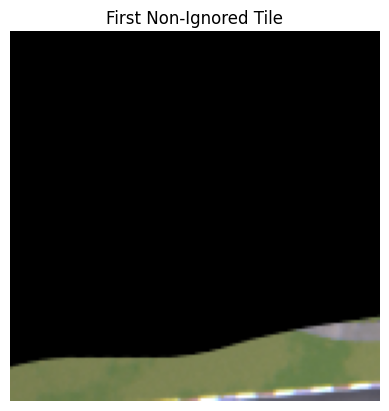

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

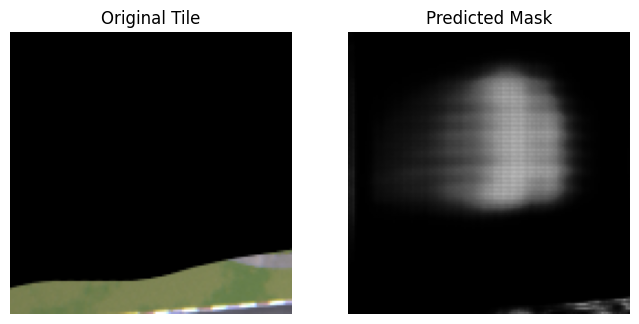

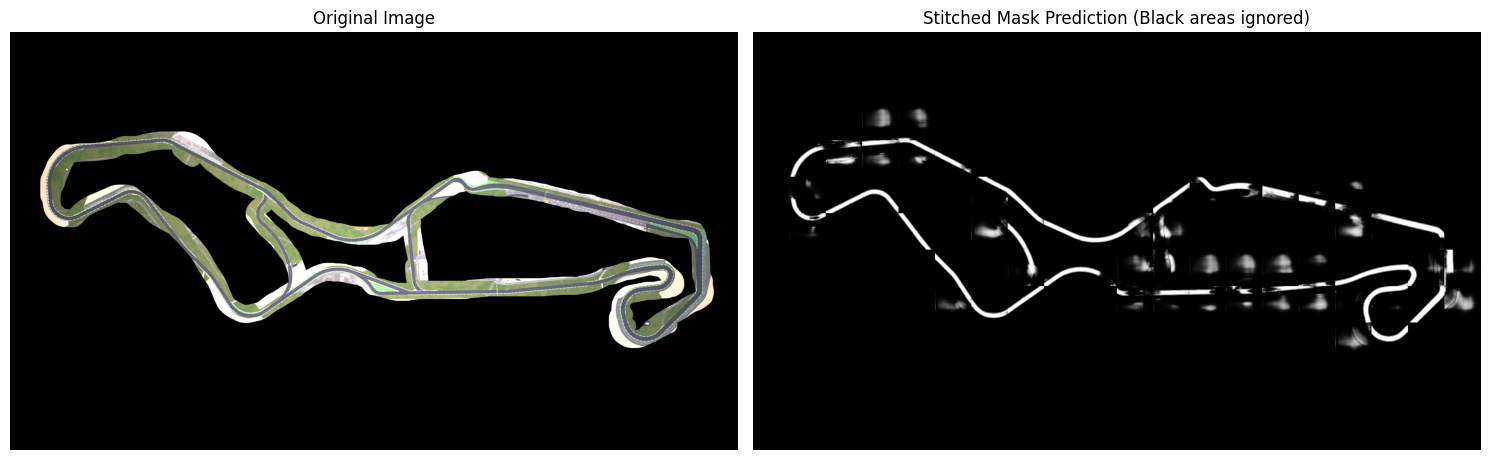

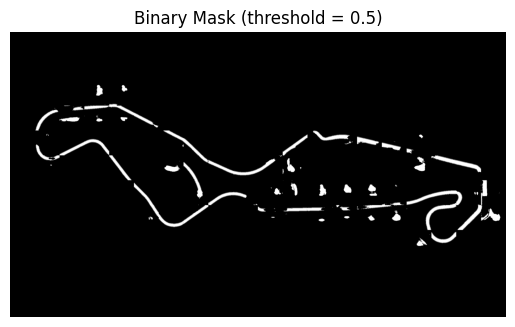

In [8]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)  # Use compile=True to keep original settings

# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    
    Args:
        tile_array: numpy array of the tile (H, W, 3)
        black_threshold: percentage of black pixels required to ignore tile (0.0 to 1.0)
        black_color: RGB tuple for the black color to ignore (default: #000000)
    
    Returns:
        bool: True if tile should be ignored, False otherwise
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    # Create mask for black pixels
    black_mask = np.all(tile_array == black_color, axis=-1)
    
    # Calculate percentage of black pixels
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

# Step 4: Modified tile_image function to filter black tiles
def tile_image(image, tile_size=(128, 128), black_threshold=0.85):
    """
    Splits an image into tiles of given size, filtering out predominantly black tiles.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []  # Store coordinates for stitching
    tile_ignore_mask = []  # Track which tiles should be ignored

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # Crop tile
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            # If tile is smaller, pad it
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            
            # Check if tile should be ignored
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                # For ignored tiles, we'll still need placeholder coordinates
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Load original image
original_image = Image.open(IMAGE_PATH).convert("RGB")

# Generate tiles with black filtering
tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), black_threshold=0.85)

print(f"Total tiles: {len(tile_coordinates)}")
print(f"Tiles to process: {len(tiles)}")
print(f"Tiles ignored (black): {sum(ignore_mask)}")

# Show the first non-ignored tile if available
if len(tiles) > 0:
    plt.imshow(tiles[0])
    plt.title("First Non-Ignored Tile")
    plt.axis("off")
    plt.show()
else:
    print("All tiles were ignored!")

# Step 5: Predict on all non-ignored tiles with proper preprocessing
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    # Convert to float and normalize to [0, 1]
    tile = tile.astype(np.float32) / 255.0
    return tile

predictions = []
tile_index = 0

for i, ignore in enumerate(ignore_mask):
    if ignore:
        # Create a blank prediction for ignored tiles (all zeros)
        blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
        predictions.append(blank_prediction)
    else:
        # Process and predict on non-ignored tiles
        processed_tile = preprocess_tile(tiles[tile_index])
        prediction = model.predict(np.expand_dims(processed_tile, axis=0))
        predictions.append(prediction[0])  # Remove batch dimension
        tile_index += 1

# Step 6: Visualization function
def visualize_results(predicted_mask, original_image):
    predicted_mask = np.squeeze(predicted_mask)
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Tile')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Show results for first non-ignored tile if available
if len(tiles) > 0:
    first_non_ignored_idx = next((i for i, ignore in enumerate(ignore_mask) if not ignore), None)
    if first_non_ignored_idx is not None:
        visualize_results(predictions[first_non_ignored_idx], 
                         tiles[first_non_ignored_idx - sum(ignore_mask[:first_non_ignored_idx])])

# Step 7: Modified stitch function to handle ignored tiles
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    Handles ignored tiles by leaving those areas blank (0).
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Place the tile in the stitched image
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

# Step 8: Stitch predictions back into full mask
original_size = original_image.size  # (width, height)
stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))

# Step 9: Show stitched result
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask Prediction (Black areas ignored)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the result
stitched_mask_image = (stitched_mask * 255).astype(np.uint8)
Image.fromarray(stitched_mask_image).save('predicted_mask.png')

# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')
plt.show()

Loading and processing image...
Total tiles: 58
Processing 58 tiles with CNN
Ignored 194 black tiles

=== CNN PROCESSING AND FALSE POSITIVE FILTERING ===
✅ Tile 45: Valid prediction - keeping
✅ Tile 46: Valid prediction - keeping
🔴 Tile 64: FALSE POSITIVE detected - filtering out


/tmp/ipykernel_6025/1372110800.py:197: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


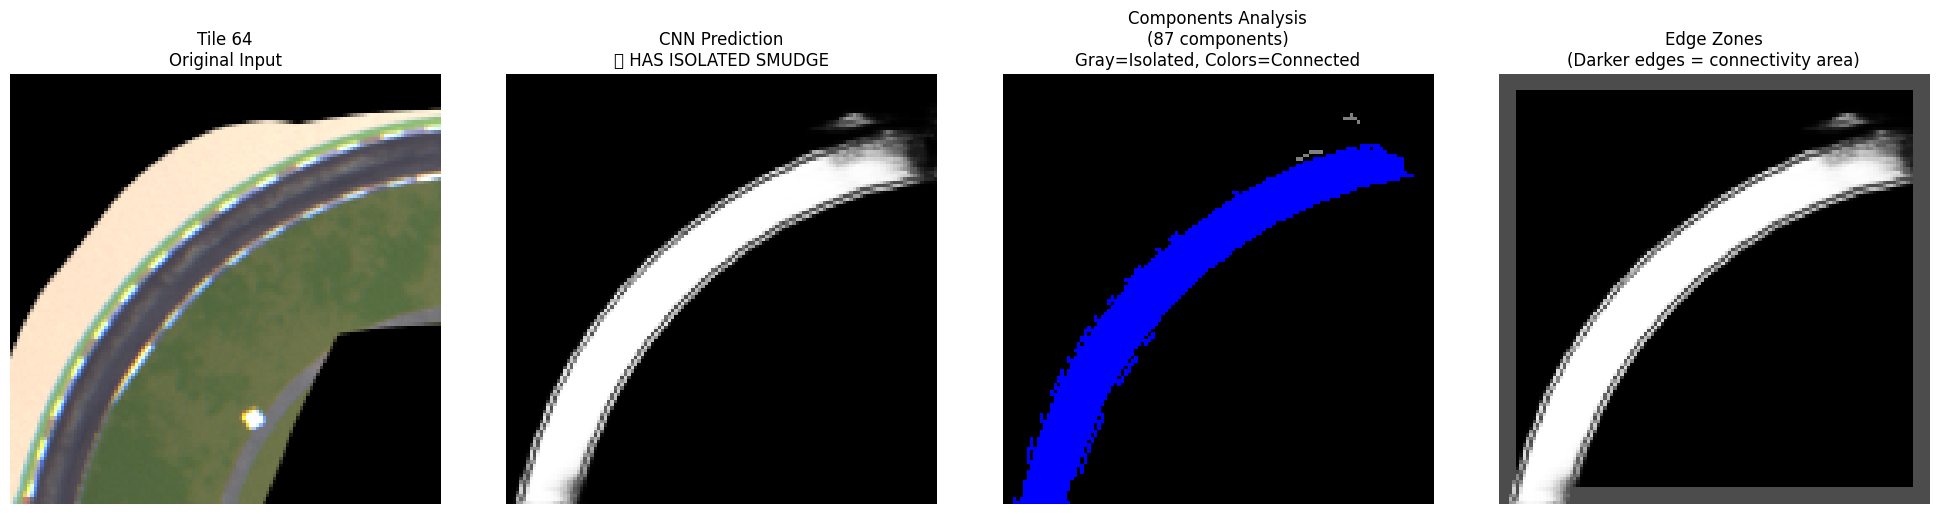

🔴 Tile 65: FALSE POSITIVE detected - filtering out


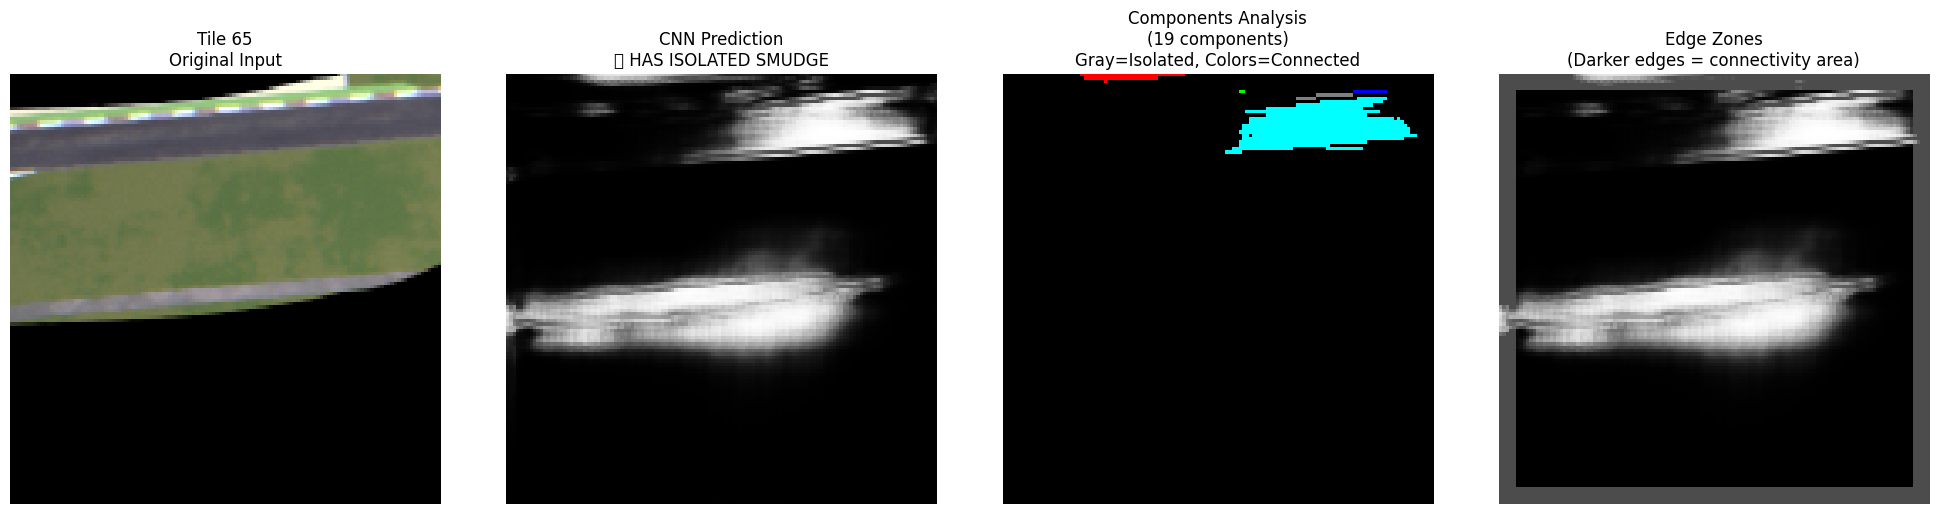

✅ Tile 66: Valid prediction - keeping
🔴 Tile 67: FALSE POSITIVE detected - filtering out


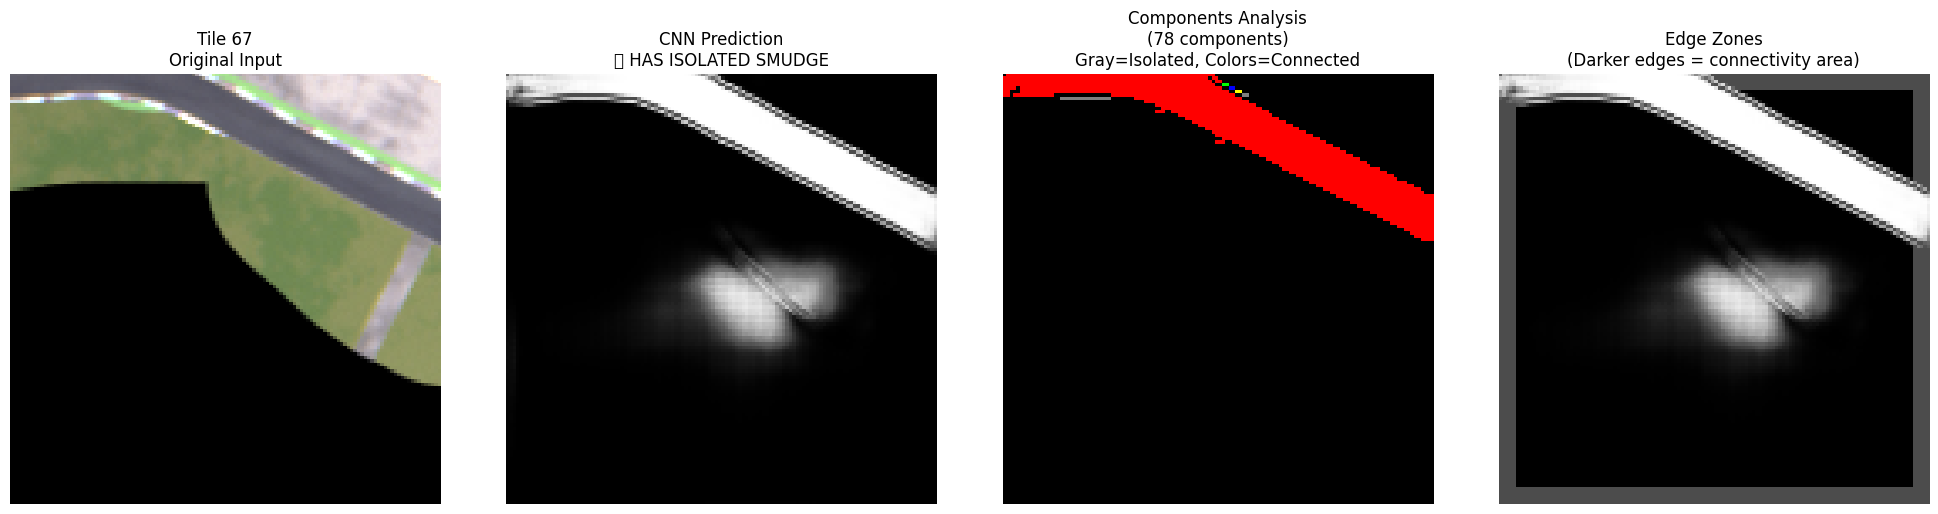

🔴 Tile 68: FALSE POSITIVE detected - filtering out


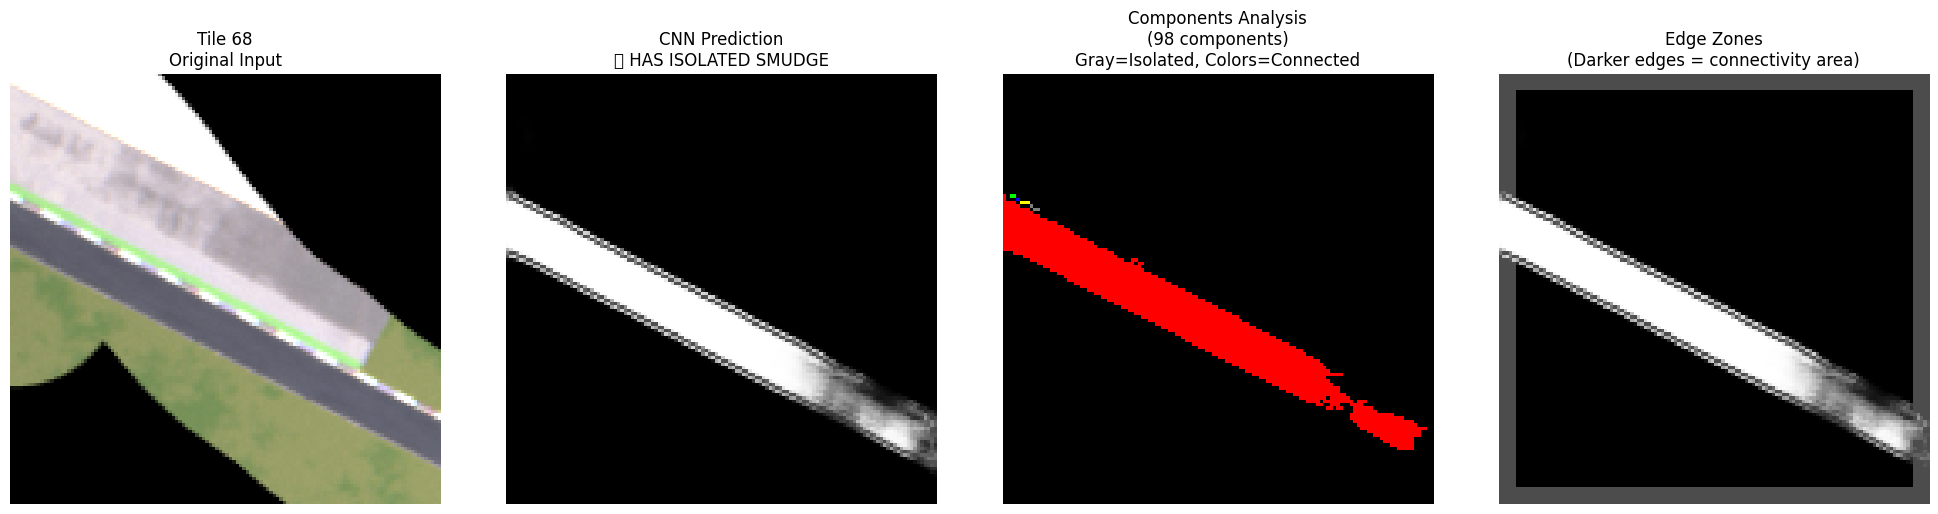

✅ Tile 85: Valid prediction - keeping
🔴 Tile 86: FALSE POSITIVE detected - filtering out


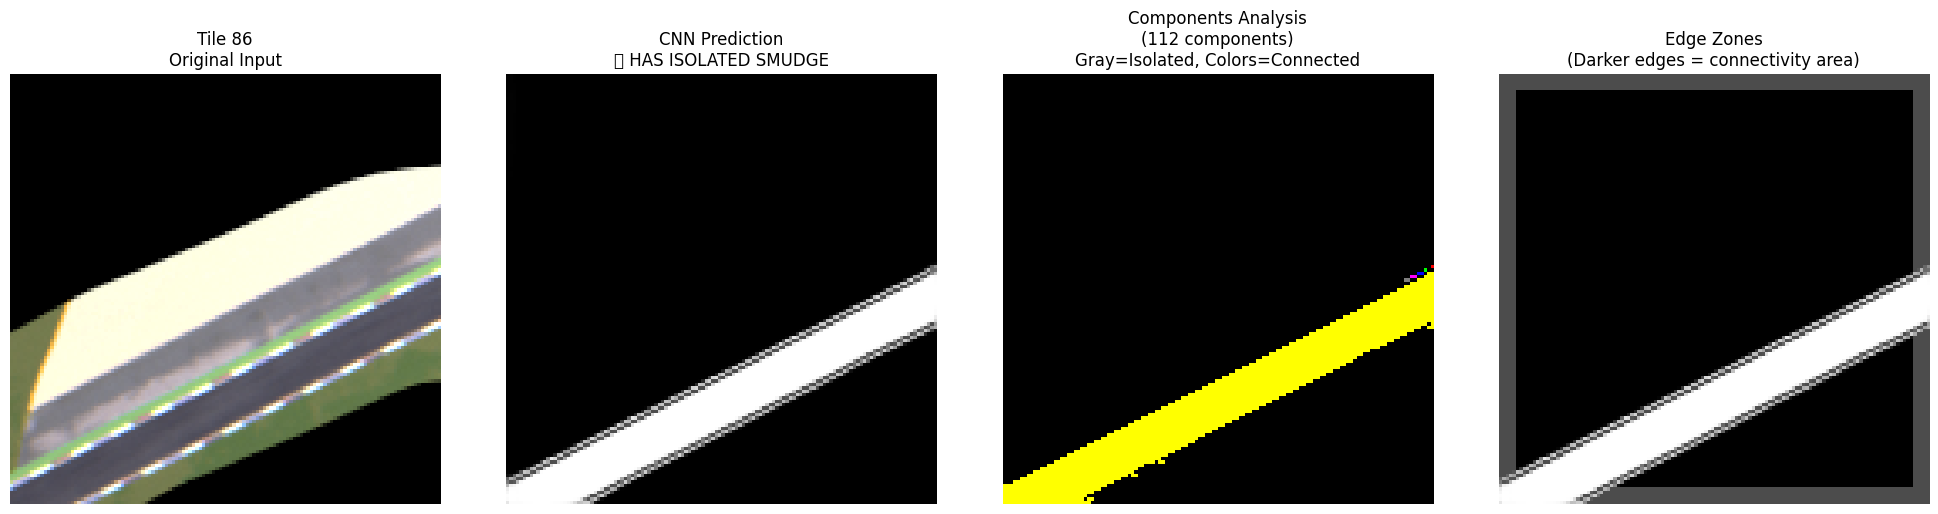

🔴 Tile 87: FALSE POSITIVE detected - filtering out


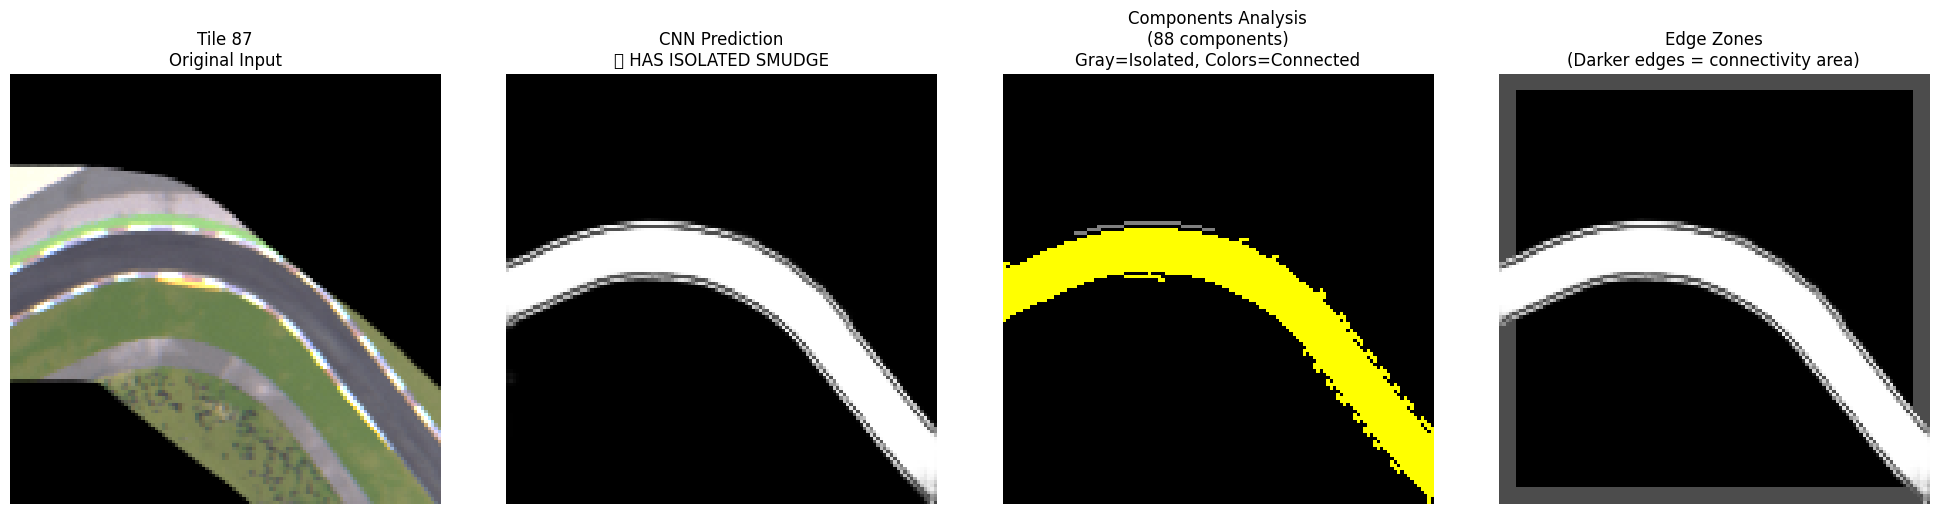

✅ Tile 90: Valid prediction - keeping
🔴 Tile 91: FALSE POSITIVE detected - filtering out


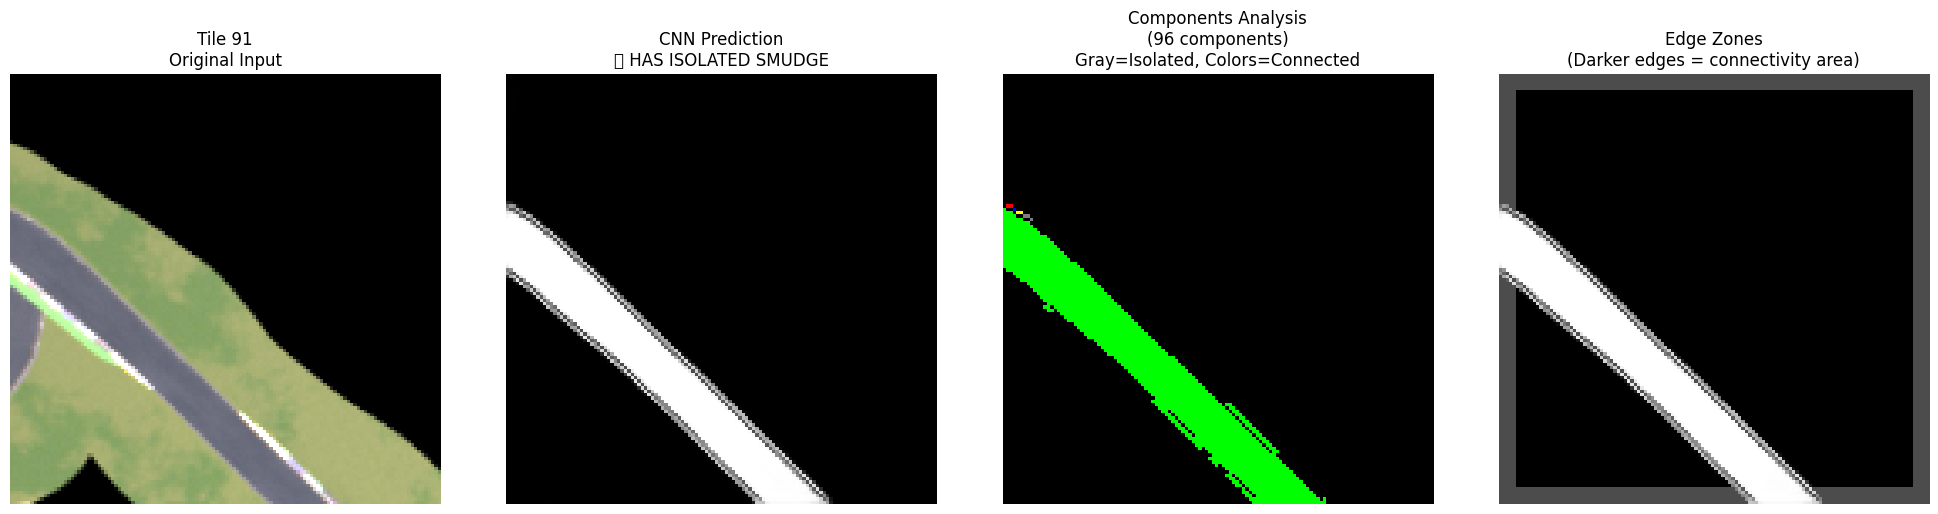

🔴 Tile 95: FALSE POSITIVE detected - filtering out


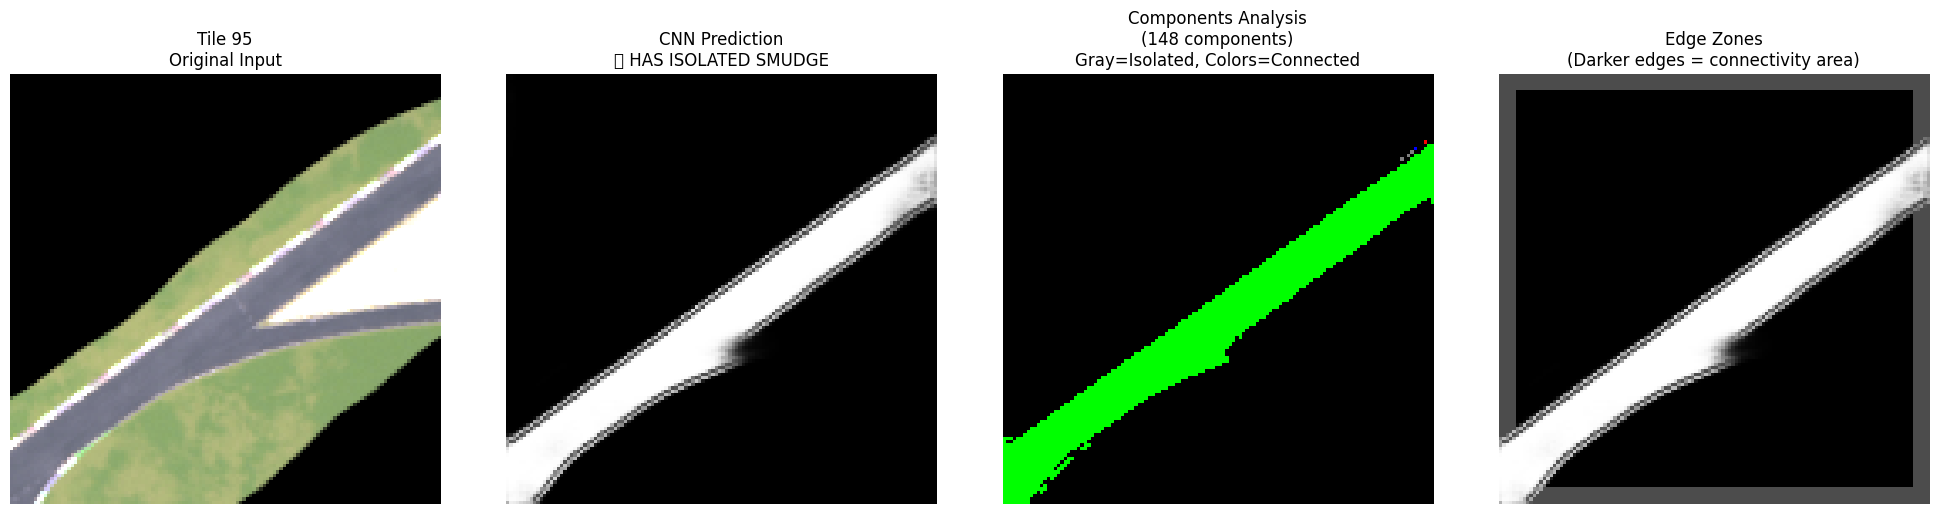

🔴 Tile 96: FALSE POSITIVE detected - filtering out


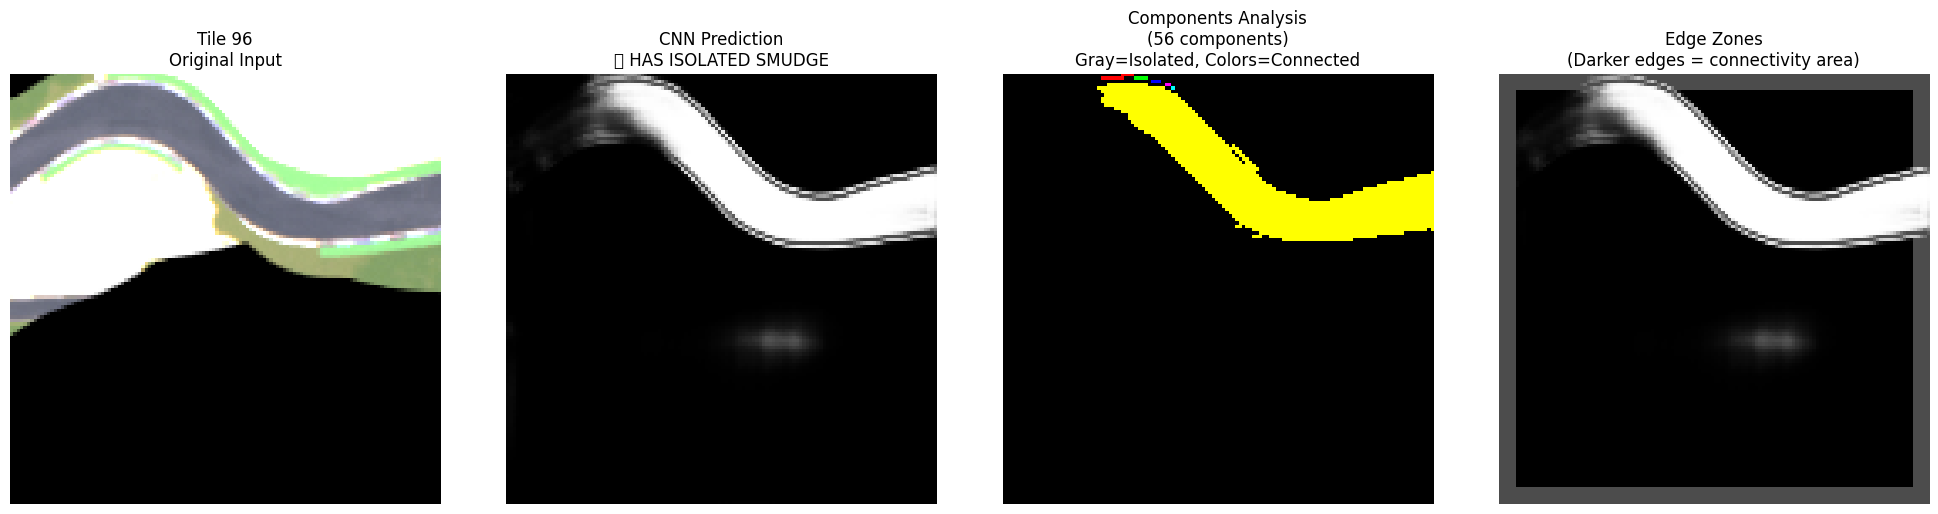

✅ Tile 97: Valid prediction - keeping
🔴 Tile 98: FALSE POSITIVE detected - filtering out


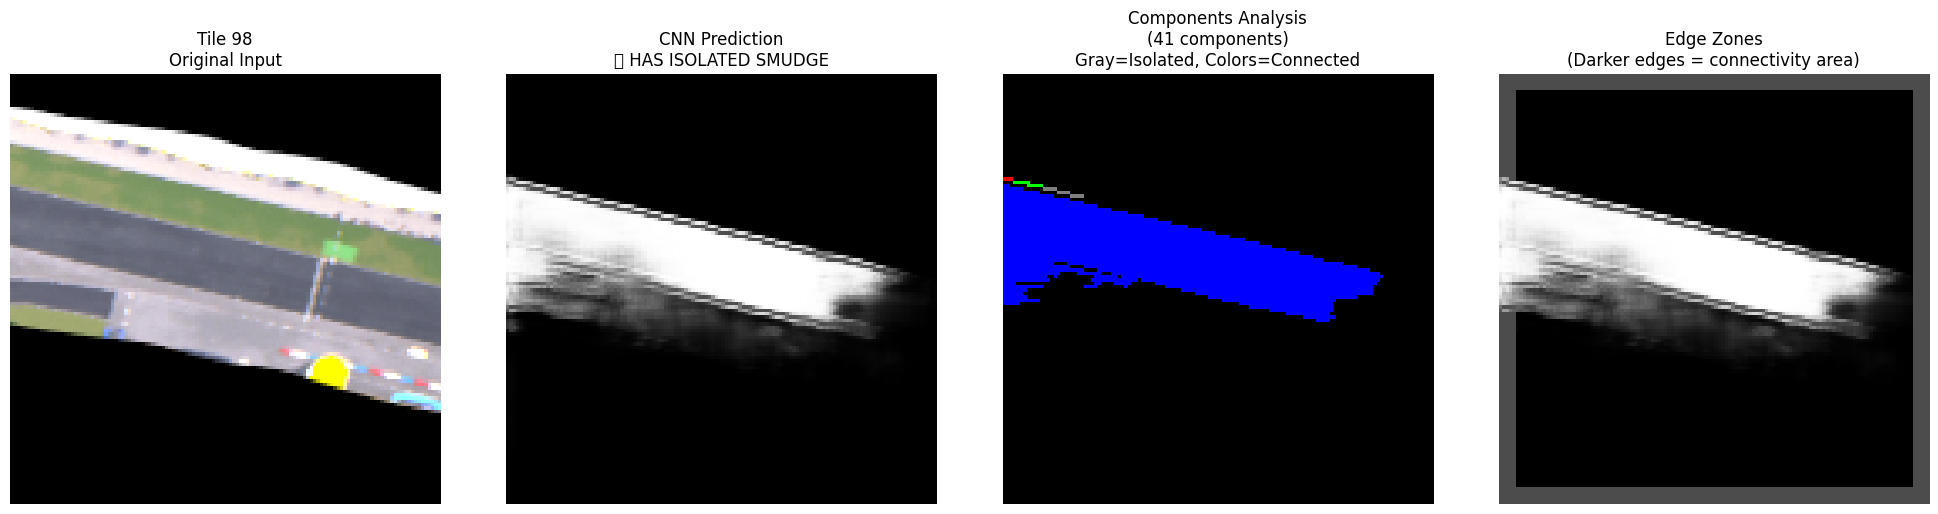

🔴 Tile 99: FALSE POSITIVE detected - filtering out


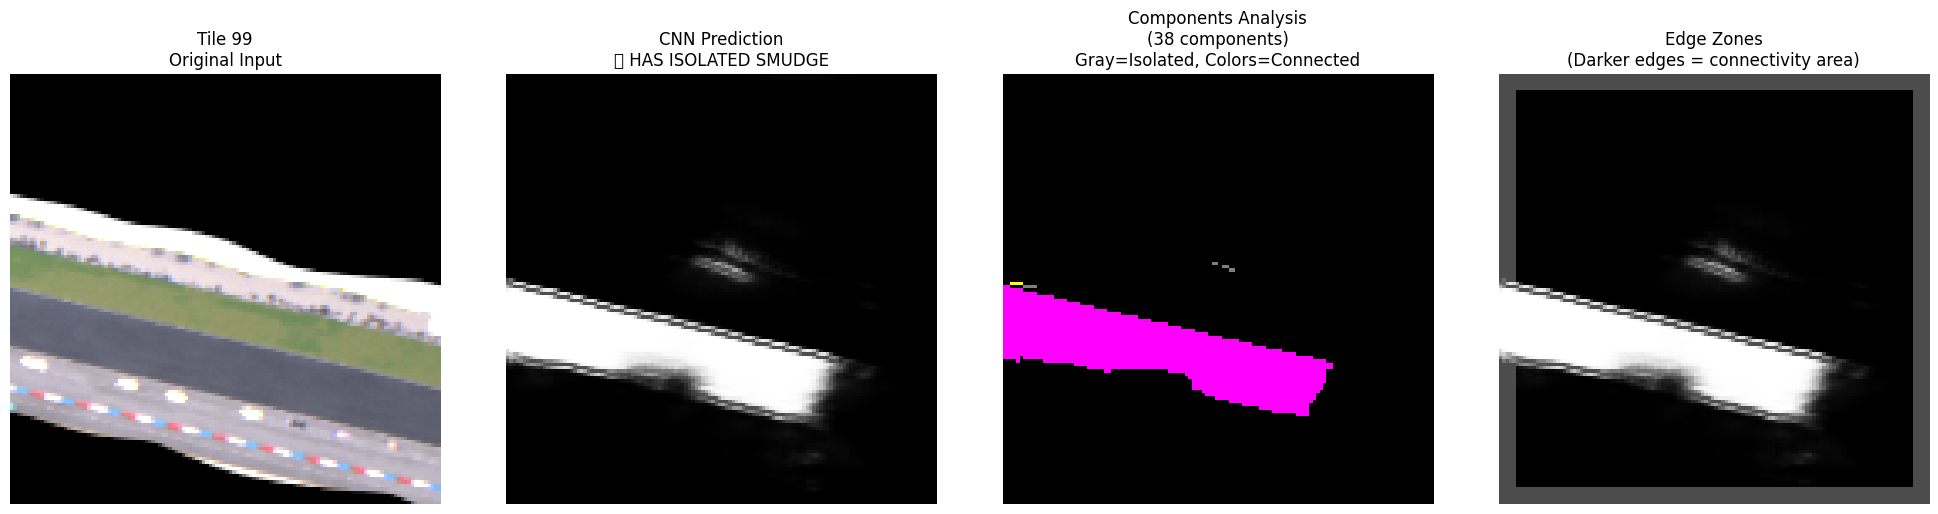

✅ Tile 100: Valid prediction - keeping
✅ Tile 106: Valid prediction - keeping
🔴 Tile 109: FALSE POSITIVE detected - filtering out


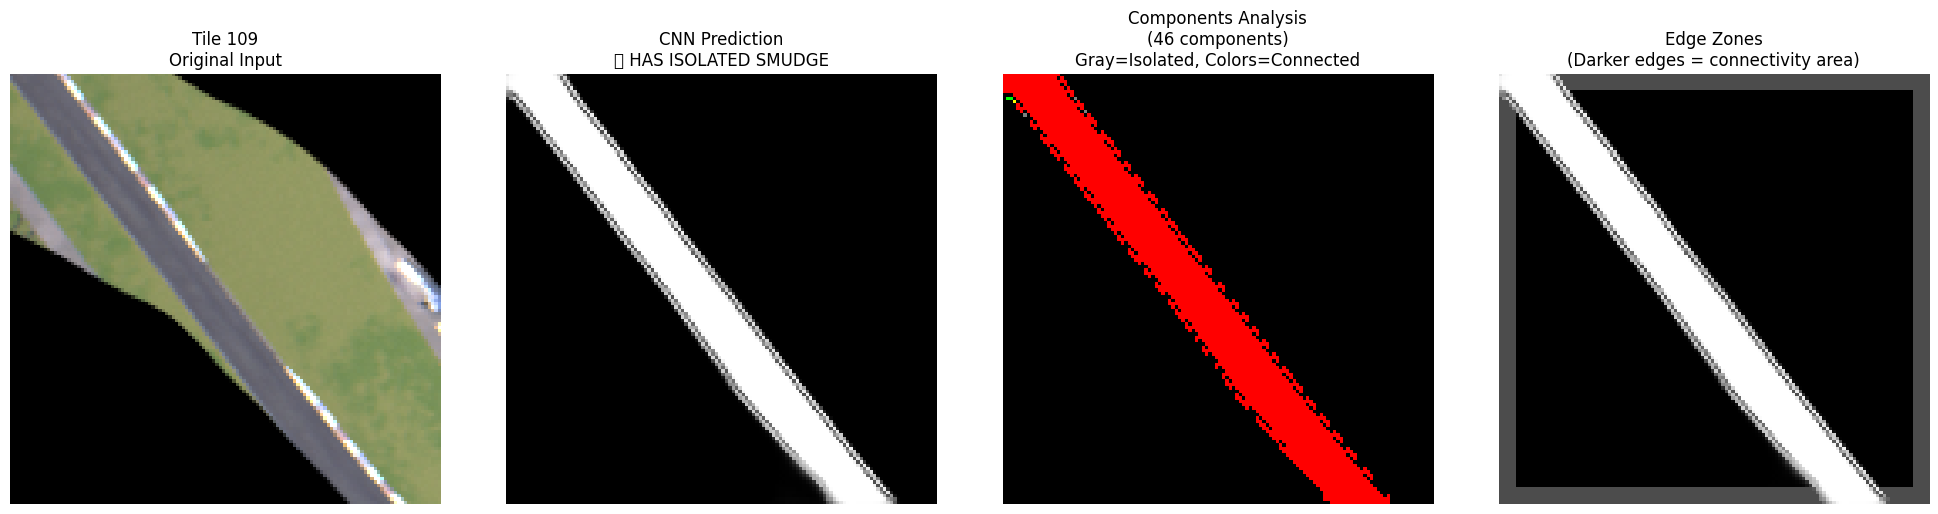

🔴 Tile 111: FALSE POSITIVE detected - filtering out


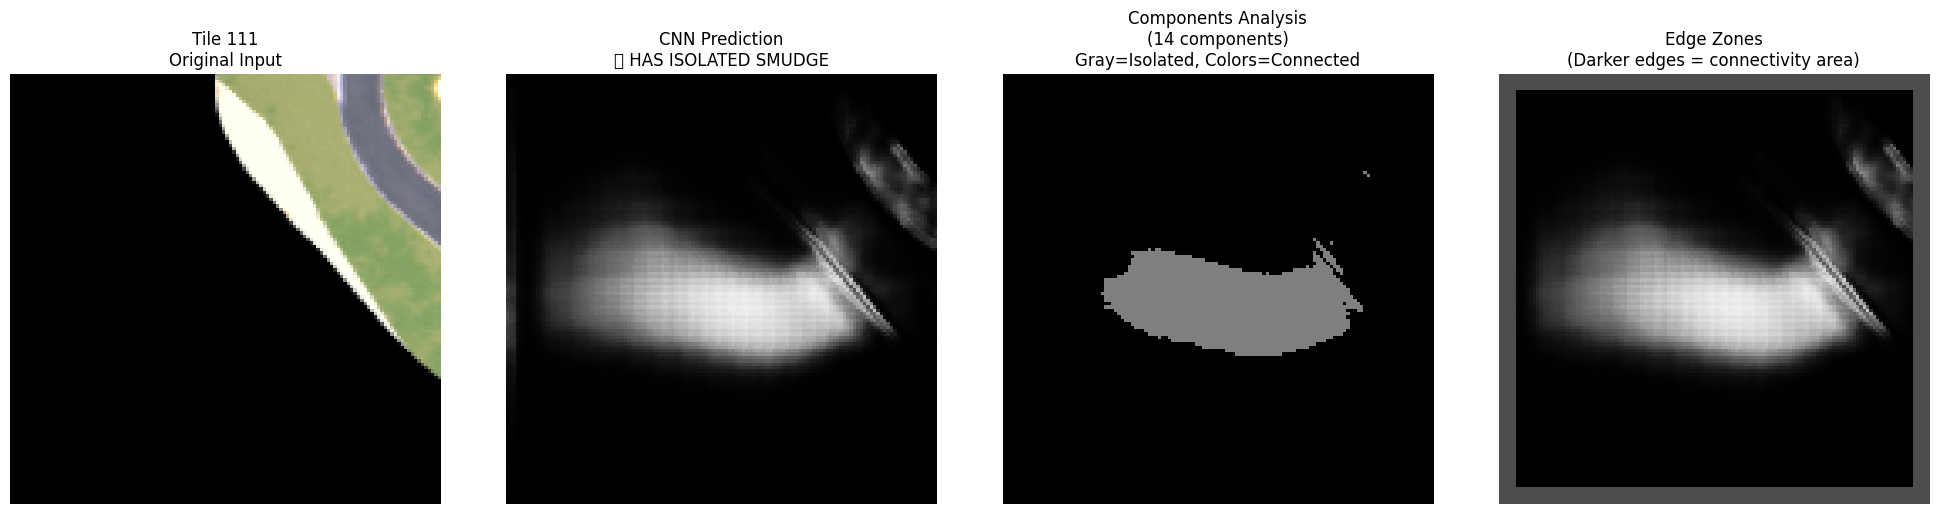

🔴 Tile 112: FALSE POSITIVE detected - filtering out


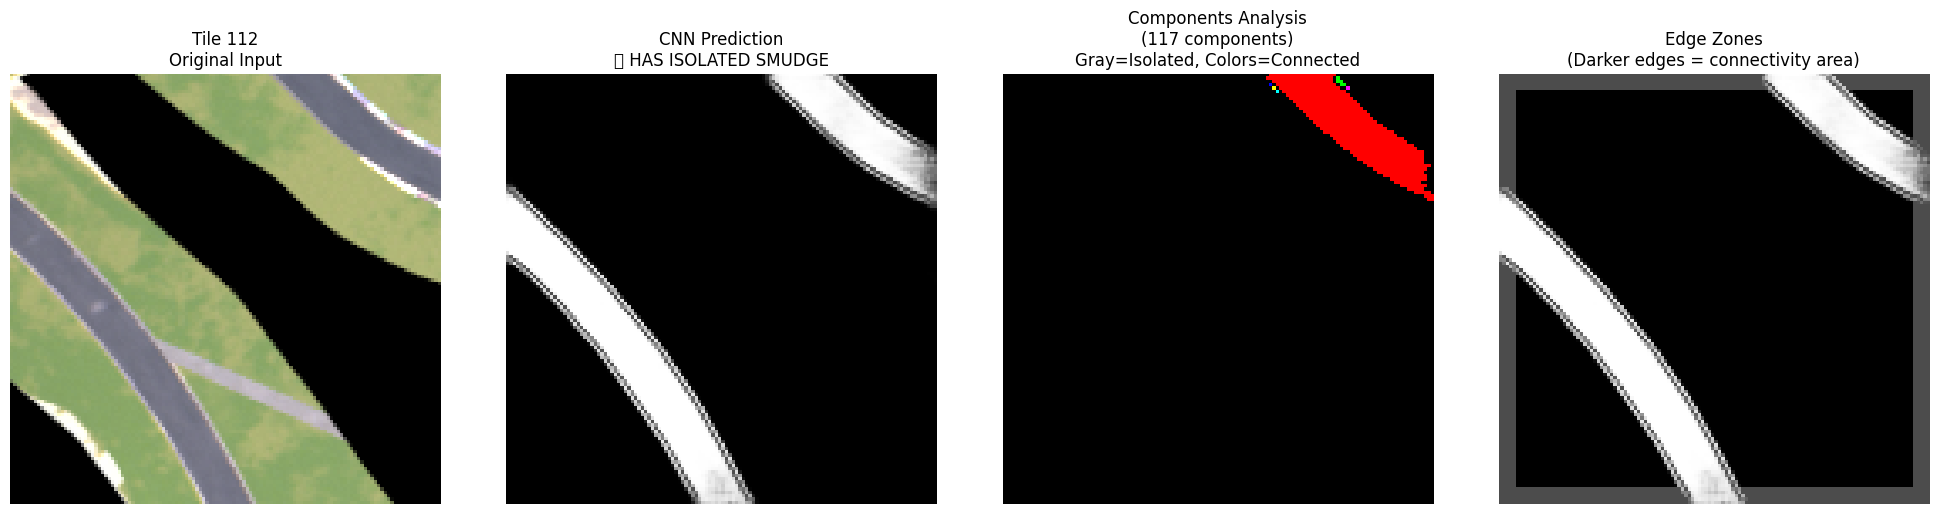

🔴 Tile 113: FALSE POSITIVE detected - filtering out


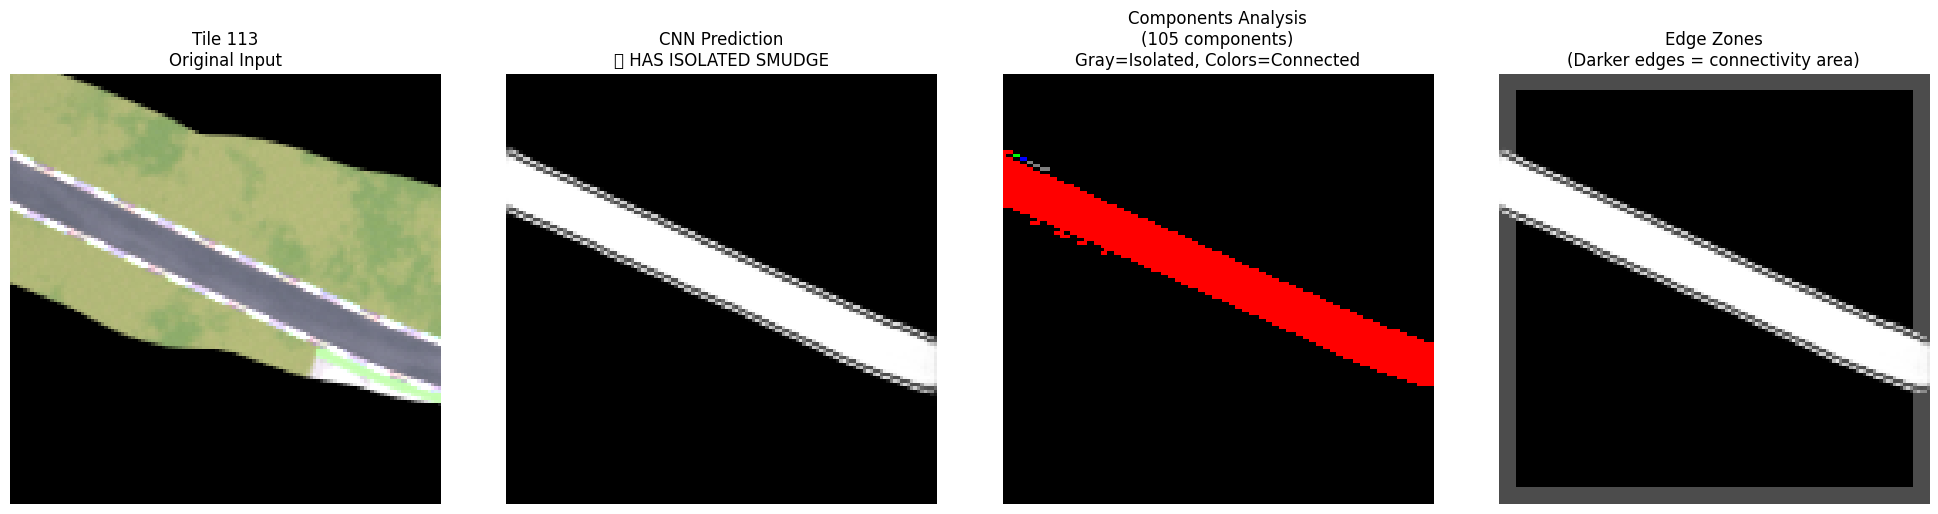

✅ Tile 114: Valid prediction - keeping
🔴 Tile 115: FALSE POSITIVE detected - filtering out


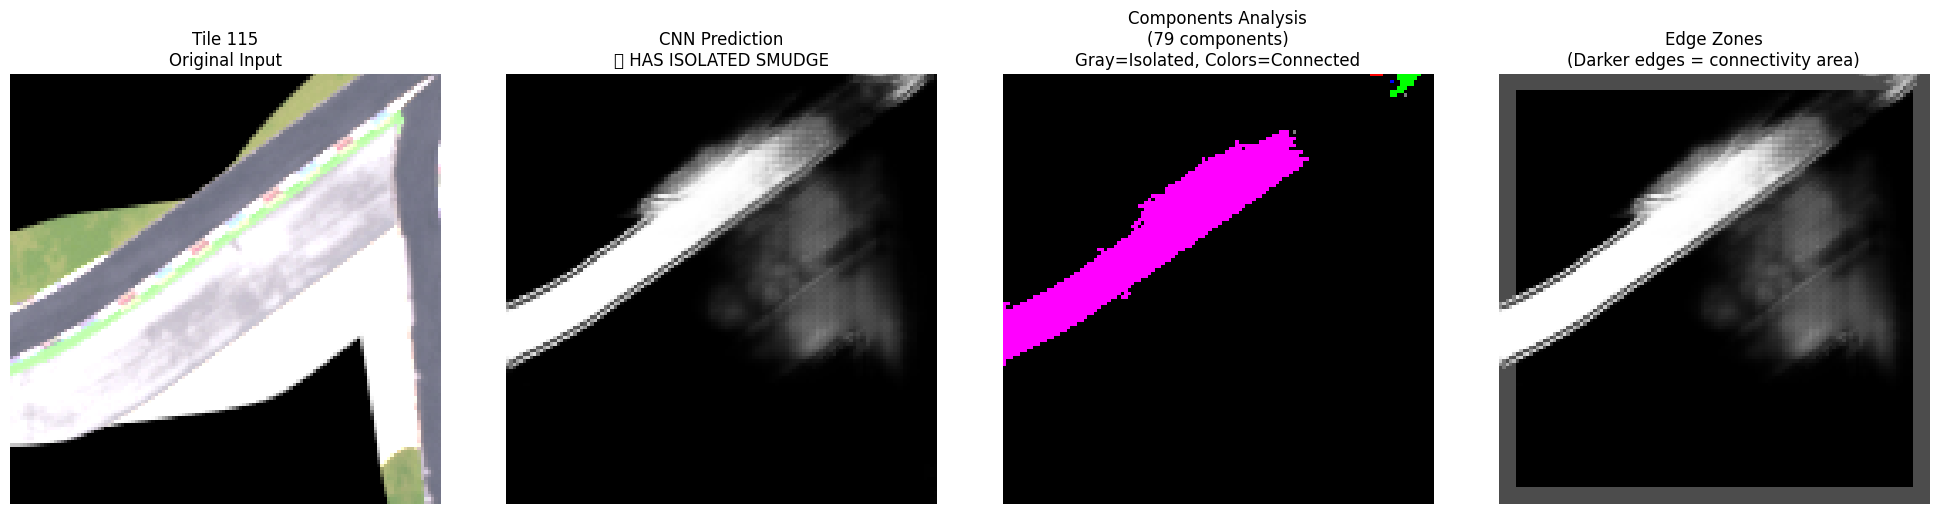

🔴 Tile 116: FALSE POSITIVE detected - filtering out


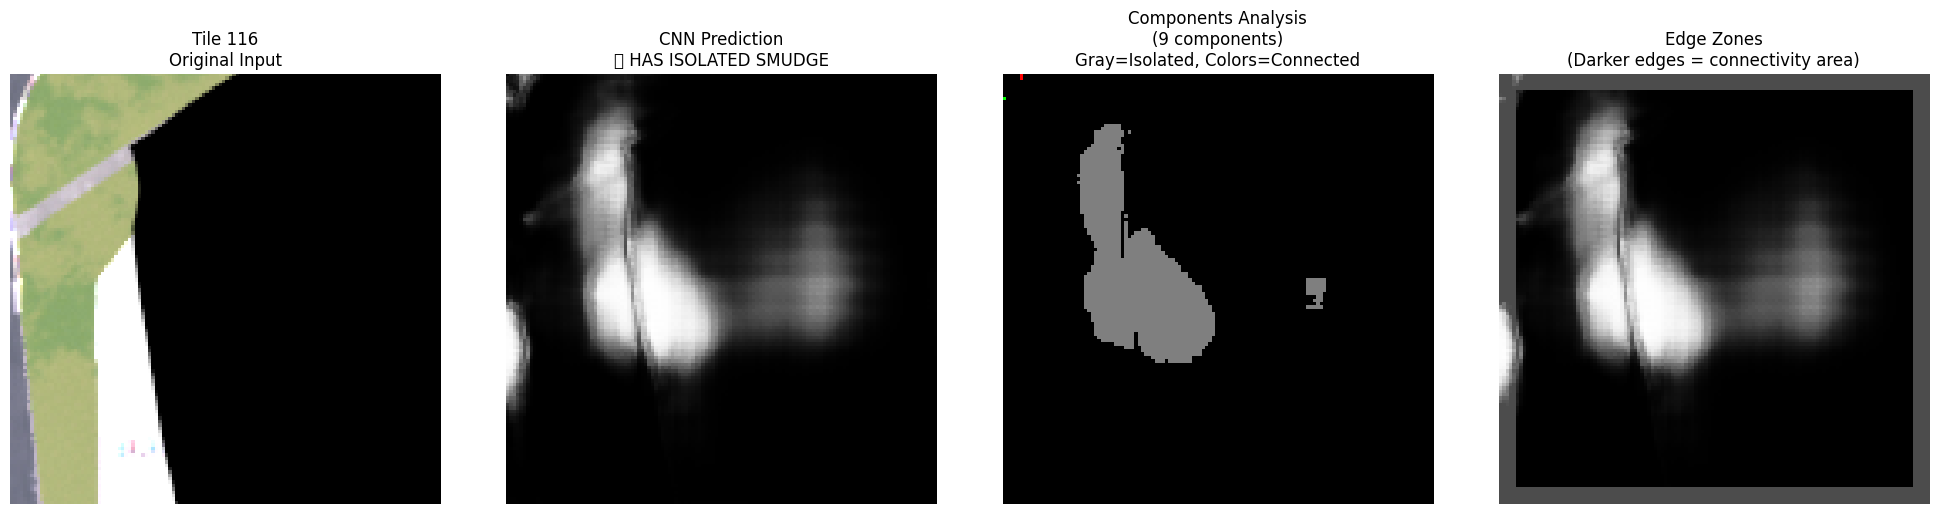

🔴 Tile 121: FALSE POSITIVE detected - filtering out


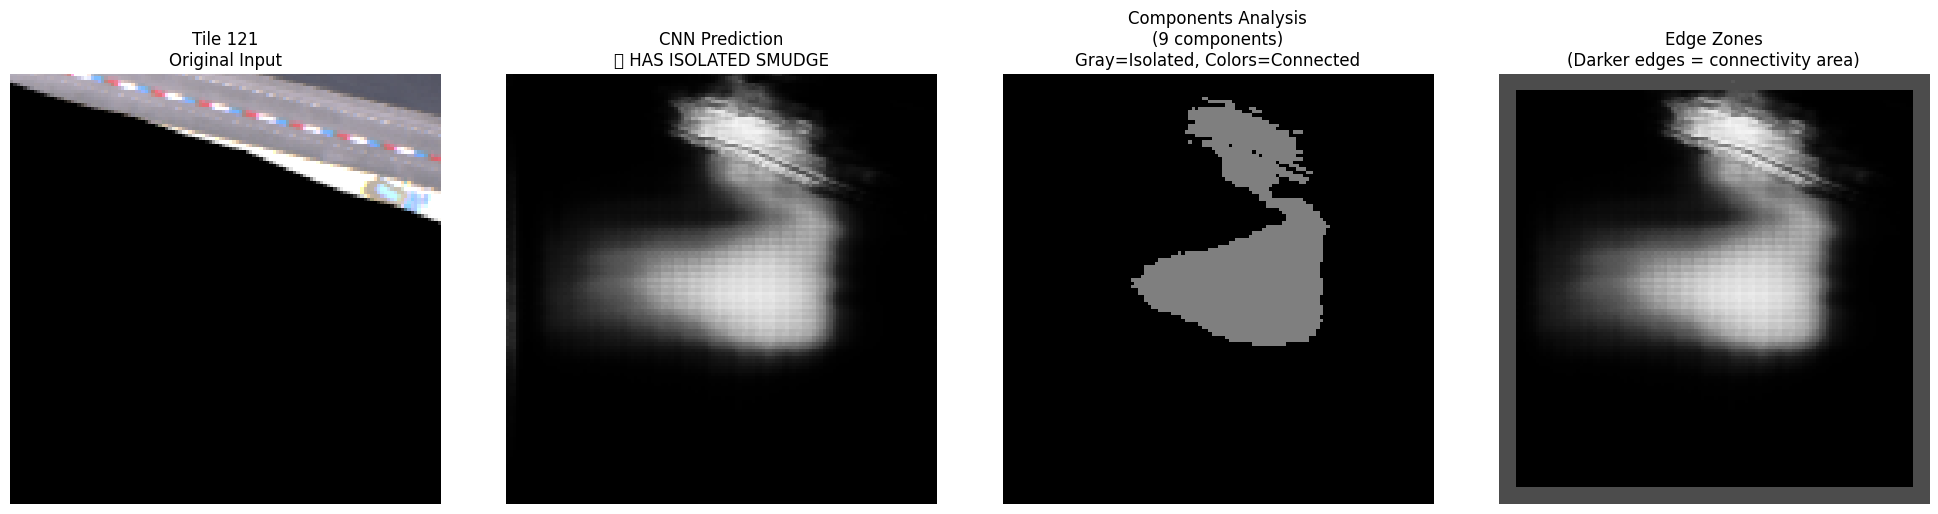

✅ Tile 122: Valid prediction - keeping
🔴 Tile 123: FALSE POSITIVE detected - filtering out


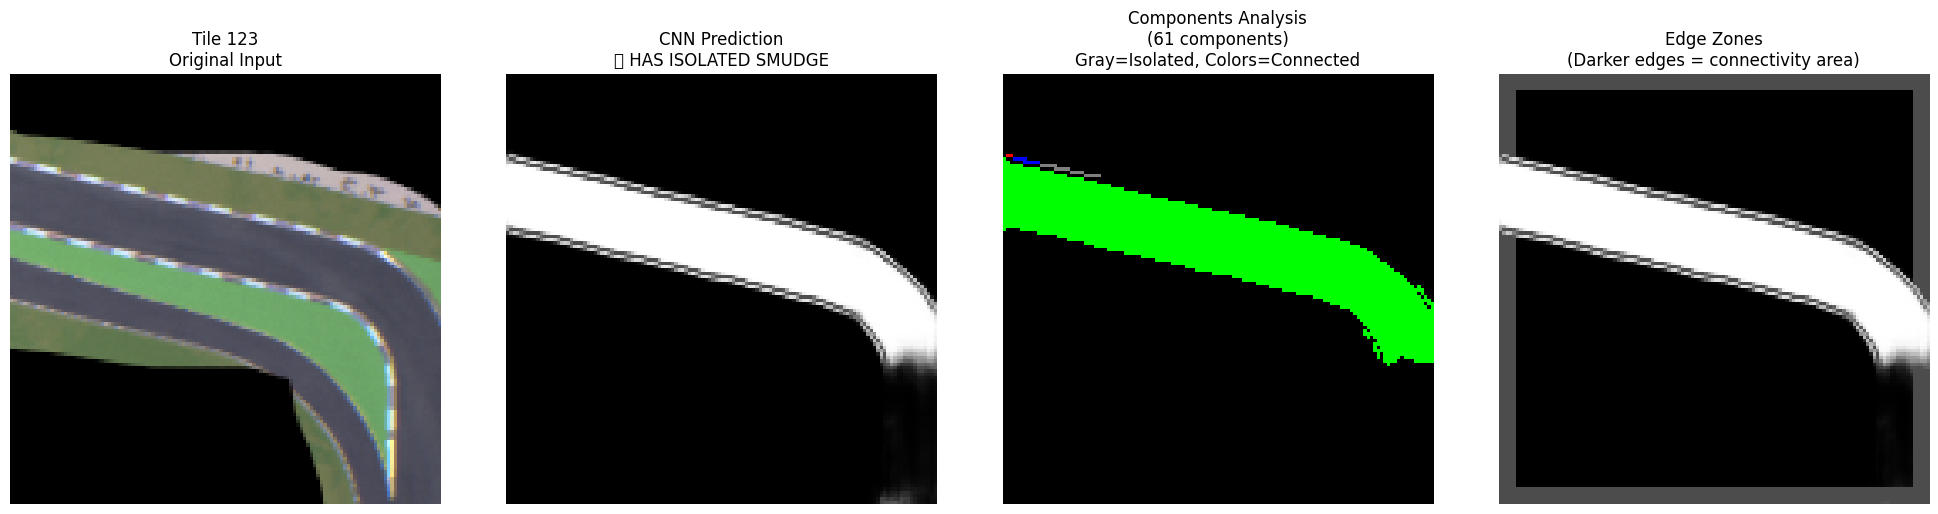

🔴 Tile 131: FALSE POSITIVE detected - filtering out


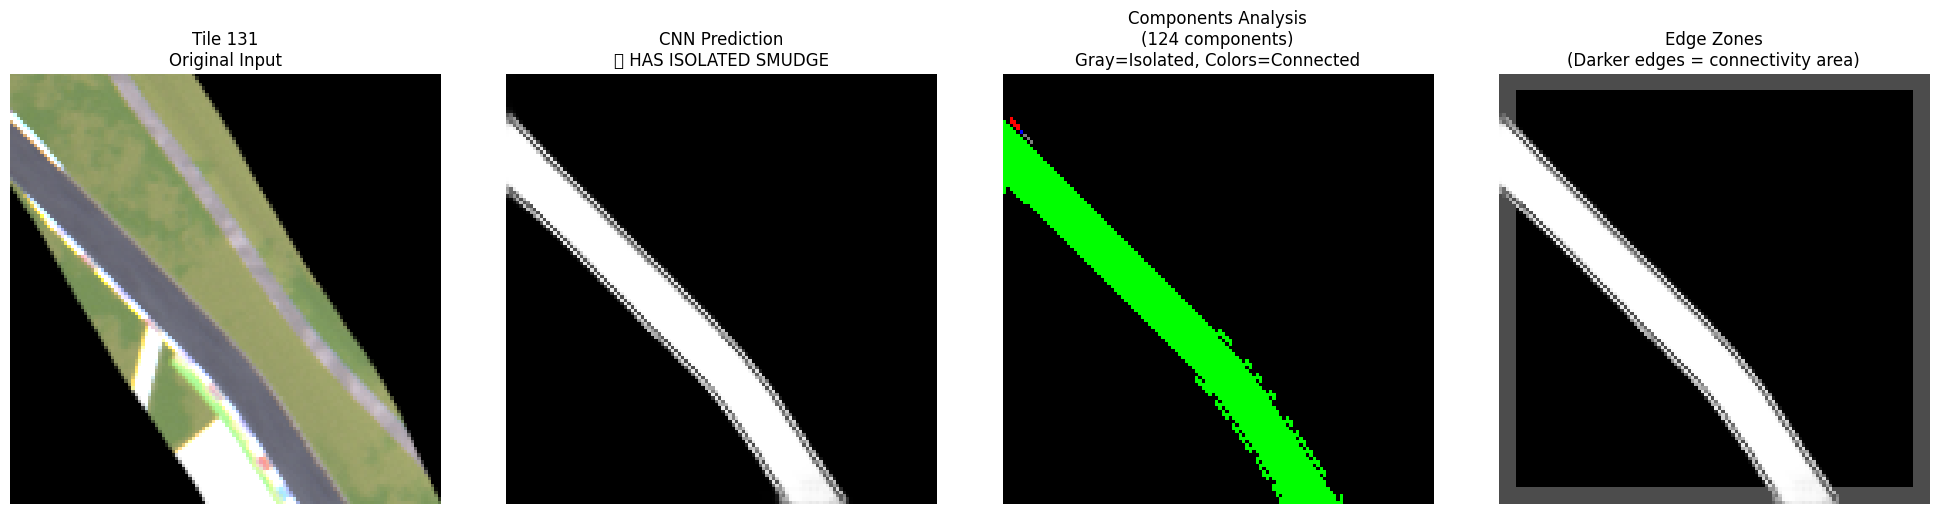

🔴 Tile 133: FALSE POSITIVE detected - filtering out


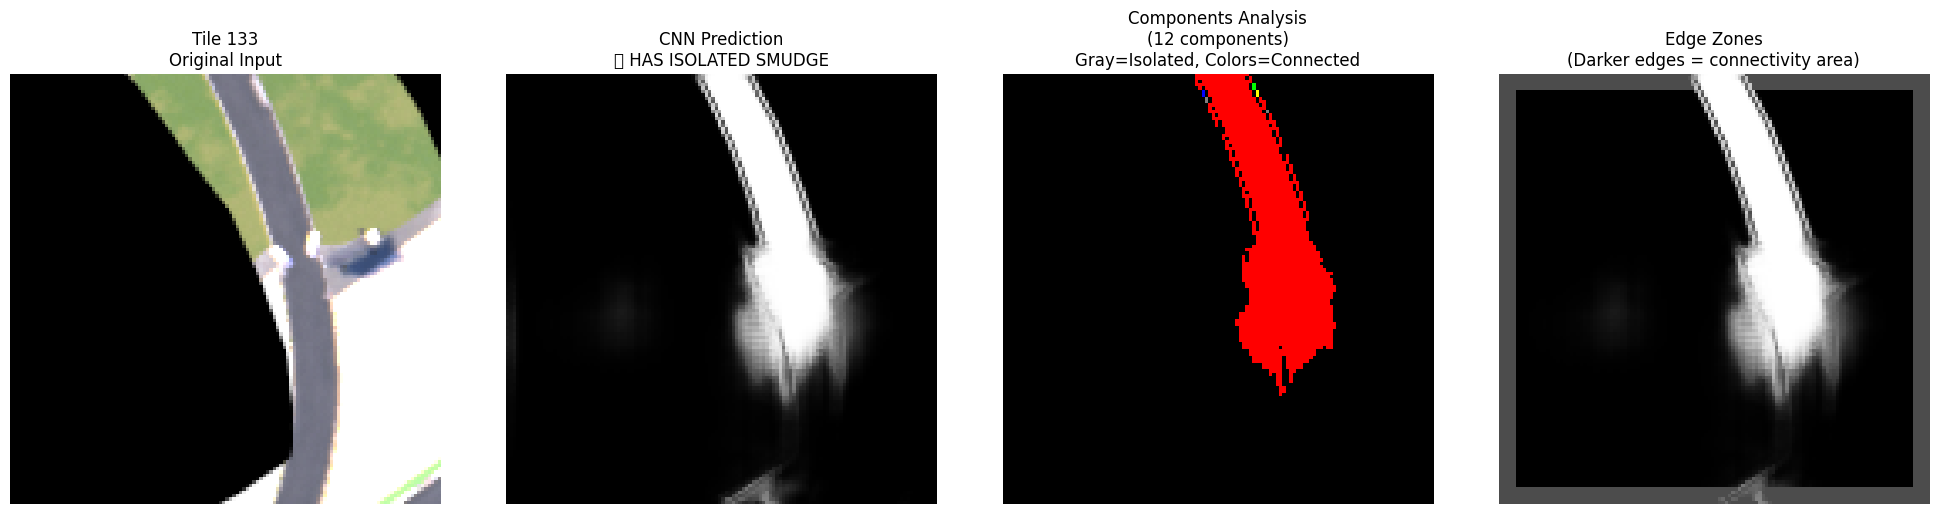

🔴 Tile 134: FALSE POSITIVE detected - filtering out


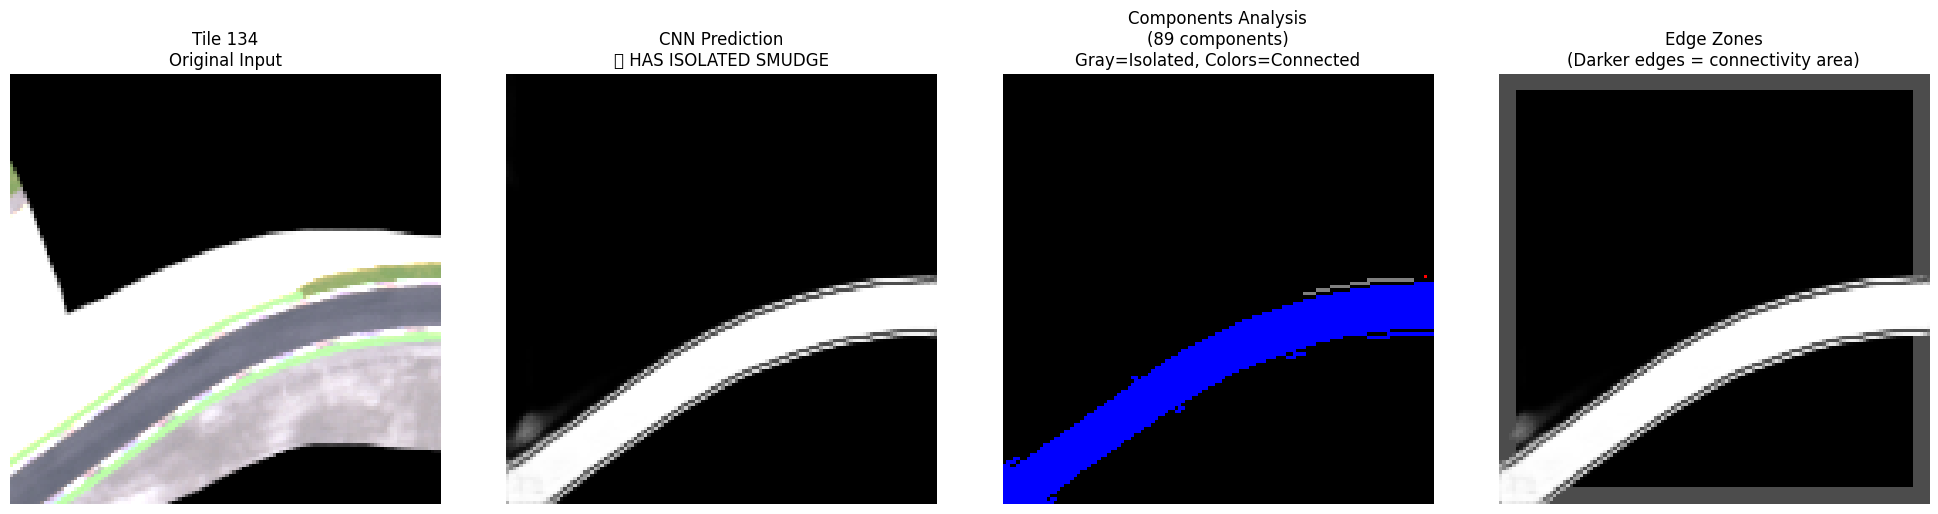

🔴 Tile 135: FALSE POSITIVE detected - filtering out


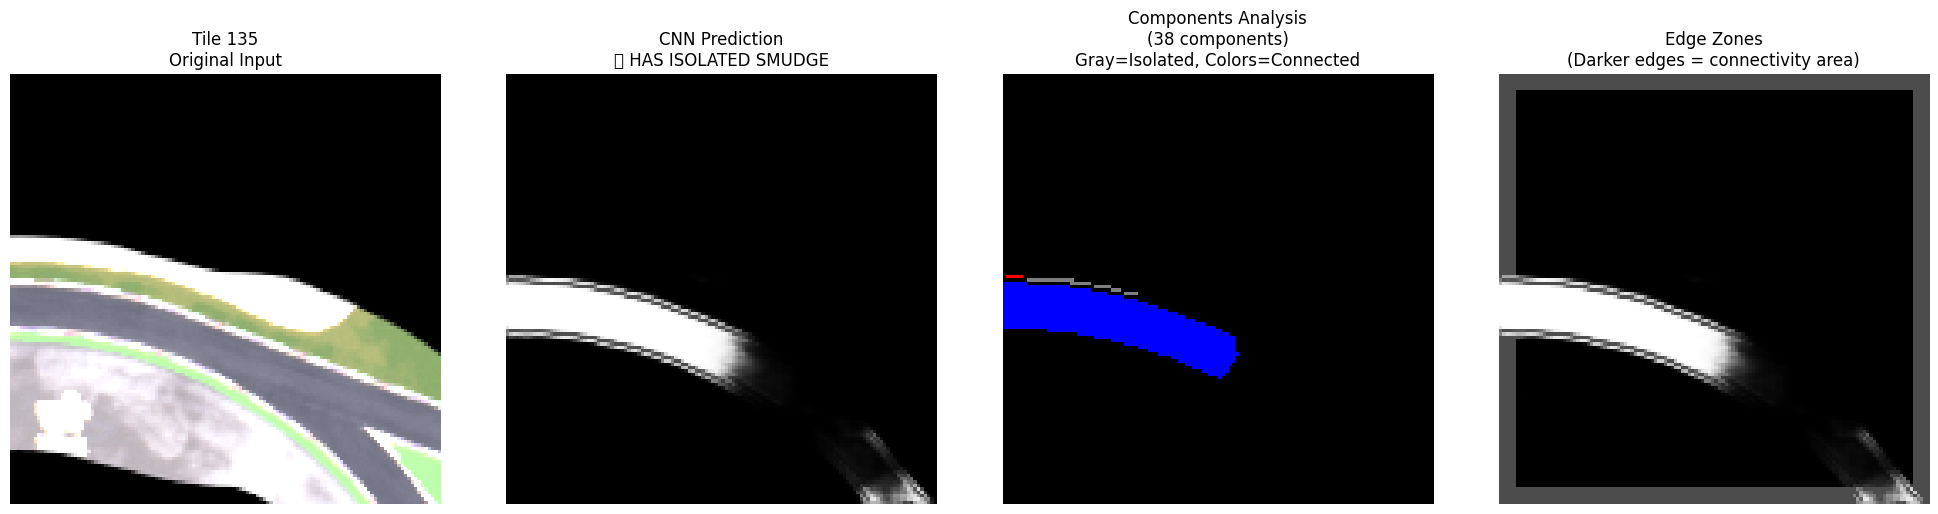

✅ Tile 136: Valid prediction - keeping
🔴 Tile 137: FALSE POSITIVE detected - filtering out


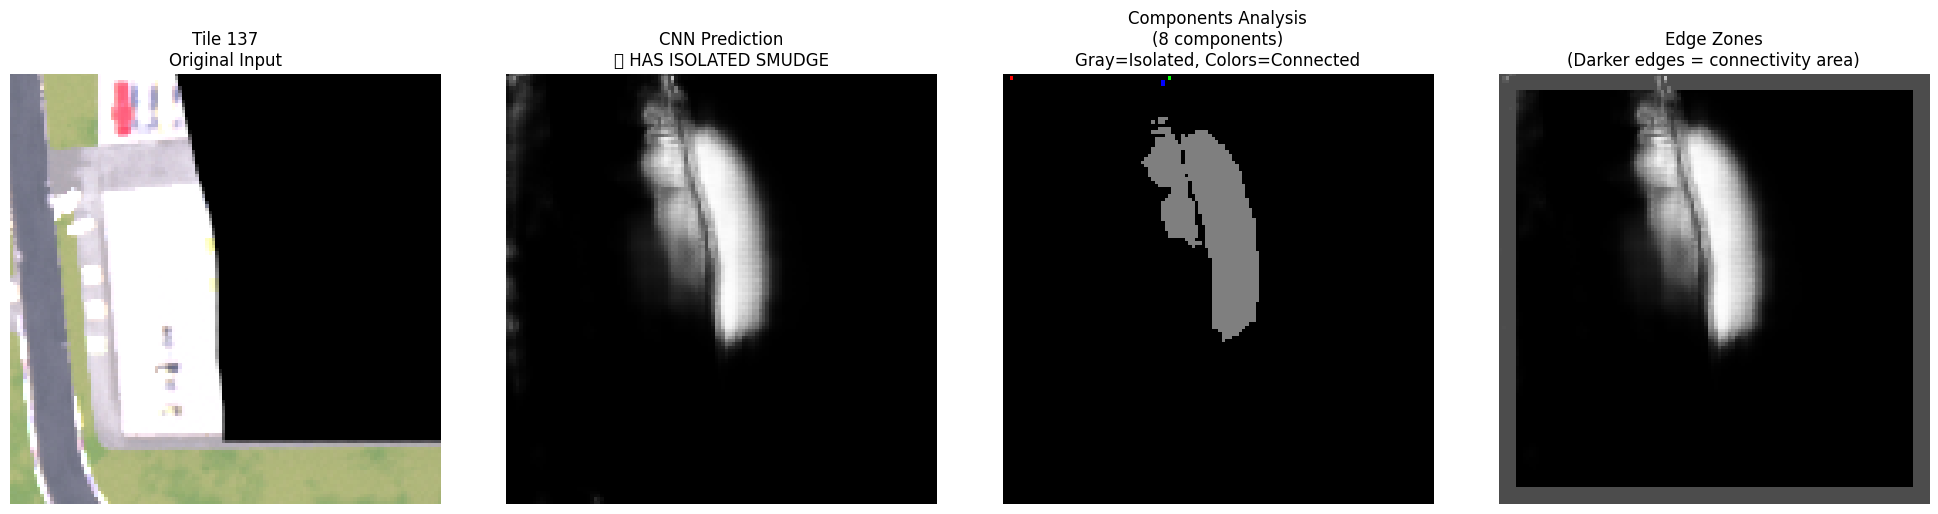

✅ Tile 138: Valid prediction - keeping
✅ Tile 139: Valid prediction - keeping
✅ Tile 140: Valid prediction - keeping
✅ Tile 141: Valid prediction - keeping
✅ Tile 142: Valid prediction - keeping
🔴 Tile 143: FALSE POSITIVE detected - filtering out


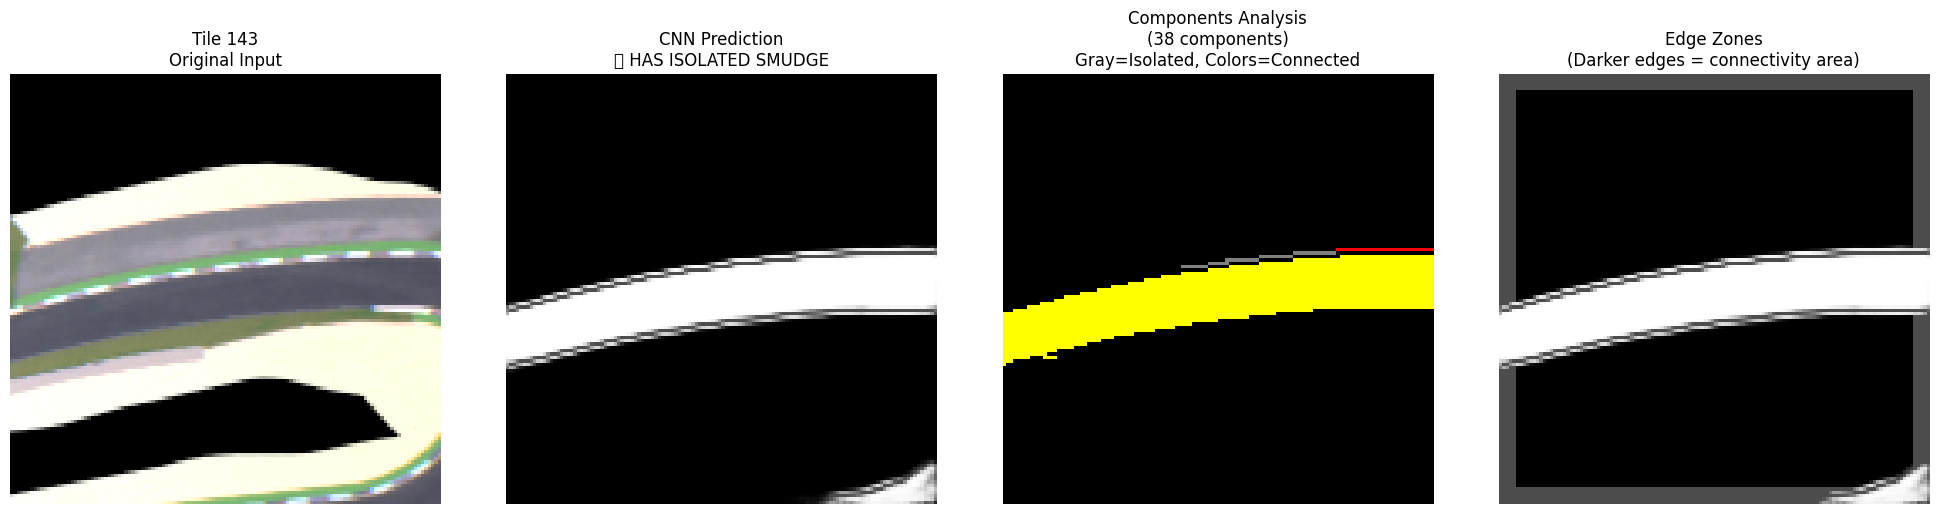

✅ Tile 144: Valid prediction - keeping
✅ Tile 145: Valid prediction - keeping
✅ Tile 152: Valid prediction - keeping
✅ Tile 153: Valid prediction - keeping
🔴 Tile 154: FALSE POSITIVE detected - filtering out


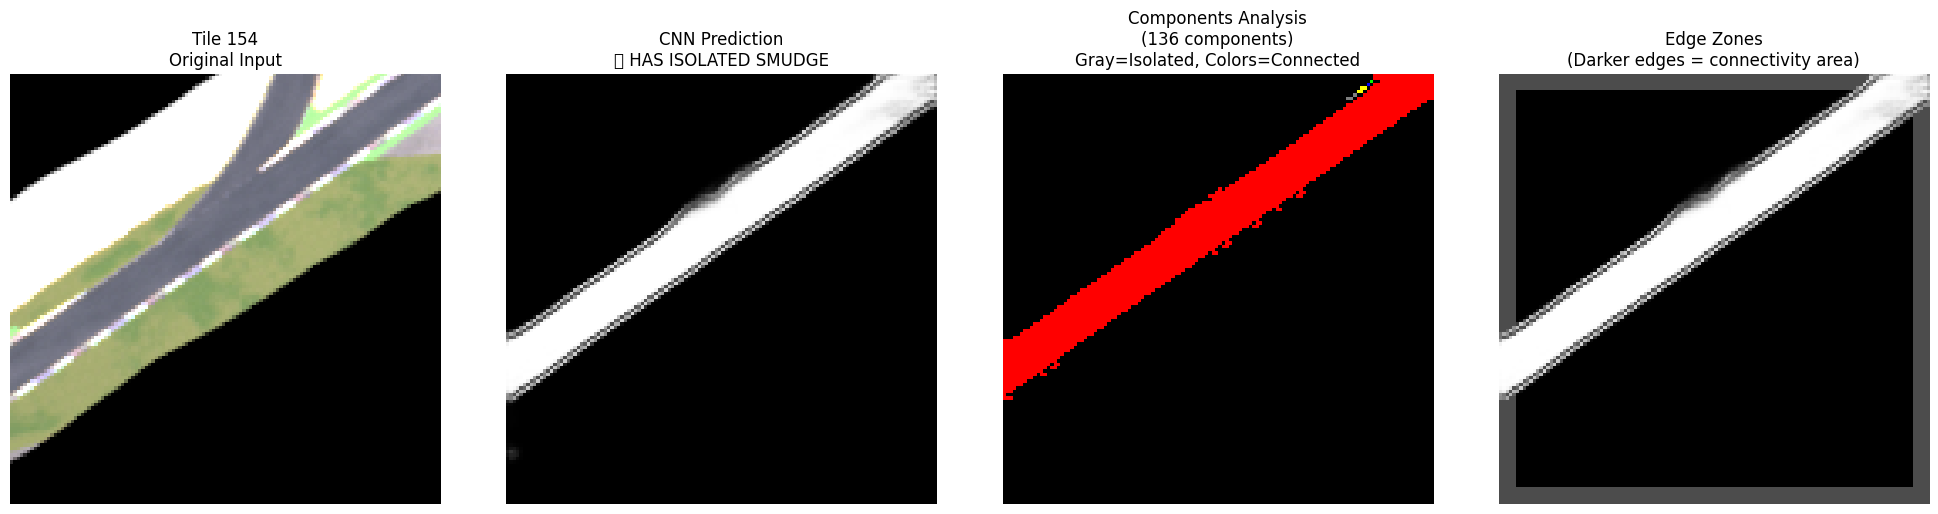

✅ Tile 157: Valid prediction - keeping
✅ Tile 158: Valid prediction - keeping
✅ Tile 159: Valid prediction - keeping
🔴 Tile 160: FALSE POSITIVE detected - filtering out


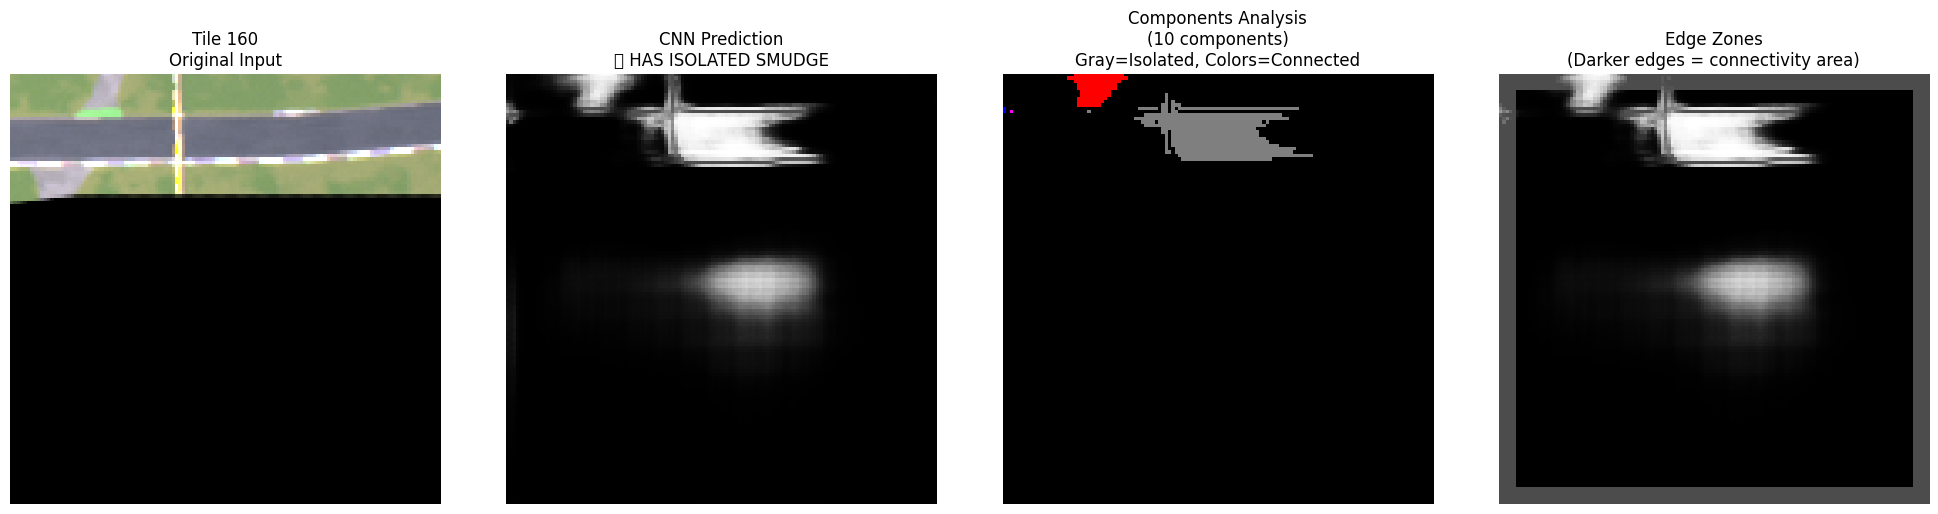

✅ Tile 161: Valid prediction - keeping
🔴 Tile 162: FALSE POSITIVE detected - filtering out


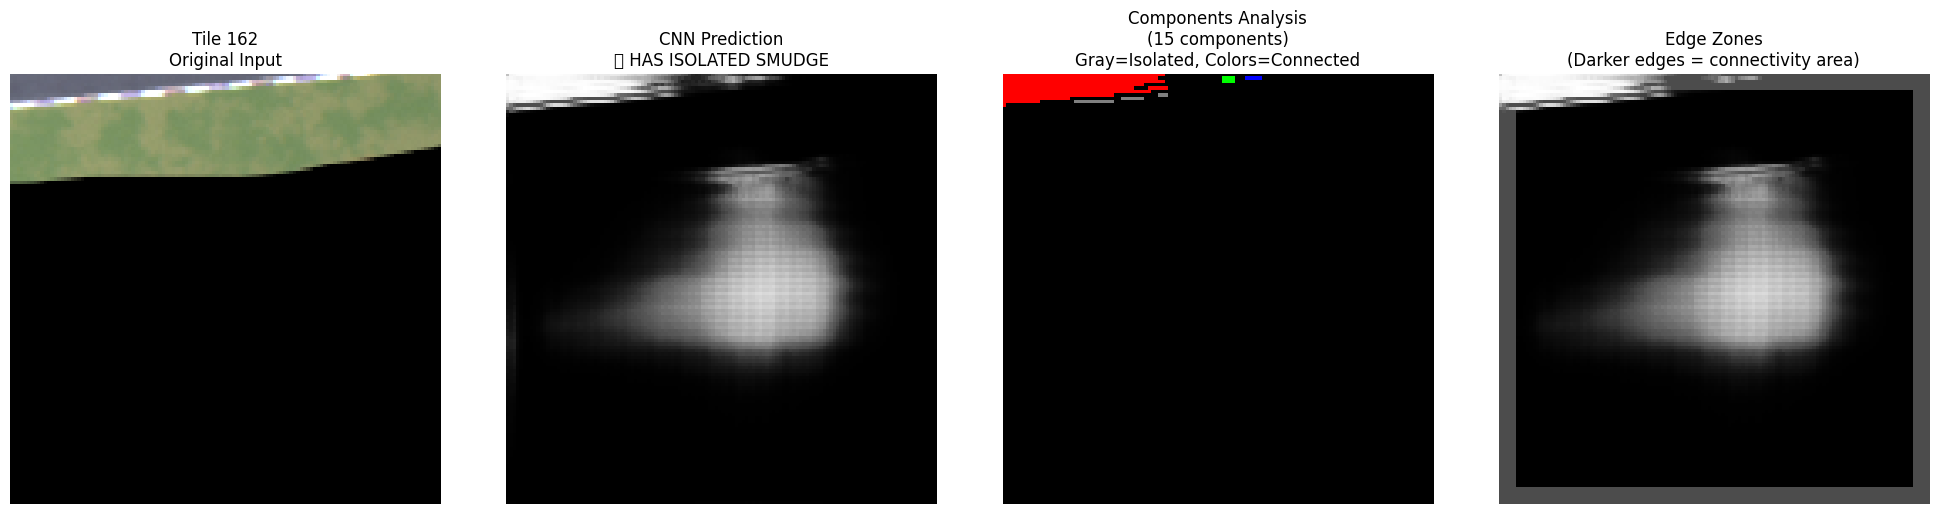

✅ Tile 163: Valid prediction - keeping
✅ Tile 164: Valid prediction - keeping
🔴 Tile 165: FALSE POSITIVE detected - filtering out


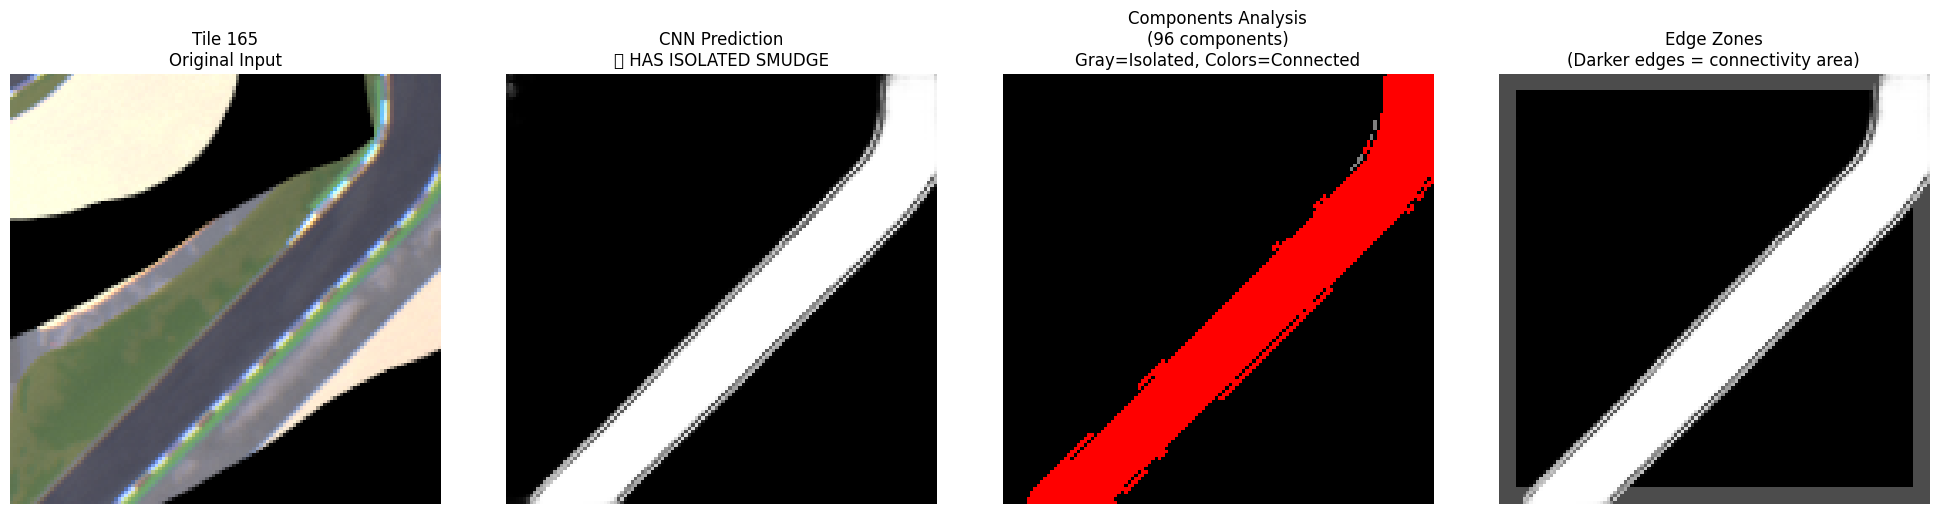

🔴 Tile 166: FALSE POSITIVE detected - filtering out


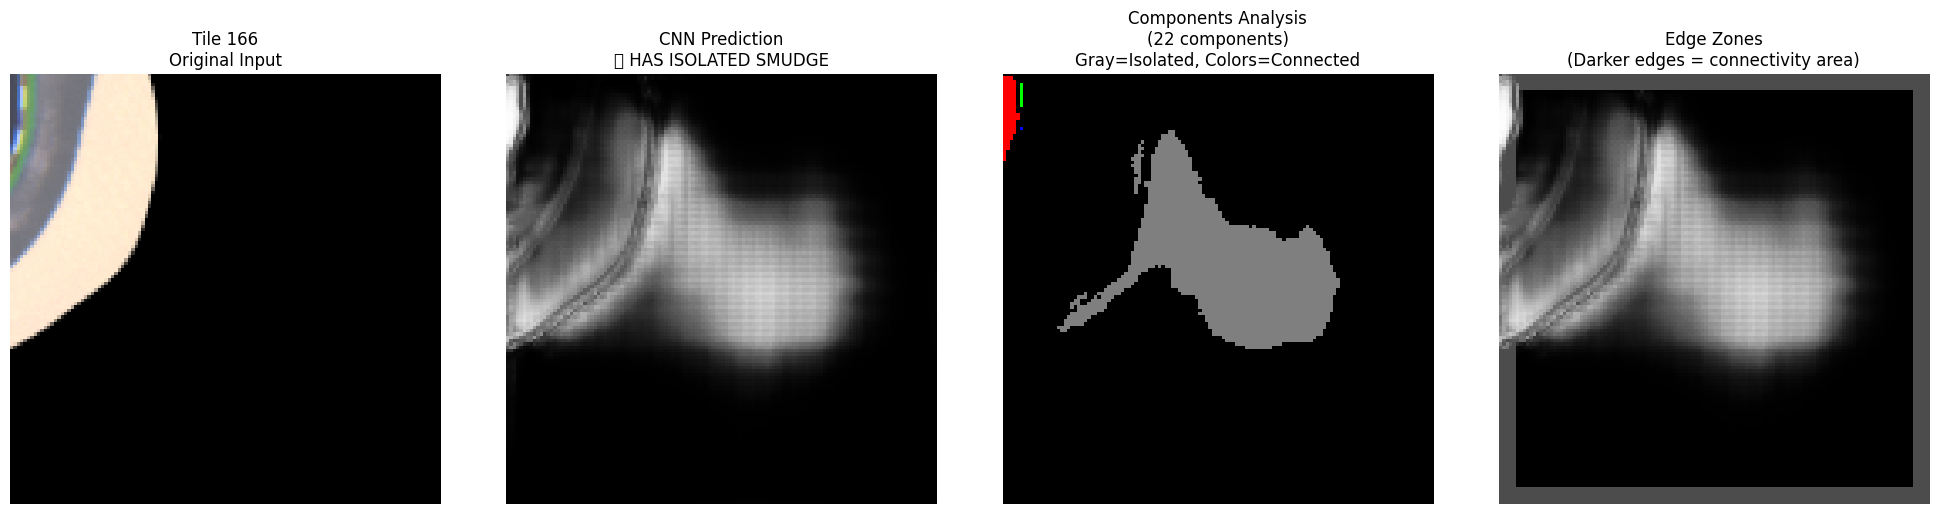

🔴 Tile 184: FALSE POSITIVE detected - filtering out


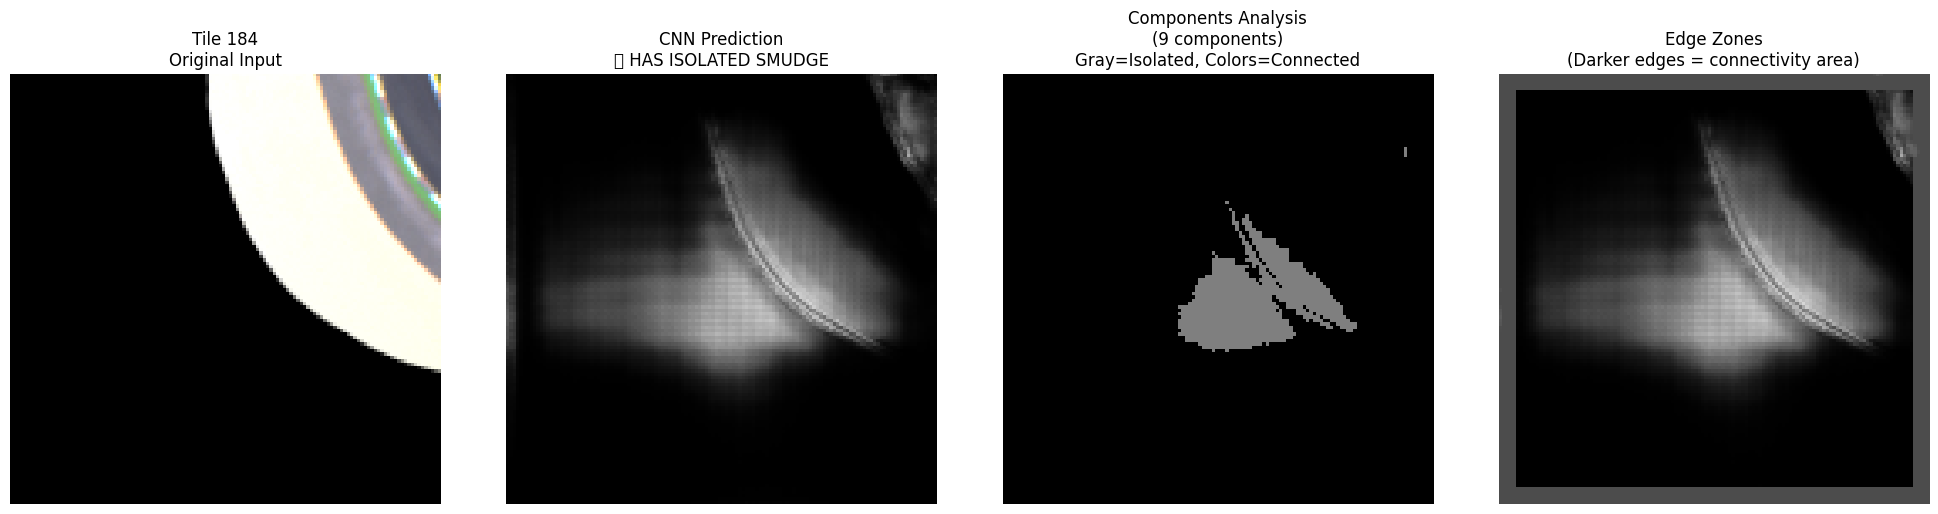

🔴 Tile 185: FALSE POSITIVE detected - filtering out


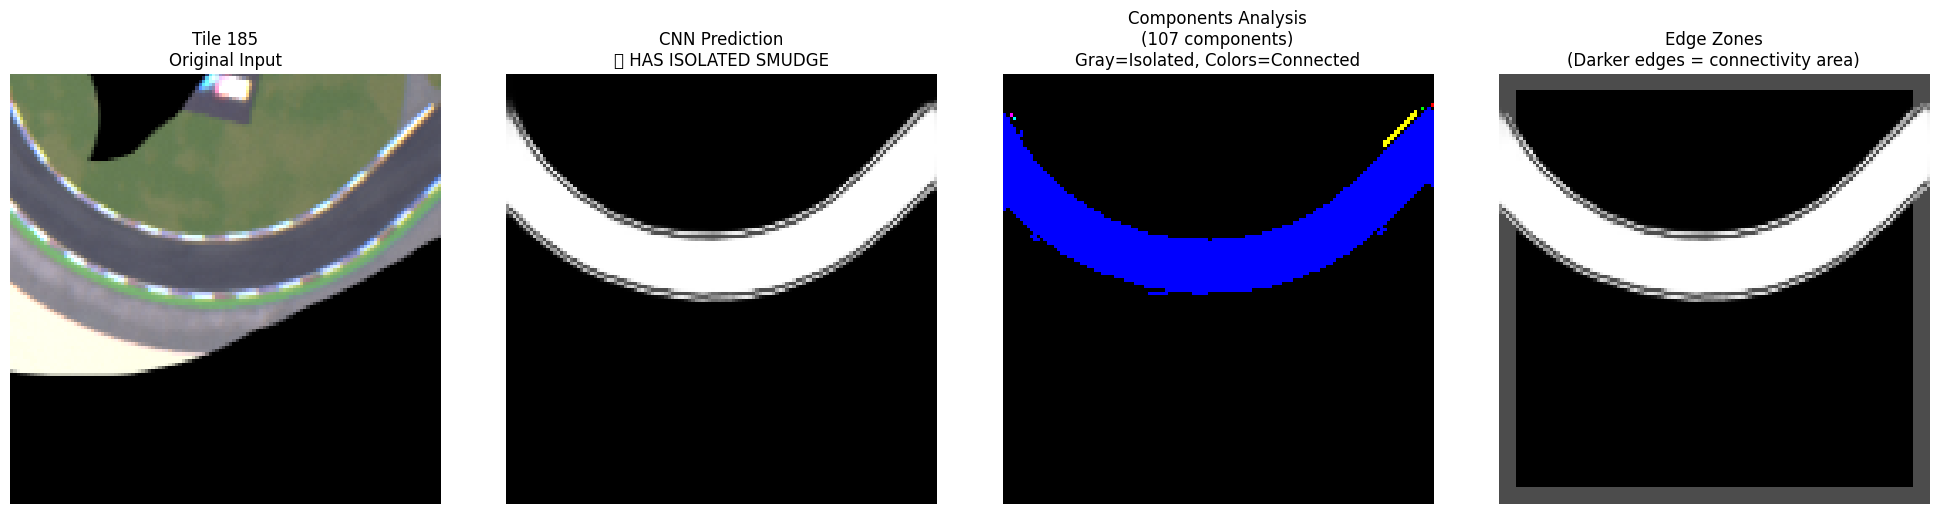


🔴 Filtered out 32 false positive smudges


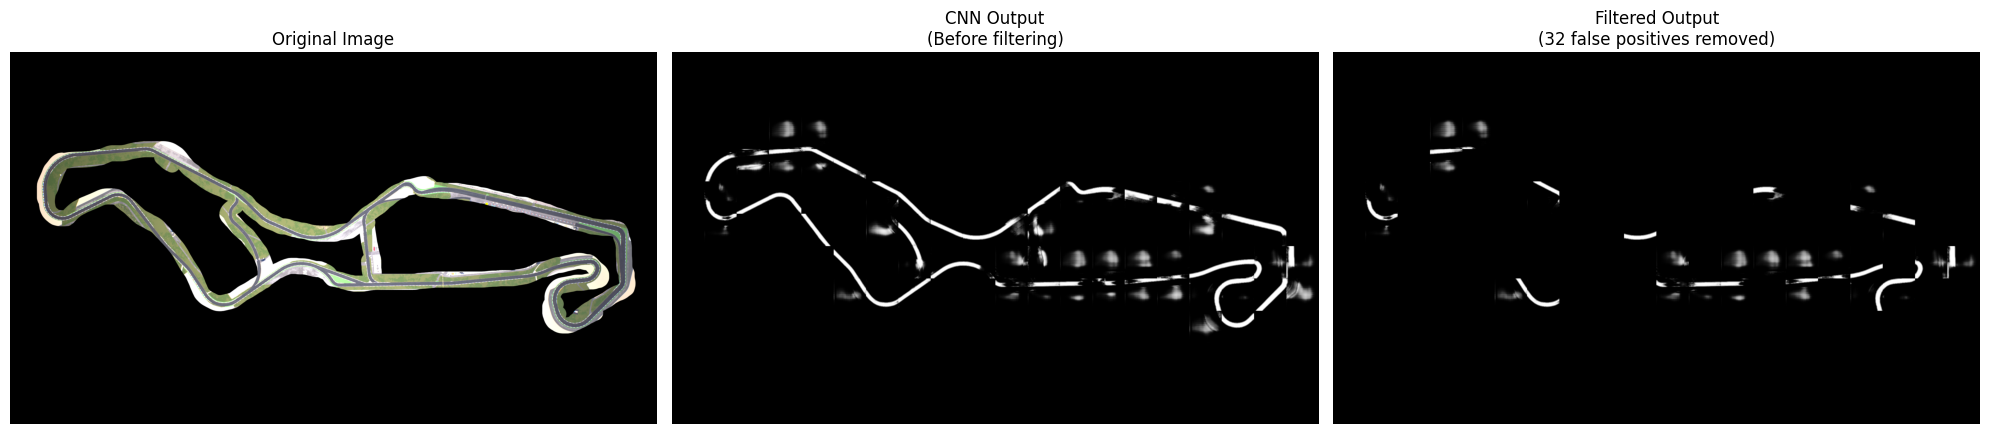

✅ Saved confidence-filtered result as 'predicted_mask_confidence_filtered.png'


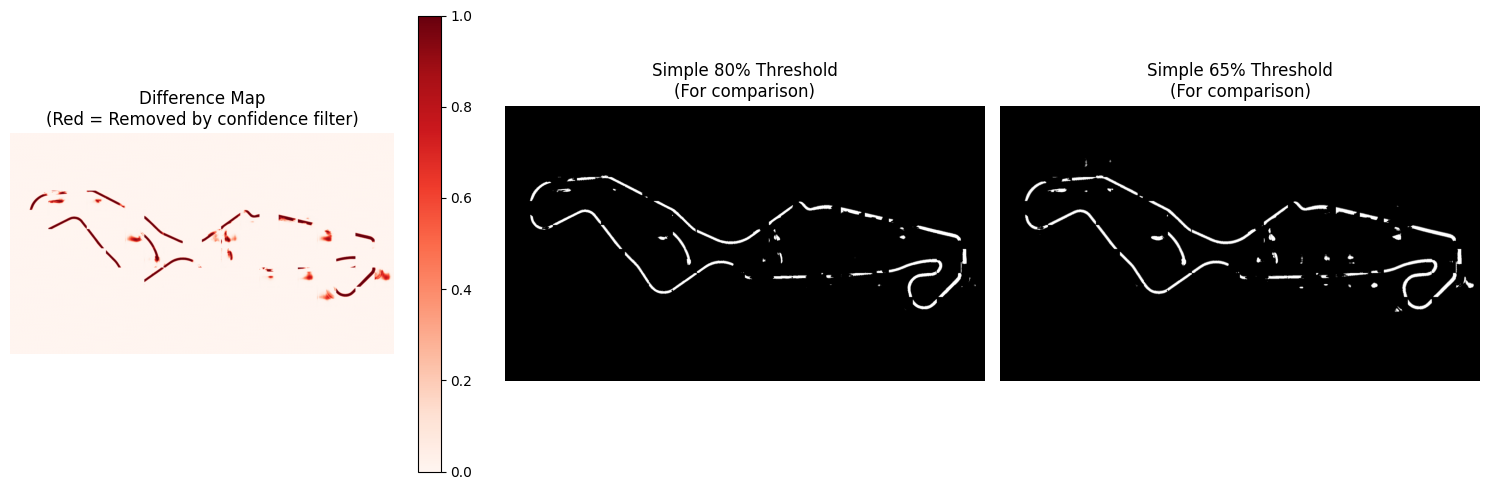


🎯 CONFIDENCE FILTERING COMPLETE!
💡 You can adjust these thresholds in the filter_low_confidence_predictions() function:
   - high_confidence_threshold: Currently 0.85 (85%)
   - medium_confidence_threshold: Currently 0.65 (65%)
   - low_confidence_threshold: Currently 0.45 (45%)


In [13]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model
model = load_model(MODEL_PATH, compile=True)

# Step 3: Your existing black tile filtering (keep this as is)
def should_ignore_tile(tile_array, black_threshold=0.85, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    black_mask = np.all(tile_array == black_color, axis=-1)
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

# Step 4: NEW - CNN Output False Positive Filter
def is_false_positive_smudge(prediction_mask, 
                           center_region_ratio=0.4, 
                           smudge_threshold=0.7,
                           min_smudge_size=50,
                           max_smudge_size=2000,
                           circularity_threshold=0.3):
    """
    Detect if a CNN prediction contains a false positive white smudge in the center.
    
    Args:
        prediction_mask: 2D numpy array (H, W) with values 0-1 from CNN output
        center_region_ratio: ratio of tile size to define center region (0.4 = 40% of tile size)
        smudge_threshold: threshold to consider pixels as "white" (0.7 = 70% confidence)
        min_smudge_size: minimum size of connected component to consider as smudge
        max_smudge_size: maximum size - larger might be actual walls
        circularity_threshold: how circular the smudge should be (0-1, lower = more circular)
    
    Returns:
        bool: True if false positive smudge detected
    """
    
    # Ensure we have a 2D mask
    if prediction_mask.ndim == 3:
        prediction_mask = np.squeeze(prediction_mask)
    
    height, width = prediction_mask.shape
    
    # Define center region
    center_h = int(height * center_region_ratio)
    center_w = int(width * center_region_ratio)
    start_h = (height - center_h) // 2
    start_w = (width - center_w) // 2
    end_h = start_h + center_h
    end_w = start_w + center_w
    
    center_region = prediction_mask[start_h:end_h, start_w:end_w]
    
    # Create binary mask of high-confidence predictions in center
    high_conf_mask = (center_region > smudge_threshold).astype(np.uint8)
    
    # Find connected components
    labeled_components, num_components = ndimage.label(high_conf_mask)
    
    if num_components == 0:
        return False
    
    # Analyze each connected component
    for component_id in range(1, num_components + 1):
        component_mask = (labeled_components == component_id)
        component_size = np.sum(component_mask)
        
        # Check size criteria
        if min_smudge_size <= component_size <= max_smudge_size:
            
            # Calculate circularity (optional - helps identify blob-like smudges)
            # Circularity = 4π * Area / Perimeter²
            try:
                # Find contours for perimeter calculation
                component_uint8 = component_mask.astype(np.uint8) * 255
                contours, _ = cv2.findContours(component_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                if len(contours) > 0:
                    perimeter = cv2.arcLength(contours[0], True)
                    if perimeter > 0:
                        circularity = 4 * np.pi * component_size / (perimeter * perimeter)
                        
                        # If it's roughly circular and in the center, it's likely a false positive
                        if circularity > circularity_threshold:
                            return True
                        
                        # Even if not perfectly circular, if it's isolated in center, suspicious
                        component_positions = np.where(component_mask)
                        center_y, center_x = center_region.shape[0] // 2, center_region.shape[1] // 2
                        
                        # Check if component is roughly centered
                        mean_y, mean_x = np.mean(component_positions[0]), np.mean(component_positions[1])
                        distance_from_center = np.sqrt((mean_y - center_y)**2 + (mean_x - center_x)**2)
                        
                        # If component is very centered, likely false positive
                        max_distance = min(center_h, center_w) * 0.3  # within 30% of center
                        if distance_from_center < max_distance:
                            return True
                            
            except:
                # If contour analysis fails, fall back to size-based detection
                component_positions = np.where(component_mask)
                center_y, center_x = center_region.shape[0] // 2, center_region.shape[1] // 2
                mean_y, mean_x = np.mean(component_positions[0]), np.mean(component_positions[1])
                distance_from_center = np.sqrt((mean_y - center_y)**2 + (mean_x - center_x)**2)
                max_distance = min(center_h, center_w) * 0.3
                
                if distance_from_center < max_distance:
                    return True
    
    return False

# Step 5: Enhanced visualization for edge connectivity analysis
def visualize_false_positive_analysis(original_tile, prediction_mask, is_false_pos, tile_index):
    """
    Visualize the edge connectivity analysis
    """
    plt.figure(figsize=(20, 5))
    
    # Original tile
    plt.subplot(1, 4, 1)
    plt.imshow(original_tile)
    plt.title(f'Tile {tile_index}\nOriginal Input')
    plt.axis('off')
    
    # CNN prediction
    plt.subplot(1, 4, 2)
    if prediction_mask.ndim == 3:
        pred_display = np.squeeze(prediction_mask)
    else:
        pred_display = prediction_mask
    plt.imshow(pred_display, cmap='gray', vmin=0, vmax=1)
    plt.title(f'CNN Prediction\n{"🔴 HAS ISOLATED SMUDGE" if is_false_pos else "✅ CONNECTED TO EDGES"}')
    plt.axis('off')
    
    # Edge connectivity analysis
    plt.subplot(1, 4, 3)
    binary_mask = (pred_display > 0.5).astype(np.uint8)
    labeled_components, num_components = ndimage.label(binary_mask)
    
    # Create colored visualization of components
    component_viz = np.zeros((*pred_display.shape, 3))
    colors = [[1,0,0], [0,1,0], [0,0,1], [1,1,0], [1,0,1], [0,1,1]]  # Different colors for components
    
    height, width = pred_display.shape
    edge_distance = 5
    
    for comp_id in range(1, min(num_components + 1, len(colors) + 1)):
        component_mask = (labeled_components == comp_id)
        color_idx = (comp_id - 1) % len(colors)
        
        # Check edge connectivity
        component_positions = np.where(component_mask)
        y_coords, x_coords = component_positions
        
        touches_edge = (np.any(y_coords <= edge_distance) or 
                       np.any(y_coords >= (height - edge_distance - 1)) or
                       np.any(x_coords <= edge_distance) or 
                       np.any(x_coords >= (width - edge_distance - 1)))
        
        # Use different colors for connected vs isolated
        if touches_edge:
            component_viz[component_mask] = colors[color_idx]  # Bright colors for connected
        else:
            component_viz[component_mask] = [0.5, 0.5, 0.5]  # Gray for isolated
    
    plt.imshow(component_viz)
    plt.title(f'Components Analysis\n({num_components} components)\nGray=Isolated, Colors=Connected')
    plt.axis('off')
    
    # Edge zones visualization
    plt.subplot(1, 4, 4)
    edge_viz = pred_display.copy()
    # Highlight edge zones
    edge_viz[:edge_distance, :] = np.maximum(edge_viz[:edge_distance, :], 0.3)  # Top
    edge_viz[-edge_distance:, :] = np.maximum(edge_viz[-edge_distance:, :], 0.3)  # Bottom
    edge_viz[:, :edge_distance] = np.maximum(edge_viz[:, :edge_distance], 0.3)  # Left  
    edge_viz[:, -edge_distance:] = np.maximum(edge_viz[:, -edge_distance:], 0.3)  # Right
    
    plt.imshow(edge_viz, cmap='gray', vmin=0, vmax=1)
    plt.title('Edge Zones\n(Darker edges = connectivity area)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Step 6: Updated tile processing function
def tile_image(image, tile_size=(128, 128), black_threshold=0.85):
    """
    Splits image into tiles and filters out black tiles
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Main processing pipeline
print("Loading and processing image...")
original_image = Image.open(IMAGE_PATH).convert("RGB")
tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128))

print(f"Total tiles: {len(tile_coordinates)}")
print(f"Processing {len(tiles)} tiles with CNN")
print(f"Ignored {sum(ignore_mask)} black tiles")

# Step 7: Process with CNN and filter false positives
def preprocess_tile(tile):
    return tile.astype(np.float32) / 255.0

predictions = []
filtered_predictions = []
false_positive_count = 0
processed_tile_index = 0

print(f"\n=== CNN PROCESSING AND FALSE POSITIVE FILTERING ===")

for tile_position_index, ignore in enumerate(ignore_mask):
    if ignore:
        # Blank prediction for ignored tiles
        blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
        predictions.append(blank_prediction)
        filtered_predictions.append(blank_prediction)
    else:
        # Process with CNN
        original_tile = tiles[processed_tile_index]
        processed_tile = preprocess_tile(original_tile)
        cnn_prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)[0]
        predictions.append(cnn_prediction)
        
        # Check for false positive smudge
        is_false_pos = is_false_positive_smudge(cnn_prediction)
        
        if is_false_pos:
            print(f"🔴 Tile {tile_position_index}: FALSE POSITIVE detected - filtering out")
            # Replace with blank prediction
            filtered_prediction = np.zeros_like(cnn_prediction)
            filtered_predictions.append(filtered_prediction)
            false_positive_count += 1
            
            # Show the analysis
            visualize_false_positive_analysis(original_tile, cnn_prediction, True, tile_position_index)
        else:
            print(f"✅ Tile {tile_position_index}: Valid prediction - keeping")
            filtered_predictions.append(cnn_prediction)
        
        processed_tile_index += 1

print(f"\n🔴 Filtered out {false_positive_count} false positive smudges")

# Step 8: Stitch both original and filtered results
def stitch_tiles(tile_predictions, original_size, tile_size=(128, 128)):
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)
    
    tile_idx = 0
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            prediction = tile_predictions[tile_idx]
            
            if prediction.ndim == 3:
                mask = prediction[:, :, 0]
            else:
                mask = prediction
            
            h = min(tile_size[1], height - y)
            w = min(tile_size[0], width - x)
            stitched[y:y+h, x:x+w] = mask[:h, :w]
            tile_idx += 1
    
    return stitched

original_size = original_image.size
original_stitched = stitch_tiles(predictions, original_size)
filtered_stitched = stitch_tiles(filtered_predictions, original_size)

# Step 9: Compare results
plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(original_stitched, cmap='gray', vmin=0, vmax=1)
plt.title('CNN Output\n(Before filtering)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(filtered_stitched, cmap='gray', vmin=0, vmax=1)
plt.title(f'Filtered Output\n({false_positive_count} false positives removed)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save results
filtered_mask_image = (filtered_stitched * 255).astype(np.uint8)
Image.fromarray(filtered_mask_image).save('predicted_mask_confidence_filtered.png')
print("✅ Saved confidence-filtered result as 'predicted_mask_confidence_filtered.png'")

# Optional: Show difference and create adjustable threshold version
difference = original_stitched - filtered_stitched
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(difference, cmap='Reds', vmin=0, vmax=1)
plt.title('Difference Map\n(Red = Removed by confidence filter)')
plt.colorbar()
plt.axis('off')

# Show simple threshold comparison
plt.subplot(1, 3, 2)
simple_threshold = (original_stitched > 0.8).astype(np.float32)
plt.imshow(simple_threshold, cmap='gray', vmin=0, vmax=1)
plt.title('Simple 80% Threshold\n(For comparison)')
plt.axis('off')

# Show medium threshold
plt.subplot(1, 3, 3)
medium_threshold = (original_stitched > 0.65).astype(np.float32)
plt.imshow(medium_threshold, cmap='gray', vmin=0, vmax=1)
plt.title('Simple 65% Threshold\n(For comparison)')
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n🎯 CONFIDENCE FILTERING COMPLETE!")
print("💡 You can adjust these thresholds in the filter_low_confidence_predictions() function:")
print("   - high_confidence_threshold: Currently 0.85 (85%)")  
print("   - medium_confidence_threshold: Currently 0.65 (65%)")
print("   - low_confidence_threshold: Currently 0.45 (45%)")

Starting overlapping tile processing...
Processing image of size: (2561, 1472)
Pass 1: Regular grid...
Pass 1 - Total tiles: 240, Processed: 58, Ignored: 182
Pass 2: Offset grid...
Pass 2 - Total tiles: 220, Processed: 57, Ignored: 163
Merging results...


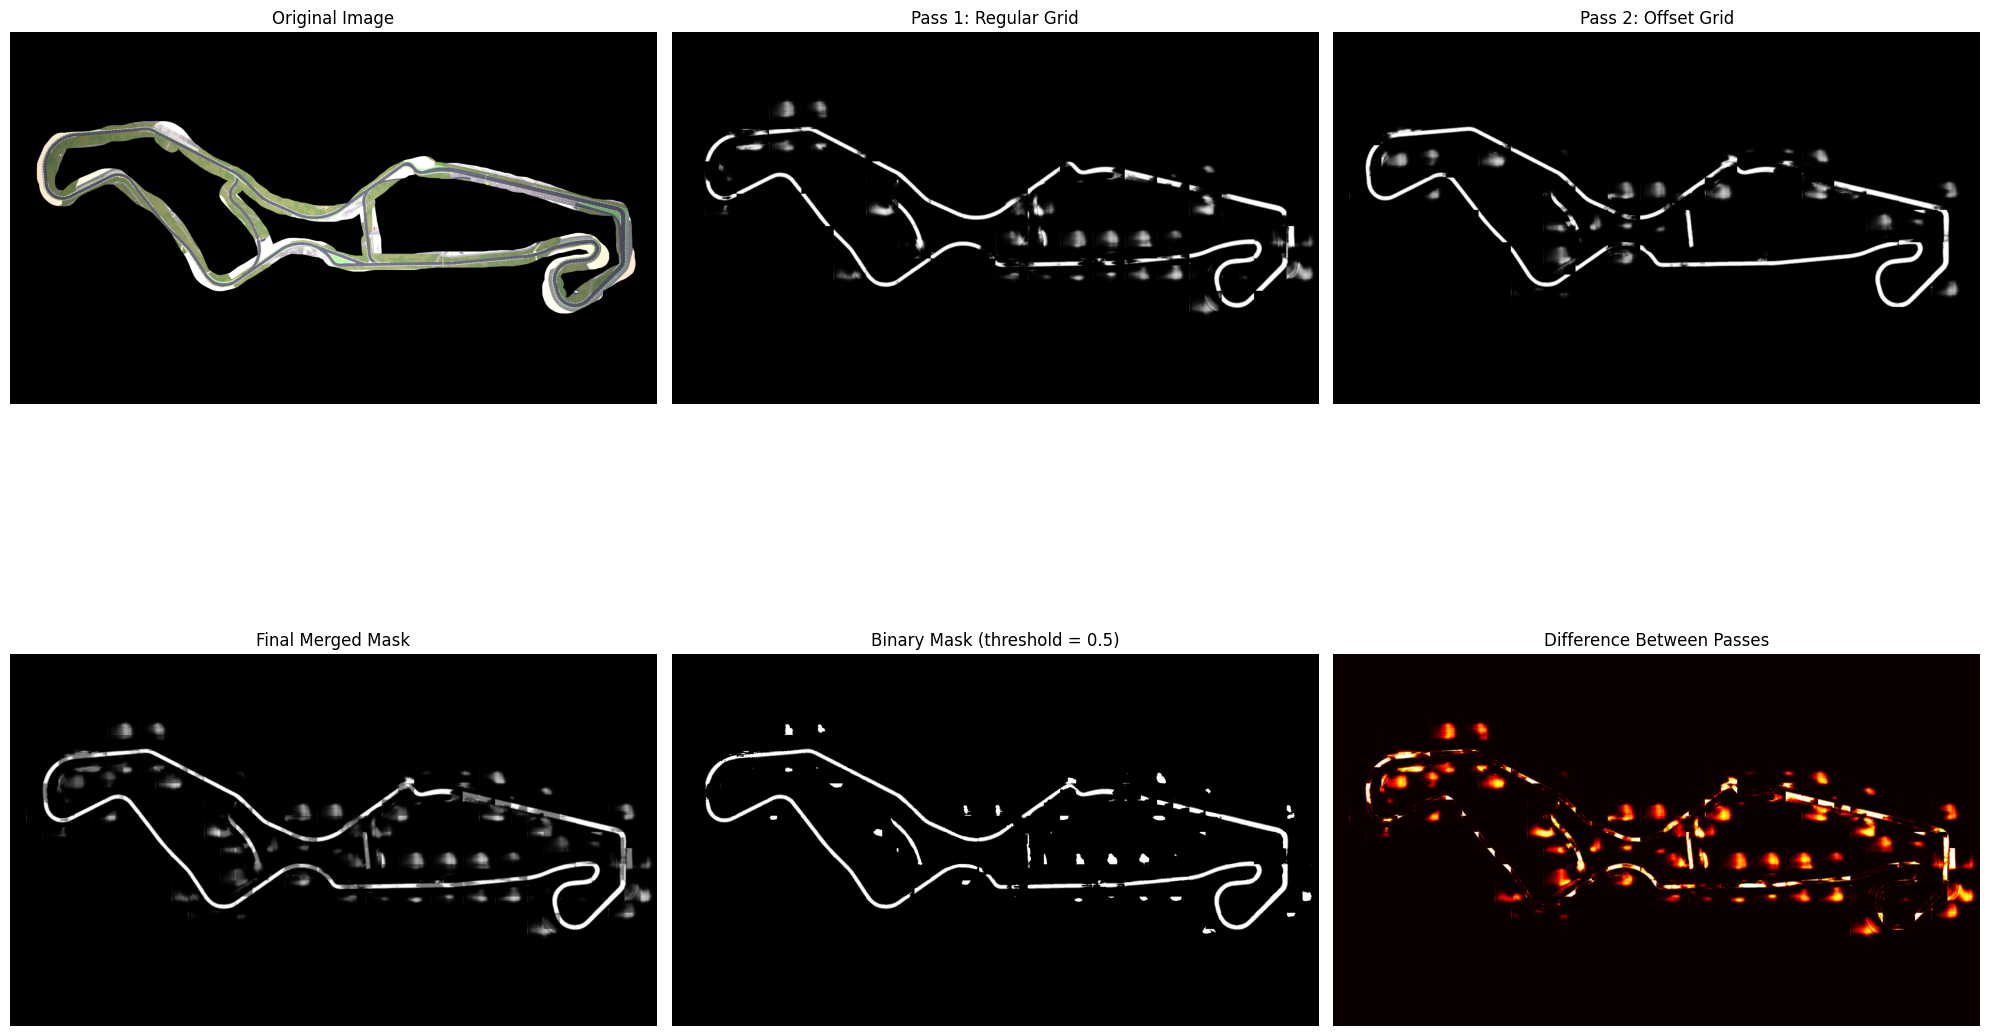

Saving results...
Processing complete! Saved 'predicted_mask_overlapped.png' and 'binary_mask_overlapped.png'

Coverage Analysis:
Pass 1 coverage: 4.76%
Pass 2 coverage: 4.54%
Final merged coverage: 6.45%


In [11]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)

# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    black_mask = np.all(tile_array == black_color, axis=-1)
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

# Step 4: Modified tile_image function with offset support
def tile_image_with_offset(image, tile_size=(128, 128), offset=(0, 0), black_threshold=0.85):
    """
    Splits an image into tiles with a given offset, filtering out predominantly black tiles.
    
    Args:
        image: PIL Image or numpy array
        tile_size: (width, height) of each tile
        offset: (x_offset, y_offset) starting position
        black_threshold: percentage of black pixels to ignore tile
    
    Returns:
        tiles, tile_coordinates, tile_ignore_mask
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    # Start from offset and go by tile_size steps
    for y in range(offset[1], height, tile_size[1]):
        for x in range(offset[0], width, tile_size[0]):
            # Crop tile - make sure we don't go beyond image bounds
            x_end = min(x + tile_size[0], width)
            y_end = min(y + tile_size[1], height)
            
            # Skip if tile would be too small
            if (x_end - x) < tile_size[0] // 2 or (y_end - y) < tile_size[1] // 2:
                continue
            
            tile = image.crop((x, y, x_end, y_end))

            # If tile is smaller than expected, pad it
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            
            # Check if tile should be ignored
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Step 5: Preprocessing function
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    tile = tile.astype(np.float32) / 255.0
    return tile

# Step 6: Predict on tiles
def predict_on_tiles(tiles, ignore_mask, model):
    """
    Run prediction on tiles, handling ignored tiles
    """
    predictions = []
    tile_index = 0

    for i, ignore in enumerate(ignore_mask):
        if ignore:
            # Create a blank prediction for ignored tiles
            blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
            predictions.append(blank_prediction)
        else:
            # Process and predict on non-ignored tiles
            processed_tile = preprocess_tile(tiles[tile_index])
            prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)
            predictions.append(prediction[0])  # Remove batch dimension
            tile_index += 1
    
    return predictions

# Step 7: Improved stitching with weight accumulation
def stitch_tiles_with_weights(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches tiles back with proper weight accumulation for overlapping areas.
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)
    weight_map = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Add prediction values and weights
        stitched[y:y+h, x:x+w] += mask[:h, :w]
        weight_map[y:y+h, x:x+w] += 1.0

    # Avoid division by zero
    weight_map[weight_map == 0] = 1.0
    
    # Average overlapping predictions
    stitched = stitched / weight_map
    
    return stitched

# Step 8: Main processing function
def process_image_with_overlapping_tiles(image_path, model, tile_size=(128, 128)):
    """
    Process image with two overlapping tile passes and merge results.
    """
    # Load original image
    original_image = Image.open(image_path).convert("RGB")
    original_size = original_image.size
    
    print(f"Processing image of size: {original_size}")
    
    # PASS 1: Regular grid (offset 0, 0)
    print("Pass 1: Regular grid...")
    tiles1, coords1, ignore1 = tile_image_with_offset(original_image, tile_size, offset=(0, 0))
    predictions1 = predict_on_tiles(tiles1, ignore1, model)
    mask1 = stitch_tiles_with_weights(predictions1, original_size, coords1, tile_size)
    
    print(f"Pass 1 - Total tiles: {len(coords1)}, Processed: {len(tiles1)}, Ignored: {sum(ignore1)}")
    
    # PASS 2: Offset grid (offset tile_size//2, tile_size//2)
    print("Pass 2: Offset grid...")
    offset = (tile_size[0]//2, tile_size[1]//2)
    tiles2, coords2, ignore2 = tile_image_with_offset(original_image, tile_size, offset=offset)
    predictions2 = predict_on_tiles(tiles2, ignore2, model)
    mask2 = stitch_tiles_with_weights(predictions2, original_size, coords2, tile_size)
    
    print(f"Pass 2 - Total tiles: {len(coords2)}, Processed: {len(tiles2)}, Ignored: {sum(ignore2)}")
    
    # MERGE: Average the two masks
    print("Merging results...")
    # Create weight maps for each pass
    weight1 = np.ones_like(mask1)
    weight2 = np.ones_like(mask2)
    
    # Set weights to 0 where masks are 0 (areas that were ignored or not covered)
    weight1[mask1 == 0] = 0
    weight2[mask2 == 0] = 0
    
    # Weighted average
    total_weight = weight1 + weight2
    total_weight[total_weight == 0] = 1  # Avoid division by zero
    
    final_mask = (mask1 * weight1 + mask2 * weight2) / total_weight
    
    return original_image, mask1, mask2, final_mask

# Step 9: Run the processing
print("Starting overlapping tile processing...")
original_image, mask1, mask2, final_mask = process_image_with_overlapping_tiles(IMAGE_PATH, model)

# Step 10: Visualize results
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(mask1, cmap='gray', vmin=0, vmax=1)
plt.title('Pass 1: Regular Grid')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(mask2, cmap='gray', vmin=0, vmax=1)
plt.title('Pass 2: Offset Grid')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(final_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Final Merged Mask')
plt.axis('off')

# Binary version
binary_mask = (final_mask > 0.5).astype(np.uint8)
plt.subplot(2, 3, 5)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')

# Difference visualization
diff_mask = np.abs(mask1 - mask2)
plt.subplot(2, 3, 6)
plt.imshow(diff_mask, cmap='hot', vmin=0, vmax=1)
plt.title('Difference Between Passes')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 11: Save results
print("Saving results...")
final_mask_image = (final_mask * 255).astype(np.uint8)
Image.fromarray(final_mask_image).save('predicted_mask_overlapped.png')

binary_mask_image = (binary_mask * 255).astype(np.uint8)
Image.fromarray(binary_mask_image).save('binary_mask_overlapped.png')

print("Processing complete! Saved 'predicted_mask_overlapped.png' and 'binary_mask_overlapped.png'")

# Optional: Compare coverage
def calculate_coverage(mask):
    """Calculate percentage of non-zero pixels"""
    return np.sum(mask > 0.1) / mask.size * 100

coverage1 = calculate_coverage(mask1)
coverage2 = calculate_coverage(mask2)
coverage_final = calculate_coverage(final_mask)

print(f"\nCoverage Analysis:")
print(f"Pass 1 coverage: {coverage1:.2f}%")
print(f"Pass 2 coverage: {coverage2:.2f}%") 
print(f"Final merged coverage: {coverage_final:.2f}%")

Starting enhanced gap-filling processing...
Processing image of size: (2561, 1472)
Pass 1: Regular grid...
Pass 2: Offset grid...
Pass 3: Quarter offset grid...
Merging three passes...
Applying gap filling techniques...


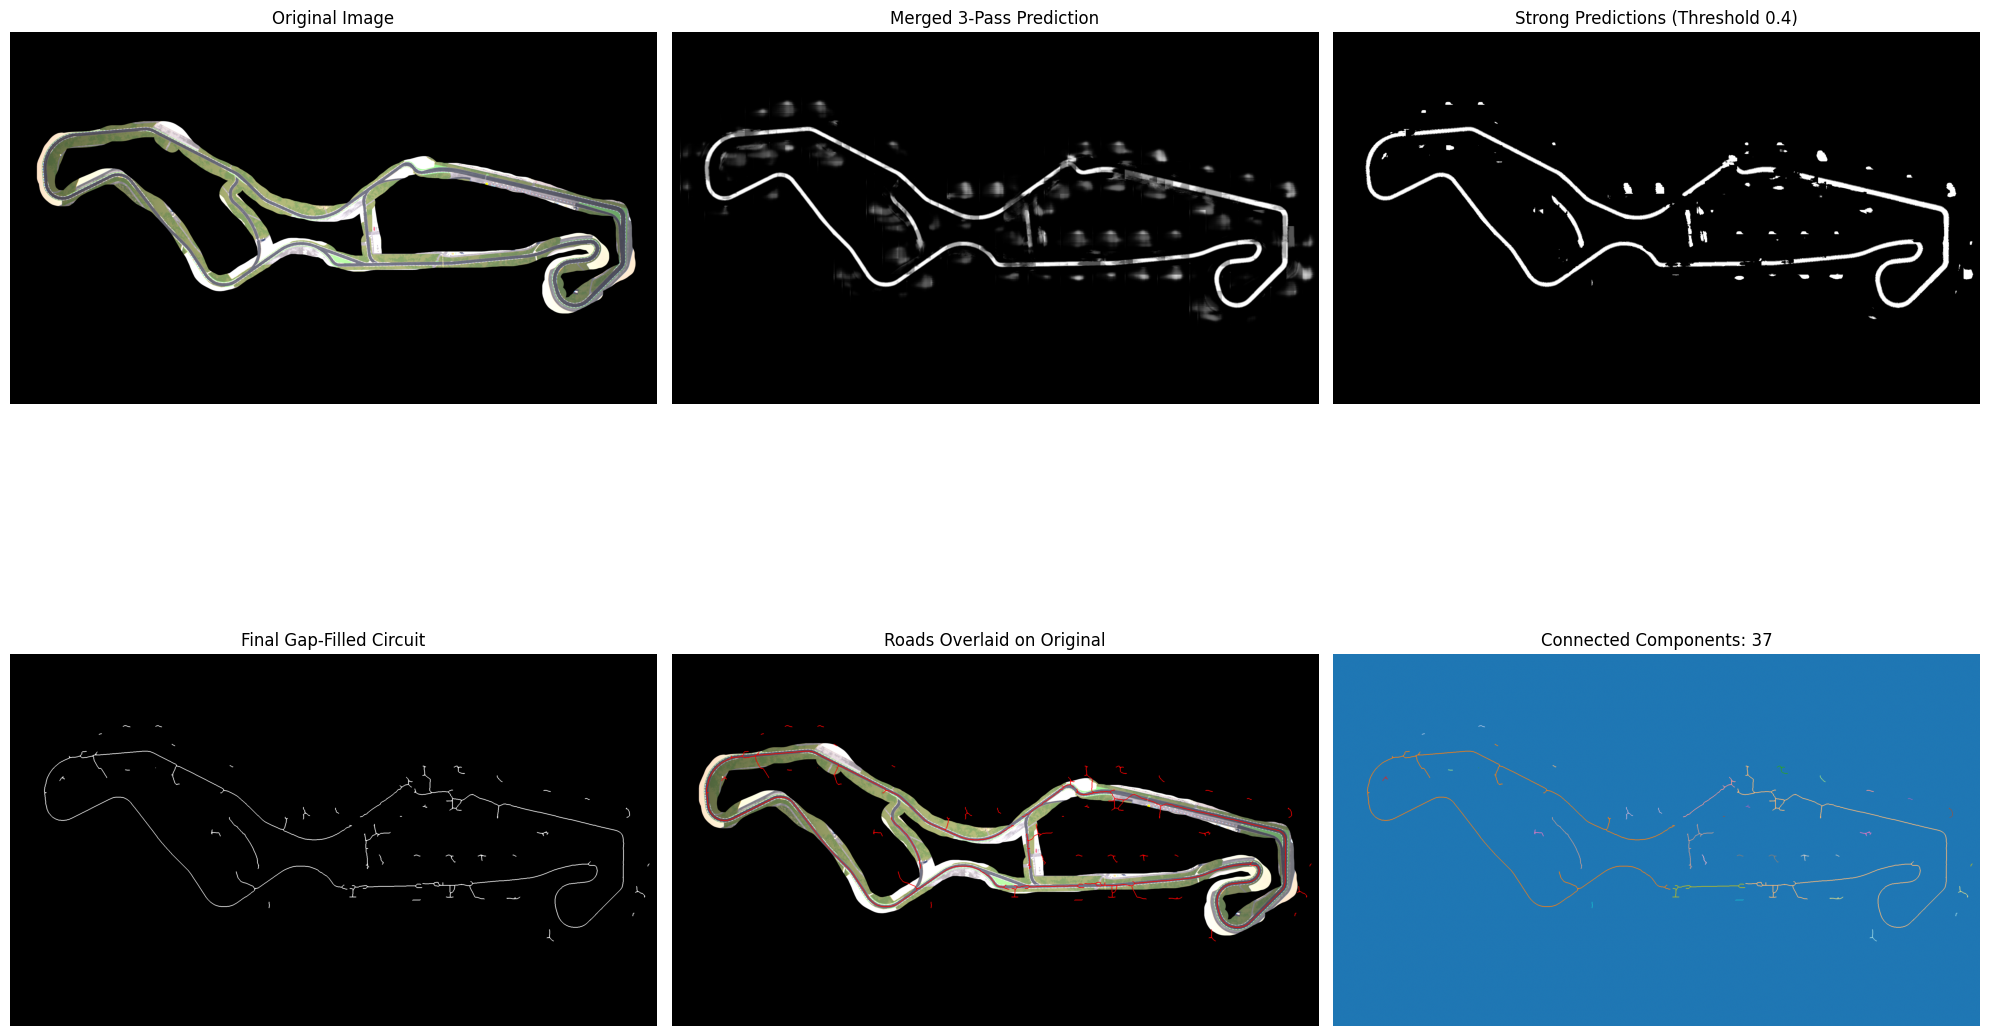

Saving results...

Connectivity Analysis:
Number of connected components: 37
Total road pixels: 24794
Circuit completeness: FRAGMENTED

Cleaning up - keeping only the largest component...


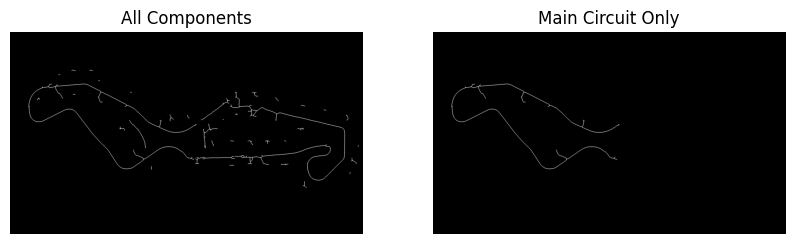

Saved 'main_circuit_only.png'
Processing complete!


In [12]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage
from skimage import morphology, measure
from skimage.morphology import skeletonize, dilation, erosion

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)

# [Include all previous functions from the overlapping tiles code]
# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """Check if a tile should be ignored based on black color percentage."""
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    black_mask = np.all(tile_array == black_color, axis=-1)
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

def tile_image_with_offset(image, tile_size=(128, 128), offset=(0, 0), black_threshold=0.85):
    """Splits an image into tiles with a given offset, filtering out predominantly black tiles."""
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(offset[1], height, tile_size[1]):
        for x in range(offset[0], width, tile_size[0]):
            x_end = min(x + tile_size[0], width)
            y_end = min(y + tile_size[1], height)
            
            if (x_end - x) < tile_size[0] // 2 or (y_end - y) < tile_size[1] // 2:
                continue
            
            tile = image.crop((x, y, x_end, y_end))

            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    tile = tile.astype(np.float32) / 255.0
    return tile

def predict_on_tiles(tiles, ignore_mask, model):
    """Run prediction on tiles, handling ignored tiles"""
    predictions = []
    tile_index = 0

    for i, ignore in enumerate(ignore_mask):
        if ignore:
            blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
            predictions.append(blank_prediction)
        else:
            processed_tile = preprocess_tile(tiles[tile_index])
            prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)
            predictions.append(prediction[0])
            tile_index += 1
    
    return predictions

def stitch_tiles_with_weights(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """Stitches tiles back with proper weight accumulation for overlapping areas."""
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)
    weight_map = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        if prediction.ndim == 3:
            mask = prediction[:, :, 0]
        else:
            mask = prediction
        
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        stitched[y:y+h, x:x+w] += mask[:h, :w]
        weight_map[y:y+h, x:x+w] += 1.0

    weight_map[weight_map == 0] = 1.0
    stitched = stitched / weight_map
    
    return stitched

# Step 4: NEW GAP-FILLING FUNCTIONS

def adaptive_threshold_mask(mask, base_threshold=0.5, low_threshold=0.2):
    """
    Create binary mask with adaptive thresholding to catch weak predictions.
    """
    # Strong predictions
    strong_mask = mask > base_threshold
    
    # Weak predictions that might fill gaps
    weak_mask = (mask > low_threshold) & (mask <= base_threshold)
    
    return strong_mask.astype(np.uint8), weak_mask.astype(np.uint8)

def fill_small_gaps(binary_mask, max_gap_size=10):
    """
    Fill small gaps in the binary mask using morphological operations.
    """
    # Use closing to fill small gaps
    kernel = np.ones((max_gap_size, max_gap_size), np.uint8)
    closed = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    return closed

def connect_nearby_components(binary_mask, connection_distance=15):
    """
    Connect nearby road components that are likely part of the same circuit.
    """
    # Find connected components
    labeled = measure.label(binary_mask)
    regions = measure.regionprops(labeled)
    
    result = binary_mask.copy()
    
    # For each pair of regions, check if they should be connected
    for i, region1 in enumerate(regions):
        for j, region2 in enumerate(regions[i+1:], i+1):
            # Get centroids
            y1, x1 = region1.centroid
            y2, x2 = region2.centroid
            
            # Calculate distance
            distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            
            # If regions are close enough, draw connecting line
            if distance < connection_distance:
                # Draw line between centroids
                rr, cc = draw_line_between_points(
                    int(y1), int(x1), int(y2), int(x2), result.shape
                )
                result[rr, cc] = 1
    
    return result

def draw_line_between_points(y1, x1, y2, x2, shape):
    """Draw a line between two points, returning coordinates."""
    from skimage.draw import line
    
    # Ensure coordinates are within bounds
    y1, x1 = max(0, min(y1, shape[0]-1)), max(0, min(x1, shape[1]-1))
    y2, x2 = max(0, min(y2, shape[0]-1)), max(0, min(x2, shape[1]-1))
    
    return line(y1, x1, y2, x2)

def skeletonize_and_dilate(binary_mask, final_width=3):
    """
    Create a skeleton of the road network and then dilate to desired width.
    """
    # Skeletonize to get centerline
    skeleton = skeletonize(binary_mask > 0)
    
    # Dilate skeleton to create road of desired width
    if final_width > 1:
        kernel = morphology.disk(final_width // 2)
        result = dilation(skeleton, kernel)
    else:
        result = skeleton
    
    return result.astype(np.uint8)

def guided_gap_filling(mask, weak_mask, strong_mask):
    """
    Use weak predictions to guide gap filling between strong predictions.
    """
    # Start with strong predictions
    result = strong_mask.copy()
    
    # Find endpoints of strong predictions (places where gaps might be)
    skeleton_strong = skeletonize(strong_mask > 0)
    
    # Use distance transform to find potential connection paths through weak areas
    # Distance transform on inverted weak mask gives us preferred paths
    weak_distance = ndimage.distance_transform_edt(weak_mask == 0)
    
    # Find connected components in strong mask
    labeled_strong = measure.label(strong_mask)
    regions = measure.regionprops(labeled_strong)
    
    # Try to connect components through weak prediction areas
    for i, region1 in enumerate(regions):
        for j, region2 in enumerate(regions[i+1:], i+1):
            y1, x1 = region1.centroid
            y2, x2 = region2.centroid
            
            # Check if there's a path through weak predictions
            path_mask = create_path_between_points(
                int(y1), int(x1), int(y2), int(x2), weak_mask, mask.shape
            )
            
            # Add path to result if it goes through weak prediction areas
            result = np.logical_or(result, path_mask).astype(np.uint8)
    
    return result

def create_path_between_points(y1, x1, y2, x2, weak_mask, shape, max_distance=50):
    """
    Create a path between two points, preferring areas with weak predictions.
    """
    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    if distance > max_distance:
        return np.zeros(shape, dtype=np.uint8)
    
    # Simple straight line path
    rr, cc = draw_line_between_points(y1, x1, y2, x2, shape)
    
    # Check if path goes through weak prediction areas
    path_mask = np.zeros(shape, dtype=np.uint8)
    
    # Only add path if it intersects with weak predictions
    if np.any(weak_mask[rr, cc]):
        # Make the path slightly thicker
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                rr_thick = np.clip(rr + dy, 0, shape[0]-1)
                cc_thick = np.clip(cc + dx, 0, shape[1]-1)
                path_mask[rr_thick, cc_thick] = 1
    
    return path_mask

def process_image_with_gap_filling(image_path, model, tile_size=(128, 128)):
    """
    Process image with overlapping tiles and advanced gap filling.
    """
    # Load original image
    original_image = Image.open(image_path).convert("RGB")
    original_size = original_image.size
    
    print(f"Processing image of size: {original_size}")
    
    # PASS 1: Regular grid
    print("Pass 1: Regular grid...")
    tiles1, coords1, ignore1 = tile_image_with_offset(original_image, tile_size, offset=(0, 0))
    predictions1 = predict_on_tiles(tiles1, ignore1, model)
    mask1 = stitch_tiles_with_weights(predictions1, original_size, coords1, tile_size)
    
    # PASS 2: Offset grid
    print("Pass 2: Offset grid...")
    offset = (tile_size[0]//2, tile_size[1]//2)
    tiles2, coords2, ignore2 = tile_image_with_offset(original_image, tile_size, offset=offset)
    predictions2 = predict_on_tiles(tiles2, ignore2, model)
    mask2 = stitch_tiles_with_weights(predictions2, original_size, coords2, tile_size)
    
    # PASS 3: Quarter offset for even better coverage
    print("Pass 3: Quarter offset grid...")
    offset3 = (tile_size[0]//4, tile_size[1]//4)
    tiles3, coords3, ignore3 = tile_image_with_offset(original_image, tile_size, offset=offset3)
    predictions3 = predict_on_tiles(tiles3, ignore3, model)
    mask3 = stitch_tiles_with_weights(predictions3, original_size, coords3, tile_size)
    
    # Merge all three passes
    print("Merging three passes...")
    weight1 = (mask1 > 0).astype(np.float32)
    weight2 = (mask2 > 0).astype(np.float32) 
    weight3 = (mask3 > 0).astype(np.float32)
    
    total_weight = weight1 + weight2 + weight3
    total_weight[total_weight == 0] = 1
    
    merged_mask = (mask1 * weight1 + mask2 * weight2 + mask3 * weight3) / total_weight
    
    # Advanced gap filling
    print("Applying gap filling techniques...")
    
    # 1. Adaptive thresholding
    strong_mask, weak_mask = adaptive_threshold_mask(merged_mask, 
                                                    base_threshold=0.4,  # Lower threshold
                                                    low_threshold=0.1)   # Very low threshold
    
    # 2. Guided gap filling using weak predictions
    connected_mask = guided_gap_filling(merged_mask, weak_mask, strong_mask)
    
    # 3. Fill small gaps
    gap_filled = fill_small_gaps(connected_mask, max_gap_size=8)
    
    # 4. Connect nearby components
    final_connected = connect_nearby_components(gap_filled, connection_distance=20)
    
    # 5. Final cleanup - skeletonize and redilate for consistent width
    # final_mask = skeletonize_and_dilate(final_connected, final_width=3)
     final_mask = final_connected.astype(np.uint8)
    
    # 6. One more gap filling pass after skeletonization
    final_mask = fill_small_gaps(final_mask, max_gap_size=5)
    
    return original_image, merged_mask, strong_mask, final_mask

# Step 5: Run the enhanced processing
print("Starting enhanced gap-filling processing...")
original_image, merged_mask, strong_mask, final_mask = process_image_with_gap_filling(IMAGE_PATH, model)

# Step 6: Visualize results
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(merged_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Merged 3-Pass Prediction')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(strong_mask, cmap='gray')
plt.title('Strong Predictions (Threshold 0.4)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(final_mask, cmap='gray')
plt.title('Final Gap-Filled Circuit')
plt.axis('off')

# Create overlay visualization
plt.subplot(2, 3, 5)
overlay = np.array(original_image)
road_pixels = final_mask > 0
overlay[road_pixels] = [255, 0, 0]  # Red roads
plt.imshow(overlay)
plt.title('Roads Overlaid on Original')
plt.axis('off')

# Show connectivity analysis
plt.subplot(2, 3, 6)
labeled_final = measure.label(final_mask)
plt.imshow(labeled_final, cmap='tab20')
plt.title(f'Connected Components: {labeled_final.max()}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 7: Save results
print("Saving results...")
final_mask_image = (final_mask * 255).astype(np.uint8)
Image.fromarray(final_mask_image).save('circuit_complete.png')

# Analysis
print(f"\nConnectivity Analysis:")
print(f"Number of connected components: {measure.label(final_mask).max()}")
print(f"Total road pixels: {np.sum(final_mask > 0)}")
print(f"Circuit completeness: {'COMPLETE' if measure.label(final_mask).max() == 1 else 'FRAGMENTED'}")

# Optional: Create a cleaned version focusing on the main circuit
if measure.label(final_mask).max() > 1:
    print("\nCleaning up - keeping only the largest component...")
    labeled = measure.label(final_mask)
    regions = measure.regionprops(labeled)
    
    # Keep only the largest component
    largest_region = max(regions, key=lambda r: r.area)
    main_circuit = (labeled == largest_region.label).astype(np.uint8)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(final_mask, cmap='gray')
    plt.title('All Components')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(main_circuit, cmap='gray')
    plt.title('Main Circuit Only')
    plt.axis('off')
    
    plt.show()
    
    # Save main circuit
    main_circuit_image = (main_circuit * 255).astype(np.uint8)
    Image.fromarray(main_circuit_image).save('main_circuit_only.png')
    print("Saved 'main_circuit_only.png'")

print("Processing complete!")

In [ ]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage
from skimage import morphology, measure
from skimage.morphology import skeletonize, dilation, erosion

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)

# [Include all previous functions from the overlapping tiles code]
# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """Check if a tile should be ignored based on black color percentage."""
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    black_mask = np.all(tile_array == black_color, axis=-1)
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

def tile_image_with_offset(image, tile_size=(128, 128), offset=(0, 0), black_threshold=0.85):
    """Splits an image into tiles with a given offset, filtering out predominantly black tiles."""
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(offset[1], height, tile_size[1]):
        for x in range(offset[0], width, tile_size[0]):
            x_end = min(x + tile_size[0], width)
            y_end = min(y + tile_size[1], height)
            
            if (x_end - x) < tile_size[0] // 2 or (y_end - y) < tile_size[1] // 2:
                continue
            
            tile = image.crop((x, y, x_end, y_end))

            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    tile = tile.astype(np.float32) / 255.0
    return tile

def predict_on_tiles(tiles, ignore_mask, model):
    """Run prediction on tiles, handling ignored tiles"""
    predictions = []
    tile_index = 0

    for i, ignore in enumerate(ignore_mask):
        if ignore:
            blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
            predictions.append(blank_prediction)
        else:
            processed_tile = preprocess_tile(tiles[tile_index])
            prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)
            predictions.append(prediction[0])
            tile_index += 1
    
    return predictions

def stitch_tiles_with_weights(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """Stitches tiles back with proper weight accumulation for overlapping areas."""
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)
    weight_map = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        if prediction.ndim == 3:
            mask = prediction[:, :, 0]
        else:
            mask = prediction
        
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        stitched[y:y+h, x:x+w] += mask[:h, :w]
        weight_map[y:y+h, x:x+w] += 1.0

    weight_map[weight_map == 0] = 1.0
    stitched = stitched / weight_map
    
    return stitched

# Step 4: NEW SMUDGE REMOVAL FUNCTION - Simple 80% Threshold
def remove_smudges_simple_threshold(mask, threshold=0.8):
    """
    Remove smudges using simple threshold approach - the method that worked very well.
    
    Args:
        mask: 2D numpy array with values 0-1 from CNN prediction
        threshold: threshold value (0.8 = 80% confidence)
    
    Returns:
        Binary mask with smudges removed
    """
    return (mask > threshold).astype(np.float32)

# Step 5: ENHANCED GAP-FILLING FUNCTIONS

def adaptive_threshold_mask(mask, base_threshold=0.5, low_threshold=0.2):
    """
    Create binary mask with adaptive thresholding to catch weak predictions.
    """
    # Strong predictions
    strong_mask = mask > base_threshold
    
    # Weak predictions that might fill gaps
    weak_mask = (mask > low_threshold) & (mask <= base_threshold)
    
    return strong_mask.astype(np.uint8), weak_mask.astype(np.uint8)

def fill_small_gaps(binary_mask, max_gap_size=10):
    """
    Fill small gaps in the binary mask using morphological operations.
    """
    # Use closing to fill small gaps
    kernel = np.ones((max_gap_size, max_gap_size), np.uint8)
    closed = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    return closed

def connect_nearby_components(binary_mask, connection_distance=15):
    """
    Connect nearby road components that are likely part of the same circuit.
    """
    # Find connected components
    labeled = measure.label(binary_mask)
    regions = measure.regionprops(labeled)
    
    result = binary_mask.copy()
    
    # For each pair of regions, check if they should be connected
    for i, region1 in enumerate(regions):
        for j, region2 in enumerate(regions[i+1:], i+1):
            # Get centroids
            y1, x1 = region1.centroid
            y2, x2 = region2.centroid
            
            # Calculate distance
            distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            
            # If regions are close enough, draw connecting line
            if distance < connection_distance:
                # Draw line between centroids
                rr, cc = draw_line_between_points(
                    int(y1), int(x1), int(y2), int(x2), result.shape
                )
                result[rr, cc] = 1
    
    return result

def draw_line_between_points(y1, x1, y2, x2, shape):
    """Draw a line between two points, returning coordinates."""
    from skimage.draw import line
    
    # Ensure coordinates are within bounds
    y1, x1 = max(0, min(y1, shape[0]-1)), max(0, min(x1, shape[1]-1))
    y2, x2 = max(0, min(y2, shape[0]-1)), max(0, min(x2, shape[1]-1))
    
    return line(y1, x1, y2, x2)

def skeletonize_and_dilate(binary_mask, final_width=3):
    """
    Create a skeleton of the road network and then dilate to desired width.
    """
    # Skeletonize to get centerline
    skeleton = skeletonize(binary_mask > 0)
    
    # Dilate skeleton to create road of desired width
    if final_width > 1:
        kernel = morphology.disk(final_width // 2)
        result = dilation(skeleton, kernel)
    else:
        result = skeleton
    
    return result.astype(np.uint8)

def guided_gap_filling(mask, weak_mask, strong_mask):
    """
    Use weak predictions to guide gap filling between strong predictions.
    """
    # Start with strong predictions
    result = strong_mask.copy()
    
    # Find endpoints of strong predictions (places where gaps might be)
    skeleton_strong = skeletonize(strong_mask > 0)
    
    # Use distance transform to find potential connection paths through weak areas
    # Distance transform on inverted weak mask gives us preferred paths
    weak_distance = ndimage.distance_transform_edt(weak_mask == 0)
    
    # Find connected components in strong mask
    labeled_strong = measure.label(strong_mask)
    regions = measure.regionprops(labeled_strong)
    
    # Try to connect components through weak prediction areas
    for i, region1 in enumerate(regions):
        for j, region2 in enumerate(regions[i+1:], i+1):
            y1, x1 = region1.centroid
            y2, x2 = region2.centroid
            
            # Check if there's a path through weak predictions
            path_mask = create_path_between_points(
                int(y1), int(x1), int(y2), int(x2), weak_mask, mask.shape
            )
            
            # Add path to result if it goes through weak prediction areas
            result = np.logical_or(result, path_mask).astype(np.uint8)
    
    return result

def create_path_between_points(y1, x1, y2, x2, weak_mask, shape, max_distance=50):
    """
    Create a path between two points, preferring areas with weak predictions.
    """
    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    if distance > max_distance:
        return np.zeros(shape, dtype=np.uint8)
    
    # Simple straight line path
    rr, cc = draw_line_between_points(y1, x1, y2, x2, shape)
    
    # Check if path goes through weak prediction areas
    path_mask = np.zeros(shape, dtype=np.uint8)
    
    # Only add path if it intersects with weak predictions
    if np.any(weak_mask[rr, cc]):
        # Make the path slightly thicker
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                rr_thick = np.clip(rr + dy, 0, shape[0]-1)
                cc_thick = np.clip(cc + dx, 0, shape[1]-1)
                path_mask[rr_thick, cc_thick] = 1
    
    return path_mask

def process_image_with_gap_filling_and_smudge_removal(image_path, model, tile_size=(128, 128), smudge_threshold=0.8):
    """
    Process image with overlapping tiles, smudge removal, and advanced gap filling.
    """
    # Load original image
    original_image = Image.open(image_path).convert("RGB")
    original_size = original_image.size
    
    print(f"Processing image of size: {original_size}")
    
    # PASS 1: Regular grid
    print("Pass 1: Regular grid...")
    tiles1, coords1, ignore1 = tile_image_with_offset(original_image, tile_size, offset=(0, 0))
    predictions1 = predict_on_tiles(tiles1, ignore1, model)
    mask1 = stitch_tiles_with_weights(predictions1, original_size, coords1, tile_size)
    
    # PASS 2: Offset grid
    print("Pass 2: Offset grid...")
    offset = (tile_size[0]//2, tile_size[1]//2)
    tiles2, coords2, ignore2 = tile_image_with_offset(original_image, tile_size, offset=offset)
    predictions2 = predict_on_tiles(tiles2, ignore2, model)
    mask2 = stitch_tiles_with_weights(predictions2, original_size, coords2, tile_size)
    
    # PASS 3: Quarter offset for even better coverage
    print("Pass 3: Quarter offset grid...")
    offset3 = (tile_size[0]//4, tile_size[1]//4)
    tiles3, coords3, ignore3 = tile_image_with_offset(original_image, tile_size, offset=offset3)
    predictions3 = predict_on_tiles(tiles3, ignore3, model)
    mask3 = stitch_tiles_with_weights(predictions3, original_size, coords3, tile_size)
    
    # Merge all three passes
    print("Merging three passes...")
    weight1 = (mask1 > 0).astype(np.float32)
    weight2 = (mask2 > 0).astype(np.float32) 
    weight3 = (mask3 > 0).astype(np.float32)
    
    total_weight = weight1 + weight2 + weight3
    total_weight[total_weight == 0] = 1
    
    merged_mask = (mask1 * weight1 + mask2 * weight2 + mask3 * weight3) / total_weight
    
    # STEP 6: APPLY SMUDGE REMOVAL - The method that worked very well!
    print("Applying smudge removal using simple 80% threshold...")
    smudge_free_mask = remove_smudges_simple_threshold(merged_mask, threshold=smudge_threshold)
    
    # Advanced gap filling on the smudge-free mask
    print("Applying gap filling techniques on smudge-free mask...")
    
    # 1. Adaptive thresholding on smudge-free mask
    strong_mask, weak_mask = adaptive_threshold_mask(merged_mask, 
                                                    base_threshold=0.4,  # Lower threshold
                                                    low_threshold=0.1)   # Very low threshold
    
    # But use the smudge-free mask as our base strong mask
    strong_mask_clean = np.logical_and(strong_mask, smudge_free_mask).astype(np.uint8)
    
    # 2. Guided gap filling using weak predictions but starting from clean strong mask
    connected_mask = guided_gap_filling(merged_mask, weak_mask, strong_mask_clean)
    
    # 3. Fill small gaps
    gap_filled = fill_small_gaps(connected_mask, max_gap_size=8)
    
    # 4. Connect nearby components
    final_connected = connect_nearby_components(gap_filled, connection_distance=20)
    
    # 5. Final cleanup - skeletonize and redilate for consistent width
    # final_mask = skeletonize_and_dilate(final_connected, final_width=3)
     final_mask = final_connected.astype(np.uint8)
    
    # 6. One more gap filling pass after skeletonization
    final_mask = fill_small_gaps(final_mask, max_gap_size=5)
    
    return original_image, merged_mask, smudge_free_mask, strong_mask_clean, final_mask

# Step 7: Run the enhanced processing with smudge removal
print("Starting enhanced gap-filling processing with smudge removal...")
original_image, merged_mask, smudge_free_mask, strong_mask_clean, final_mask = process_image_with_gap_filling_and_smudge_removal(IMAGE_PATH, model, smudge_threshold=0.8)

# Step 8: Enhanced Visualizations
plt.figure(figsize=(24, 15))

plt.subplot(2, 4, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(merged_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Merged 3-Pass Prediction\n(Raw CNN Output)')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(smudge_free_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Simple 80% Threshold\n(Smudges Removed)')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(strong_mask_clean, cmap='gray')
plt.title('Clean Strong Predictions\n(After Smudge Removal)')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(final_mask, cmap='gray')
plt.title('Final Gap-Filled Circuit\n(Complete Pipeline)')
plt.axis('off')

# Create overlay visualization
plt.subplot(2, 4, 6)
overlay = np.array(original_image)
road_pixels = final_mask > 0
overlay[road_pixels] = [255, 0, 0]  # Red roads
plt.imshow(overlay)
plt.title('Roads Overlaid on Original')
plt.axis('off')

# Show connectivity analysis
plt.subplot(2, 4, 7)
labeled_final = measure.label(final_mask)
plt.imshow(labeled_final, cmap='tab20')
plt.title(f'Connected Components: {labeled_final.max()}')
plt.axis('off')

# Comparison: Before vs After Smudge Removal
plt.subplot(2, 4, 8)
# Create side-by-side comparison
comparison = np.zeros((merged_mask.shape[0], merged_mask.shape[1], 3))
# Left half: raw merged mask
mid_point = merged_mask.shape[1] // 2
comparison[:, :mid_point, 0] = merged_mask[:, :mid_point]  # Red channel
comparison[:, :mid_point, 1] = merged_mask[:, :mid_point]  # Green channel  
comparison[:, :mid_point, 2] = merged_mask[:, :mid_point]  # Blue channel
# Right half: smudge-free mask
comparison[:, mid_point:, 1] = smudge_free_mask[:, mid_point:]  # Green channel only
plt.imshow(comparison)
plt.title('Before (Left) vs After (Right)\nSmudge Removal')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 9: Save results
print("Saving results...")
final_mask_image = (final_mask * 255).astype(np.uint8)
Image.fromarray(final_mask_image).save('circuit_complete_no_smudges.png')

# Save smudge-free intermediate result too
smudge_free_image = (smudge_free_mask * 255).astype(np.uint8)
Image.fromarray(smudge_free_image).save('smudge_free_80_threshold.png')

# Analysis
print(f"\nConnectivity Analysis:")
print(f"Number of connected components: {measure.label(final_mask).max()}")
print(f"Total road pixels: {np.sum(final_mask > 0)}")
print(f"Circuit completeness: {'COMPLETE' if measure.label(final_mask).max() == 1 else 'FRAGMENTED'}")

# Compare pixel counts before and after smudge removal
raw_pixels = np.sum(merged_mask > 0.5)
smudge_free_pixels = np.sum(smudge_free_mask > 0)
reduction_percent = ((raw_pixels - smudge_free_pixels) / raw_pixels) * 100

print(f"\nSmudge Removal Analysis:")
print(f"Raw CNN pixels (>50%): {raw_pixels}")
print(f"After 80% threshold: {smudge_free_pixels}")
print(f"Pixel reduction: {reduction_percent:.1f}% (smudges removed)")

# Optional: Create a cleaned version focusing on the main circuit
if measure.label(final_mask).max() > 1:
    print("\nCleaning up - keeping only the largest component...")
    labeled = measure.label(final_mask)
    regions = measure.regionprops(labeled)
    
    # Keep only the largest component
    largest_region = max(regions, key=lambda r: r.area)
    main_circuit = (labeled == largest_region.label).astype(np.uint8)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(smudge_free_mask, cmap='gray')
    plt.title('After Smudge Removal\n(80% Threshold)')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(final_mask, cmap='gray')
    plt.title('After Gap Filling\n(All Components)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(main_circuit, cmap='gray')
    plt.title('Main Circuit Only\n(Largest Component)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save main circuit
    main_circuit_image = (main_circuit * 255).astype(np.uint8)
    Image.fromarray(main_circuit_image).save('main_circuit_no_smudges.png')
    print("Saved 'main_circuit_no_smudges.png'")

print("Processing complete with smudge removal integrated!")

Starting enhanced gap-filling processing with smudge removal...
Processing image of size: (2561, 1472)
Pass 1: Regular grid...
Pass 2: Offset grid...
Pass 3: Quarter offset grid...
Merging three passes...
Applying smudge removal using simple 80% threshold...
Applying gap filling techniques on smudge-free mask...


In [16]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import models
import cv2
from scipy import ndimage
from skimage import morphology, measure, filters
from skimage.morphology import skeletonize, dilation, erosion, opening, closing
# Remove the problematic import and use the correct one
from skimage.feature import peak_local_max

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model
model = models.load_model(MODEL_PATH, compile=True)

# [Include previous helper functions - abbreviated for space]
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """Check if a tile should be ignored based on black color percentage."""
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    black_mask = np.all(tile_array == black_color, axis=-1)
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

def tile_image_with_offset(image, tile_size=(128, 128), offset=(0, 0), black_threshold=0.85):
    """Splits an image into tiles with a given offset."""
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(offset[1], height, tile_size[1]):
        for x in range(offset[0], width, tile_size[0]):
            x_end = min(x + tile_size[0], width)
            y_end = min(y + tile_size[1], height)
            
            if (x_end - x) < tile_size[0] // 2 or (y_end - y) < tile_size[1] // 2:
                continue
            
            tile = image.crop((x, y, x_end, y_end))
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    return tile.astype(np.float32) / 255.0

def predict_on_tiles(tiles, ignore_mask, model):
    """Run prediction on tiles."""
    predictions = []
    tile_index = 0

    for i, ignore in enumerate(ignore_mask):
        if ignore:
            blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
            predictions.append(blank_prediction)
        else:
            processed_tile = preprocess_tile(tiles[tile_index])
            prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)
            predictions.append(prediction[0])
            tile_index += 1
    
    return predictions

def stitch_tiles_with_weights(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """Stitches tiles back with proper weight accumulation."""
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)
    weight_map = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        if prediction.ndim == 3:
            mask = prediction[:, :, 0]
        else:
            mask = prediction
        
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        stitched[y:y+h, x:x+w] += mask[:h, :w]
        weight_map[y:y+h, x:x+w] += 1.0

    weight_map[weight_map == 0] = 1.0
    stitched = stitched / weight_map
    
    return stitched

In [17]:
# Step 3: NEW ARTIFACT REMOVAL FUNCTIONS

def detect_fuzzy_artifacts(mask, contrast_threshold=0.8, blob_size_threshold=50):
    """
    Detect fuzzy blob artifacts that are not part of the main road.
    
    Args:
        mask: Raw prediction mask (0-1)
        contrast_threshold: Threshold to separate high-contrast (roads) from low-contrast (artifacts)
        blob_size_threshold: Minimum size for a blob to be considered a potential artifact
    
    Returns:
        artifact_mask: Binary mask of detected artifacts
    """
    # Apply high contrast enhancement to separate clean roads from fuzzy blobs
    enhanced_mask = np.power(mask, 0.3)  # Gamma correction to boost weak areas
    
    # Create binary masks at different thresholds
    high_confidence = mask > 0.7  # Very confident road predictions
    medium_confidence = (mask > 0.3) & (mask <= 0.7)  # Medium confidence
    low_confidence = (mask > 0.05) & (mask <= 0.3)  # Low confidence (likely artifacts)
    
    # Find connected components in each confidence level
    high_labeled = measure.label(high_confidence)
    medium_labeled = measure.label(medium_confidence)
    low_labeled = measure.label(low_confidence)
    
    artifact_mask = np.zeros_like(mask, dtype=bool)
    
    # Mark isolated medium/low confidence blobs as artifacts
    for labeled, confidence_mask in [(medium_labeled, medium_confidence), (low_labeled, low_confidence)]:
        regions = measure.regionprops(labeled)
        
        for region in regions:
            # Check if this blob is isolated (not connected to high confidence areas)
            blob_mask = labeled == region.label
            
            # Dilate the blob slightly to check for nearby high confidence areas
            dilated_blob = dilation(blob_mask, morphology.disk(5))
            
            # If no high confidence pixels nearby, mark as artifact
            if not np.any(high_confidence & dilated_blob):
                # Additional checks for artifact characteristics
                if is_likely_artifact(blob_mask, mask, region):
                    artifact_mask |= blob_mask
    
    return artifact_mask

def is_likely_artifact(blob_mask, original_mask, region):
    """
    Additional checks to determine if a blob is an artifact.
    
    Artifacts typically have:
    - Low average intensity
    - Circular/blob shape (high solidity)
    - Small size
    - Low contrast edges
    """
    # Check average intensity within the blob
    blob_values = original_mask[blob_mask]
    avg_intensity = np.mean(blob_values)
    
    # Check size
    area = region.area
    
    # Check shape - artifacts tend to be more circular
    solidity = region.solidity  # ratio of area to convex hull area
    
    # Check if it's too small and circular to be a road
    is_small_and_round = area < 200 and solidity > 0.8
    
    # Check if intensity is too low
    is_low_intensity = avg_intensity < 0.4
    
    # Check edge contrast - artifacts have softer edges
    edge_contrast = calculate_edge_contrast(blob_mask, original_mask)
    is_low_contrast = edge_contrast < 0.3
    
    # An artifact if it meets multiple criteria
    artifact_score = sum([is_small_and_round, is_low_intensity, is_low_contrast])
    
    return artifact_score >= 2

def calculate_edge_contrast(blob_mask, original_mask):
    """
    Calculate the contrast at the edges of a blob.
    High contrast = sharp road edges
    Low contrast = fuzzy artifact edges
    """
    # Get the boundary of the blob
    boundary = blob_mask ^ erosion(blob_mask, morphology.disk(1))
    
    if not np.any(boundary):
        return 0
    
    # Calculate gradient magnitude at boundary pixels
    gradient_y, gradient_x = np.gradient(original_mask.astype(np.float64))
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Average gradient at boundary
    boundary_gradients = gradient_magnitude[boundary]
    
    return np.mean(boundary_gradients) if len(boundary_gradients) > 0 else 0

def clean_mask_remove_artifacts(mask, visualization=False):
    """
    Remove artifacts and clean the mask while preserving road structure.
    """
    print("Detecting and removing artifacts...")
    
    # Step 1: Detect fuzzy artifacts
    artifact_mask = detect_fuzzy_artifacts(mask)
    
    # Step 2: Remove artifacts from original mask
    cleaned_mask = mask.copy()
    cleaned_mask[artifact_mask] = 0
    
    # Step 3: Apply morphological cleaning
    # Convert to binary for morphological operations
    binary_cleaned = cleaned_mask > 0.3  # Lower threshold after artifact removal
    
    # Remove small isolated components
    binary_cleaned = morphology.remove_small_objects(binary_cleaned, min_size=30)
    
    # Light opening to remove small protrusions
    binary_cleaned = opening(binary_cleaned, morphology.disk(2))
    
    # Convert back to grayscale but keep structure
    final_cleaned = cleaned_mask * binary_cleaned
    
    if visualization:
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 4, 1)
        plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
        plt.title('Original Prediction')
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(artifact_mask, cmap='Reds', alpha=0.7)
        plt.title('Detected Artifacts')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(cleaned_mask, cmap='gray', vmin=0, vmax=1)
        plt.title('After Artifact Removal')
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(final_cleaned, cmap='gray', vmin=0, vmax=1)
        plt.title('Final Cleaned Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Removed {np.sum(artifact_mask)} artifact pixels")
    
    return final_cleaned, artifact_mask

def connect_clean_roads(clean_mask, max_gap=15):
    """
    Connect road segments after artifact removal.
    Only connects if there's a clear path.
    """
    # Convert to binary
    binary = clean_mask > 0.2
    
    # Find road endpoints using skeleton
    skeleton = skeletonize(binary)
    
    # Find endpoints (skeleton pixels with only 1 neighbor)
    def count_neighbors(skel):
        kernel = np.ones((3, 3), np.uint8)
        kernel[1, 1] = 0
        neighbor_count = cv2.filter2D(skel.astype(np.uint8), -1, kernel)
        return neighbor_count
    
    neighbor_counts = count_neighbors(skeleton)
    endpoints = (skeleton > 0) & (neighbor_counts == 1)
    
    # Get endpoint coordinates
    endpoint_coords = np.where(endpoints)
    endpoint_list = list(zip(endpoint_coords[0], endpoint_coords[1]))
    
    result = binary.copy()
    
    # Try to connect nearby endpoints
    for i, (y1, x1) in enumerate(endpoint_list):
        for j, (y2, x2) in enumerate(endpoint_list[i+1:], i+1):
            distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            
            if distance < max_gap:
                # Draw connecting line
                from skimage.draw import line
                rr, cc = line(y1, x1, y2, x2)
                
                # Check if line doesn't go through too much background
                line_mask = np.zeros_like(binary)
                line_mask[rr, cc] = 1
                
                # Only add connection if it seems reasonable
                if should_connect_endpoints(clean_mask, (y1, x1), (y2, x2), line_mask):
                    result[rr, cc] = 1
    
    return result

def should_connect_endpoints(clean_mask, pt1, pt2, line_mask):
    """
    Decide if two endpoints should be connected based on:
    - Path doesn't cross high-confidence non-road areas
    - Path follows reasonable curvature
    - Path length is reasonable
    """
    # Extract values along the connection line
    line_values = clean_mask[line_mask > 0]
    
    # If there are some weak predictions along the line, it's probably a good connection
    weak_predictions = np.sum(line_values > 0.05)
    total_pixels = len(line_values)
    
    if total_pixels == 0:
        return False
    
    # Allow connection if at least 30% of the path has some weak evidence
    return (weak_predictions / total_pixels) > 0.3

def process_image_with_artifact_removal(image_path, model, tile_size=(128, 128)):
    """
    Complete pipeline with artifact removal and clean road connection.
    """
    # Load original image
    original_image = Image.open(image_path).convert("RGB")
    original_size = original_image.size
    
    print(f"Processing image of size: {original_size}")
    
    # Multi-pass prediction
    print("Pass 1: Regular grid...")
    tiles1, coords1, ignore1 = tile_image_with_offset(original_image, tile_size, offset=(0, 0))
    predictions1 = predict_on_tiles(tiles1, ignore1, model)
    mask1 = stitch_tiles_with_weights(predictions1, original_size, coords1, tile_size)
    
    print("Pass 2: Offset grid...")
    offset = (tile_size[0]//2, tile_size[1]//2)
    tiles2, coords2, ignore2 = tile_image_with_offset(original_image, tile_size, offset=offset)
    predictions2 = predict_on_tiles(tiles2, ignore2, model)
    mask2 = stitch_tiles_with_weights(predictions2, original_size, coords2, tile_size)
    
    # Merge passes
    print("Merging passes...")
    weight1 = (mask1 > 0).astype(np.float32)
    weight2 = (mask2 > 0).astype(np.float32)
    total_weight = weight1 + weight2
    total_weight[total_weight == 0] = 1
    merged_mask = (mask1 * weight1 + mask2 * weight2) / total_weight
    
    # ARTIFACT REMOVAL - This is the key step!
    print("Removing artifacts...")
    clean_mask, removed_artifacts = clean_mask_remove_artifacts(merged_mask, visualization=True)
    
    # Connect clean roads
    print("Connecting clean road segments...")
    connected_roads = connect_clean_roads(clean_mask, max_gap=20)
    
    # Final cleanup
    final_mask = morphology.remove_small_objects(connected_roads, min_size=50)
    
    return original_image, merged_mask, clean_mask, final_mask, removed_artifacts


Starting artifact removal and clean road extraction...
Processing image of size: (2561, 1472)
Pass 1: Regular grid...
Pass 2: Offset grid...
Merging passes...
Removing artifacts...
Detecting and removing artifacts...


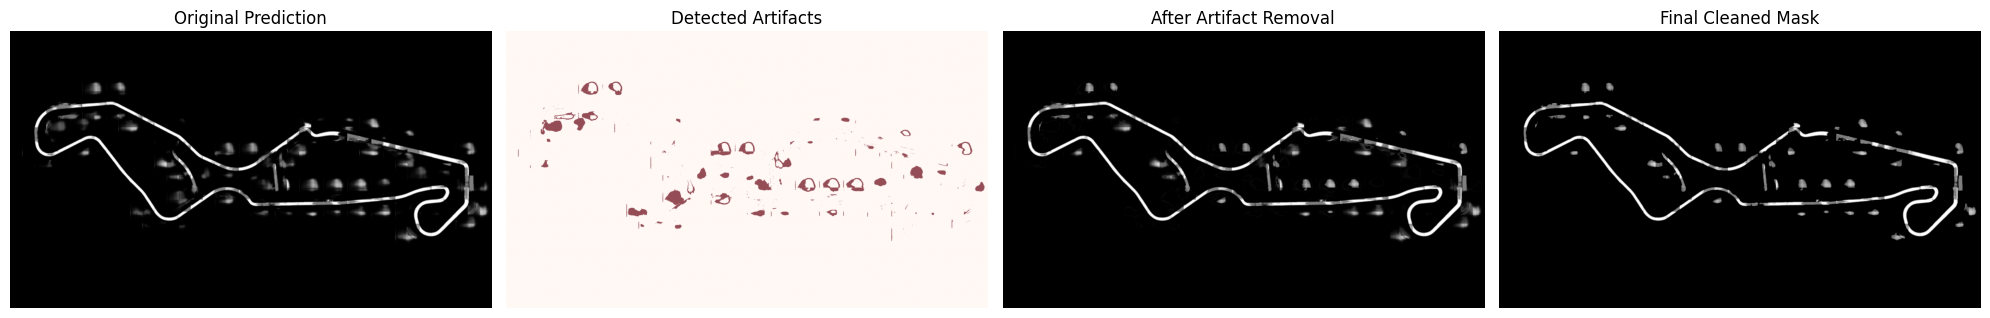

Removed 76403 artifact pixels
Connecting clean road segments...


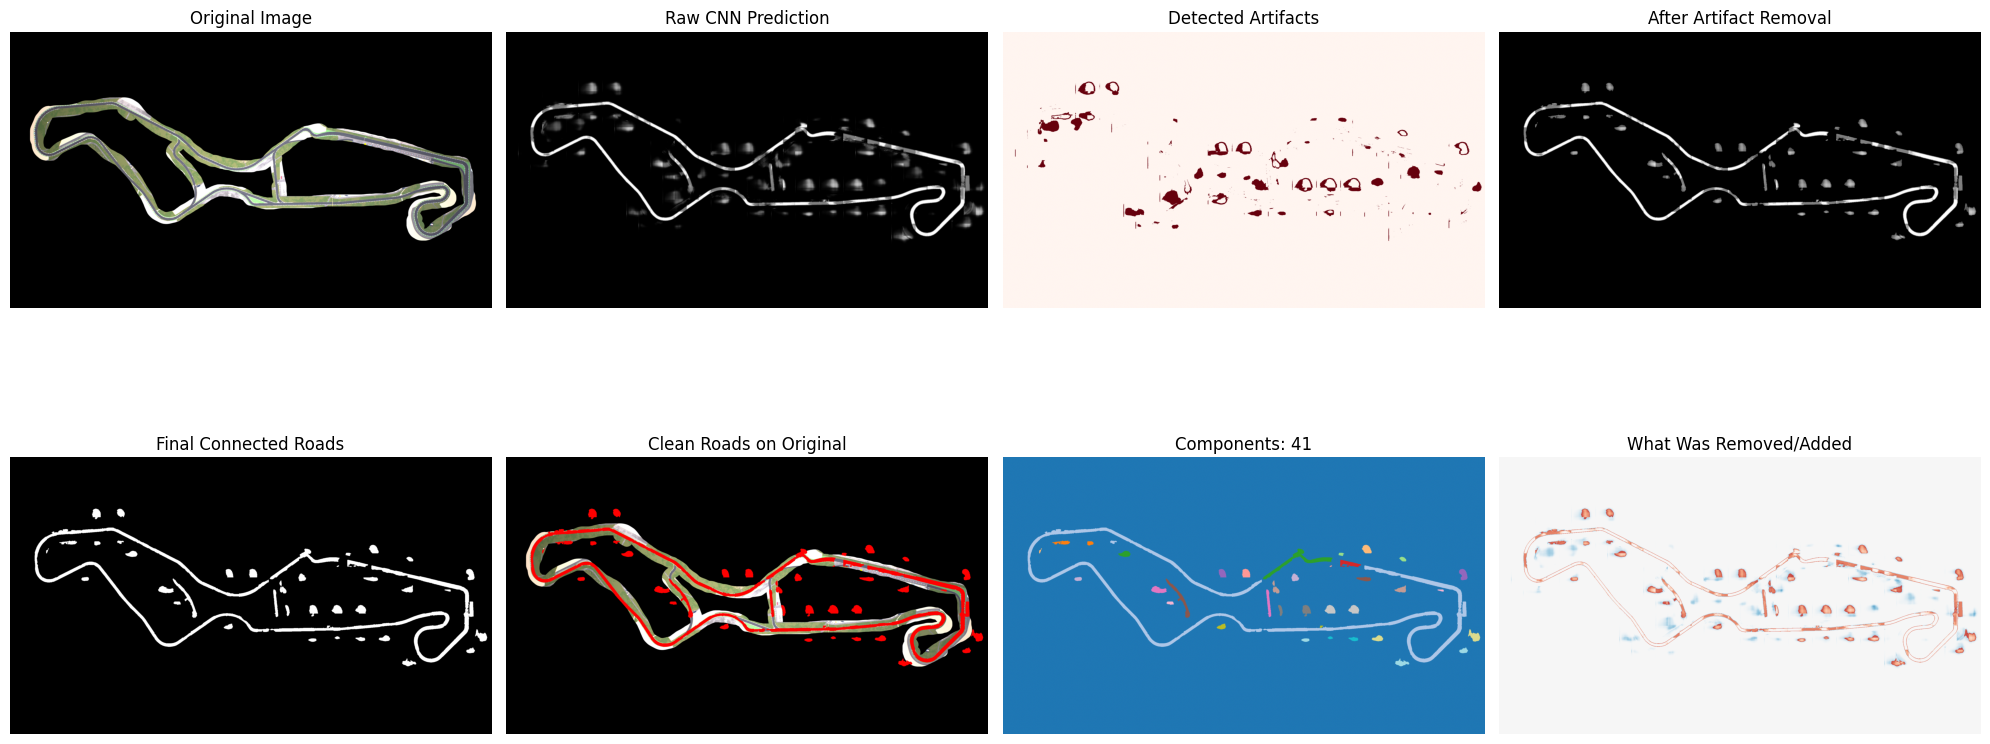

Saving results...


AttributeError: 'numpy.ndarray' object has no attribute 'ast'

In [18]:
# Step 4: Run the processing
print("Starting artifact removal and clean road extraction...")
original_image, raw_mask, clean_mask, final_mask, artifacts = process_image_with_artifact_removal(IMAGE_PATH, model)

# Step 5: Final visualization
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(raw_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Raw CNN Prediction')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(artifacts, cmap='Reds')
plt.title('Detected Artifacts')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(clean_mask, cmap='gray', vmin=0, vmax=1)
plt.title('After Artifact Removal')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(final_mask, cmap='gray')
plt.title('Final Connected Roads')
plt.axis('off')

# Overlay on original
plt.subplot(2, 4, 6)
overlay = np.array(original_image)
road_pixels = final_mask > 0
overlay[road_pixels] = [255, 0, 0]  # Red roads
plt.imshow(overlay)
plt.title('Clean Roads on Original')
plt.axis('off')

# Connectivity analysis
labeled_final = measure.label(final_mask)
plt.subplot(2, 4, 7)
plt.imshow(labeled_final, cmap='tab20')
plt.title(f'Components: {labeled_final.max()}')
plt.axis('off')

# Show difference
plt.subplot(2, 4, 8)
difference = raw_mask - (final_mask.astype(np.float32))
plt.imshow(difference, cmap='RdBu', vmin=-1, vmax=1)
plt.title('What Was Removed/Added')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save results
print("Saving results...")
final_clean = (final_mask * 255).astype(np.uint8)
Image.fromarray(final_clean).save('clean_circuit.png')

artifacts_image = (artifacts * 255).ast(np.uint8)
Image.fromarray(artifacts_image).save('detected_artifacts.png')

print(f"\nFinal Analysis:")
print(f"Connected components: {labeled_final.max()}")
print(f"Artifacts removed: {np.sum(artifacts)} pixels")
print(f"Clean road pixels: {np.sum(final_mask > 0)}")
print(f"Circuit status: {'COMPLETE' if labeled_final.max() == 1 else f'FRAGMENTED ({labeled_final.max()} pieces)'}")

print("Processing complete! Check 'clean_circuit.png' and 'detected_artifacts.png'")

Total tiles: 252
Tiles to process: 81
Tiles ignored (black): 171


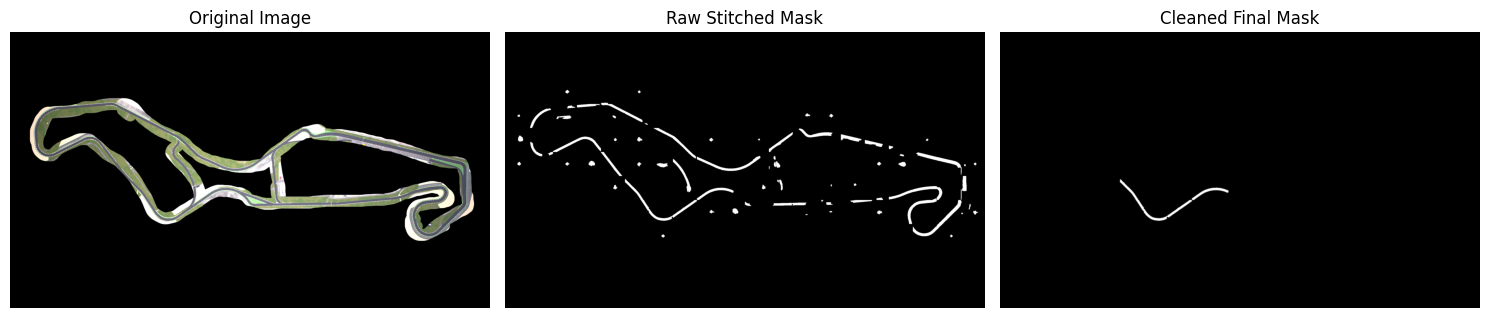

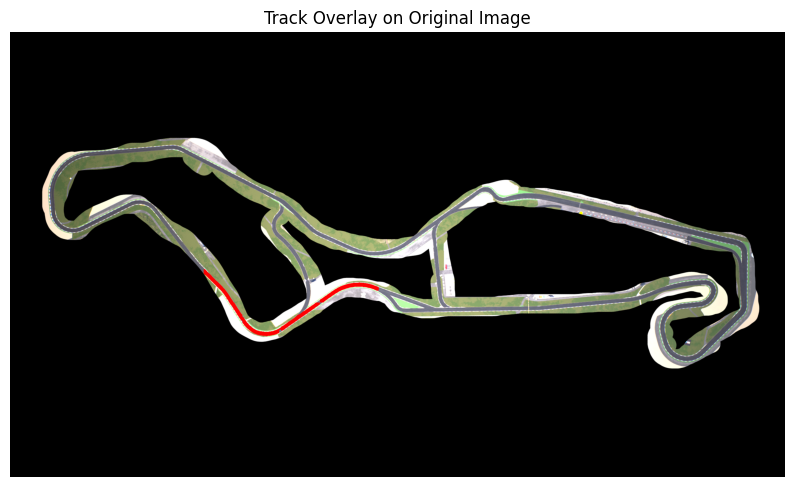

In [102]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)

# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    # Create mask for black pixels
    black_mask = np.all(tile_array == black_color, axis=-1)
    
    # Calculate percentage of black pixels
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

# Step 4: Modified tile_image function to filter black tiles
def tile_image(image, tile_size=(128, 128), black_threshold=1.0):
    """
    Splits an image into tiles of given size, filtering out predominantly black tiles.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # Crop tile
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            # If tile is smaller, pad it
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            
            # Check if tile should be ignored
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                # For ignored tiles, we'll still need placeholder coordinates
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Load original image
original_image = Image.open(IMAGE_PATH).convert("RGB")

# Generate tiles with black filtering
tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), black_threshold=1.0)

print(f"Total tiles: {len(tile_coordinates)}")
print(f"Tiles to process: {len(tiles)}")
print(f"Tiles ignored (black): {sum(ignore_mask)}")

# Step 5: Predict on all non-ignored tiles with proper preprocessing
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    tile = tile.astype(np.float32) / 255.0
    return tile

# NEW: Function to post-process predictions to reduce false positives
def postprocess_prediction(prediction, confidence_threshold=0.7, min_size=50):
    """
    Clean up predictions by applying thresholding and removing small artifacts.
    """
    # Apply confidence threshold
    binary_mask = (prediction > confidence_threshold).astype(np.uint8)
    
    # Remove small objects (noise)
    cleaned_mask = ndimage.binary_opening(binary_mask, structure=np.ones((3,3)))
    
    # Remove small connected components
    labeled_mask, num_features = ndimage.label(cleaned_mask)
    component_sizes = np.bincount(labeled_mask.ravel())
    
    # Keep only components larger than min_size
    size_mask = component_sizes >= min_size
    size_mask[0] = 0  # Keep background (label 0)
    cleaned_mask = size_mask[labeled_mask]
    
    # Convert back to float and apply smoothing
    cleaned_float = cleaned_mask.astype(np.float32)
    
    # Apply Gaussian smoothing to reduce hard edges
    cleaned_float = ndimage.gaussian_filter(cleaned_float, sigma=0.5)
    
    return cleaned_float

predictions = []
tile_index = 0

for i, ignore in enumerate(ignore_mask):
    if ignore:
        # Create a blank prediction for ignored tiles (all zeros)
        blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
        predictions.append(blank_prediction)
    else:
        # Process and predict on non-ignored tiles
        processed_tile = preprocess_tile(tiles[tile_index])
        prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)[0]
        
        # NEW: Apply post-processing to clean up the prediction
        cleaned_prediction = postprocess_prediction(np.squeeze(prediction))
        
        # Reshape back to (128, 128, 1)
        predictions.append(cleaned_prediction[:, :, np.newaxis])
        tile_index += 1

# Step 6: Stitch predictions back into full mask
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Place the tile in the stitched image
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

original_size = original_image.size
stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))

# NEW: Apply global post-processing to the entire stitched mask
def postprocess_global_mask(mask, confidence_threshold=0.5, min_track_size=500):
    """
    Apply global post-processing to the entire mask to clean up artifacts
    and ensure consistency across tile boundaries.
    """
    # Apply threshold
    binary_mask = (mask > confidence_threshold).astype(np.uint8)
    
    # Morphological operations to clean up the mask
    kernel = np.ones((5,5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)
    
    # Remove small isolated components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_mask, 8, cv2.CV_32S)
    
    # Find the largest component (likely the track)
    if num_labels > 1:
        largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        final_mask = (labels == largest_component).astype(np.uint8)
    else:
        final_mask = cleaned_mask
    
    # Smooth the edges
    final_mask = cv2.GaussianBlur(final_mask.astype(np.float32), (5, 5), 0)
    
    return final_mask

# Apply global post-processing
final_mask = postprocess_global_mask(stitched_mask)

# Step 7: Show results
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Raw Stitched Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Cleaned Final Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# # Save the cleaned result
# final_mask_image = (final_mask * 255).astype(np.uint8)
# Image.fromarray(final_mask_image).save('cleaned_predicted_mask.png')

# Optional: Overlay the mask on the original image
overlay = np.array(original_image).copy()
overlay[final_mask > 0.5] = [255, 0, 0]  # Highlight track in red

plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title('Track Overlay on Original Image')
plt.axis('off')
plt.show()

Total tiles: 252
Tiles to process: 81
Tiles ignored (black): 171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━

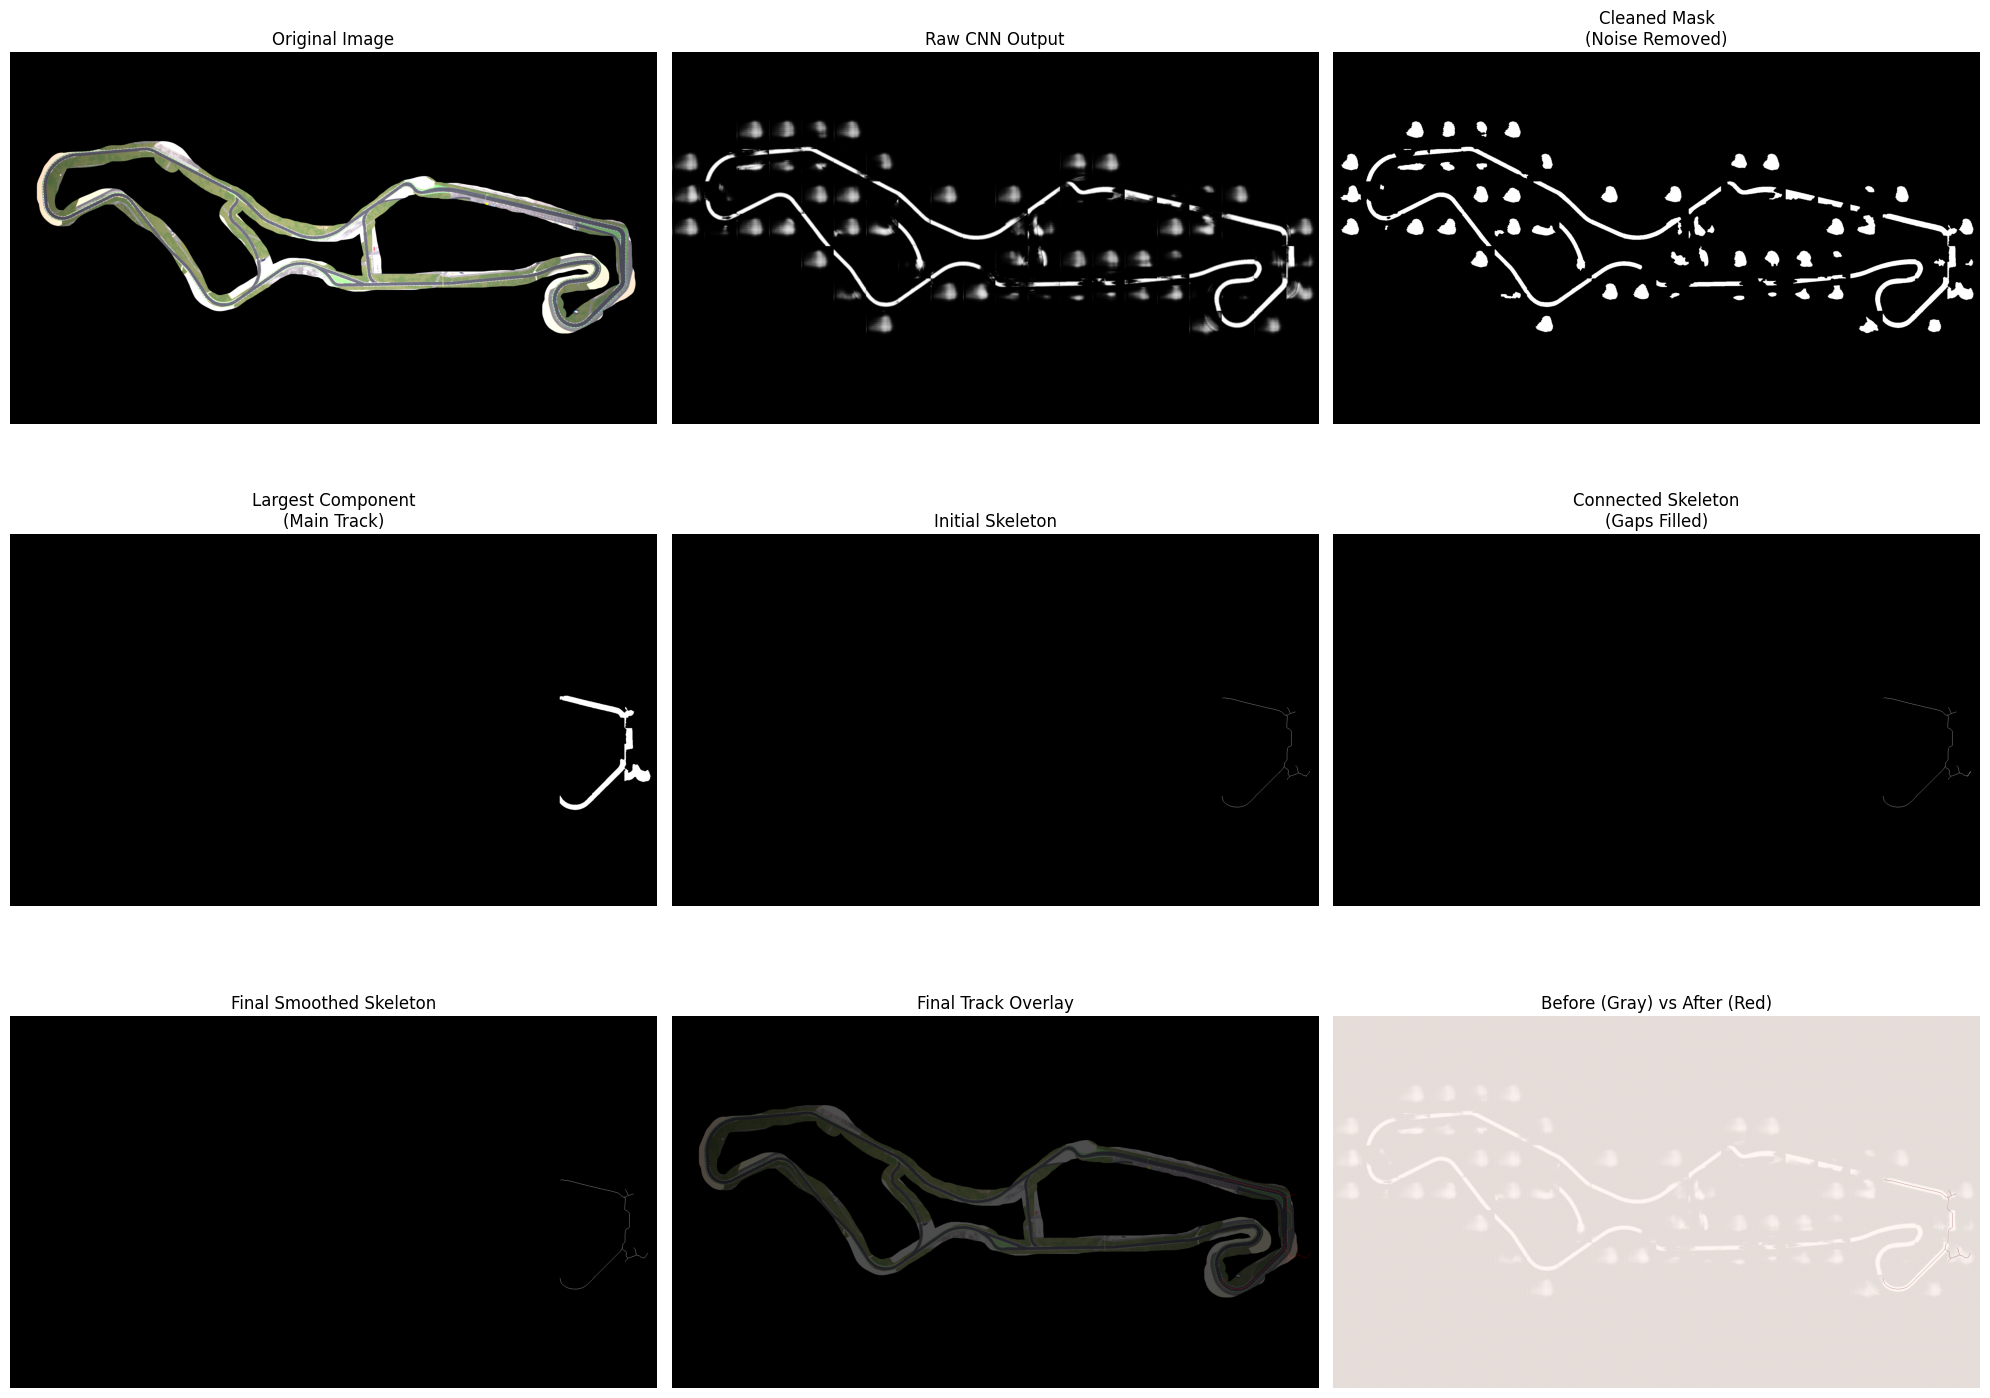

Final cleaned track saved as 'final_cleaned_track.png'
Track overlay saved as 'track_overlay.png'


In [104]:
# Step 1: Imports (including additional libraries for post-processing)
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage
from skimage import morphology, measure, segmentation
from skimage.morphology import skeletonize, remove_small_objects, closing, opening
from skimage.measure import label, regionprops
from scipy.spatial.distance import cdist

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)

# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    # Create mask for black pixels
    black_mask = np.all(tile_array == black_color, axis=-1)
    
    # Calculate percentage of black pixels
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    
    return black_percentage >= black_threshold

# Step 4: Modified tile_image function to filter black tiles
def tile_image(image, tile_size=(128, 128), black_threshold=1.0):
    """
    Splits an image into tiles of given size, filtering out predominantly black tiles.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Step 5: Preprocessing and prediction functions
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    tile = tile.astype(np.float32) / 255.0
    return tile

# Step 6: Modified stitch function
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        if prediction.ndim == 3:
            mask = prediction[:, :, 0]
        else:
            mask = prediction
        
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

# Step 7: NEW POST-PROCESSING FUNCTIONS
def clean_mask_morphological(mask, threshold=0.5):
    """
    Clean the mask using morphological operations to remove noise and fill gaps.
    """
    # Convert to binary
    binary_mask = (mask > threshold).astype(np.uint8)
    
    # Remove small objects (noise/blobs)
    binary_mask = remove_small_objects(binary_mask.astype(bool), min_size=100).astype(np.uint8)
    
    # Morphological closing to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    
    # Morphological opening to remove thin connections/noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    return binary_mask

def extract_largest_component(binary_mask):
    """
    Extract the largest connected component (should be the main track).
    """
    # Label connected components
    labeled = label(binary_mask)
    
    if labeled.max() == 0:  # No components found
        return binary_mask
    
    # Find the largest component
    props = regionprops(labeled)
    largest_area = 0
    largest_label = 0
    
    for prop in props:
        if prop.area > largest_area:
            largest_area = prop.area
            largest_label = prop.label
    
    # Keep only the largest component
    largest_component = (labeled == largest_label).astype(np.uint8)
    
    return largest_component

def skeletonize_track(binary_mask):
    """
    Extract the centerline/skeleton of the track.
    """
    # Skeletonize to get centerline
    skeleton = skeletonize(binary_mask.astype(bool)).astype(np.uint8)
    
    return skeleton

def connect_skeleton_endpoints(skeleton, max_gap=50):
    """
    Try to connect nearby endpoints in the skeleton to close gaps.
    """
    # Find endpoints (pixels with exactly 1 neighbor)
    kernel = np.ones((3, 3), np.uint8)
    neighbors = cv2.filter2D(skeleton.astype(np.uint8), -1, kernel) * skeleton
    endpoints = np.where((neighbors == 2) & (skeleton == 1))
    
    if len(endpoints[0]) < 2:
        return skeleton
    
    endpoint_coords = list(zip(endpoints[1], endpoints[0]))  # (x, y) format
    
    # Find pairs of endpoints that are close enough to connect
    connected_skeleton = skeleton.copy()
    
    for i in range(len(endpoint_coords)):
        for j in range(i + 1, len(endpoint_coords)):
            p1 = endpoint_coords[i]
            p2 = endpoint_coords[j]
            distance = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
            
            if distance <= max_gap:
                # Draw line between endpoints
                cv2.line(connected_skeleton, p1, p2, 1, thickness=1)
    
    return connected_skeleton

def smooth_skeleton(skeleton, iterations=2):
    """
    Smooth the skeleton to reduce jagged edges.
    """
    # Apply slight dilation and erosion to smooth
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    for _ in range(iterations):
        # Dilate then erode
        dilated = cv2.dilate(skeleton, kernel, iterations=1)
        smoothed = cv2.erode(dilated, kernel, iterations=1)
        
        # Keep the skeleton property
        skeleton = skeletonize(smoothed.astype(bool)).astype(np.uint8)
    
    return skeleton

def enhance_with_original_image(skeleton, original_image, track_color_range=None):
    """
    Use the original image to help identify and enhance the track.
    """
    # Convert original to grayscale for analysis
    if len(original_image.shape) == 3:
        gray_orig = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2GRAY)
    else:
        gray_orig = np.array(original_image)
    
    # If we know the track color, we can use it to validate/enhance
    if track_color_range is not None:
        # Create mask for track-colored pixels
        orig_array = np.array(original_image)
        lower_bound, upper_bound = track_color_range
        track_color_mask = cv2.inRange(orig_array, lower_bound, upper_bound)
        
        # Combine with skeleton
        enhanced = cv2.bitwise_or(skeleton * 255, track_color_mask) > 0
        enhanced = enhanced.astype(np.uint8)
    else:
        enhanced = skeleton
    
    return enhanced

# Step 8: Main processing pipeline
def process_track_extraction():
    """
    Main function to process the track extraction with all improvements.
    """
    # Load original image
    original_image = Image.open(IMAGE_PATH).convert("RGB")
    
    # Generate tiles with black filtering
    tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), black_threshold=1.0)
    
    print(f"Total tiles: {len(tile_coordinates)}")
    print(f"Tiles to process: {len(tiles)}")
    print(f"Tiles ignored (black): {sum(ignore_mask)}")
    
    # Predict on all non-ignored tiles
    predictions = []
    tile_index = 0
    
    for i, ignore in enumerate(ignore_mask):
        if ignore:
            blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
            predictions.append(blank_prediction)
        else:
            processed_tile = preprocess_tile(tiles[tile_index])
            prediction = model.predict(np.expand_dims(processed_tile, axis=0))
            predictions.append(prediction[0])
            tile_index += 1
    
    # Stitch predictions back into full mask
    original_size = original_image.size
    stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))
    
    # POST-PROCESSING PIPELINE
    print("Applying post-processing...")
    
    # Step 1: Clean with morphological operations
    cleaned_mask = clean_mask_morphological(stitched_mask, threshold=0.3)
    
    # Step 2: Extract largest connected component
    main_track = extract_largest_component(cleaned_mask)
    
    # Step 3: Skeletonize to get centerline
    skeleton = skeletonize_track(main_track)
    
    # Step 4: Connect nearby endpoints
    connected_skeleton = connect_skeleton_endpoints(skeleton, max_gap=30)
    
    # Step 5: Smooth the skeleton
    final_skeleton = smooth_skeleton(connected_skeleton, iterations=1)
    
    # Optional: Enhance with original image information
    # For a race track, you might know the approximate color range
    # track_color_range = ((100, 100, 100), (255, 255, 255))  # Light colored track
    # final_track = enhance_with_original_image(final_skeleton, original_image, track_color_range)
    
    return original_image, stitched_mask, cleaned_mask, main_track, skeleton, connected_skeleton, final_skeleton

# Step 9: Visualization function
def visualize_processing_steps(original_image, raw_mask, cleaned_mask, main_track, skeleton, connected_skeleton, final_skeleton):
    """
    Visualize all processing steps.
    """
    plt.figure(figsize=(20, 15))
    
    # Original image
    plt.subplot(3, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Raw CNN output
    plt.subplot(3, 3, 2)
    plt.imshow(raw_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Raw CNN Output')
    plt.axis('off')
    
    # Cleaned mask
    plt.subplot(3, 3, 3)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.title('Cleaned Mask\n(Noise Removed)')
    plt.axis('off')
    
    # Largest component
    plt.subplot(3, 3, 4)
    plt.imshow(main_track, cmap='gray')
    plt.title('Largest Component\n(Main Track)')
    plt.axis('off')
    
    # Initial skeleton
    plt.subplot(3, 3, 5)
    plt.imshow(skeleton, cmap='gray')
    plt.title('Initial Skeleton')
    plt.axis('off')
    
    # Connected skeleton
    plt.subplot(3, 3, 6)
    plt.imshow(connected_skeleton, cmap='gray')
    plt.title('Connected Skeleton\n(Gaps Filled)')
    plt.axis('off')
    
    # Final result
    plt.subplot(3, 3, 7)
    plt.imshow(final_skeleton, cmap='gray')
    plt.title('Final Smoothed Skeleton')
    plt.axis('off')
    
    # Overlay on original
    plt.subplot(3, 3, 8)
    plt.imshow(original_image)
    # Create colored overlay
    overlay = np.zeros((*final_skeleton.shape, 3))
    overlay[final_skeleton > 0] = [1, 0, 0]  # Red track
    plt.imshow(overlay, alpha=0.7)
    plt.title('Final Track Overlay')
    plt.axis('off')
    
    # Comparison: Before vs After
    plt.subplot(3, 3, 9)
    plt.imshow(raw_mask, cmap='gray', alpha=0.5, vmin=0, vmax=1)
    plt.imshow(final_skeleton, cmap='Reds', alpha=0.8)
    plt.title('Before (Gray) vs After (Red)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Step 10: Run the complete pipeline
if __name__ == "__main__":
    # Process the track extraction
    results = process_track_extraction()
    original_image, raw_mask, cleaned_mask, main_track, skeleton, connected_skeleton, final_skeleton = results
    
    # Visualize all steps
    visualize_processing_steps(original_image, raw_mask, cleaned_mask, main_track, skeleton, connected_skeleton, final_skeleton)
    
    # Save the final result
    final_track_image = (final_skeleton * 255).astype(np.uint8)
    Image.fromarray(final_track_image).save('final_cleaned_track.png')
    print("Final cleaned track saved as 'final_cleaned_track.png'")
    
    # Optional: Save as colored overlay
    overlay_image = np.array(original_image).copy()
    red_channel = overlay_image[:, :, 0]
    red_channel[final_skeleton > 0] = 255
    overlay_image[:, :, 0] = red_channel
    Image.fromarray(overlay_image).save('track_overlay.png')
    print("Track overlay saved as 'track_overlay.png'")

Loading original image...
Generating tiles...
Total tiles: 252
Tiles to process: 81
Tiles ignored (black): 171
Running CNN predictions...
Analyzing original image...


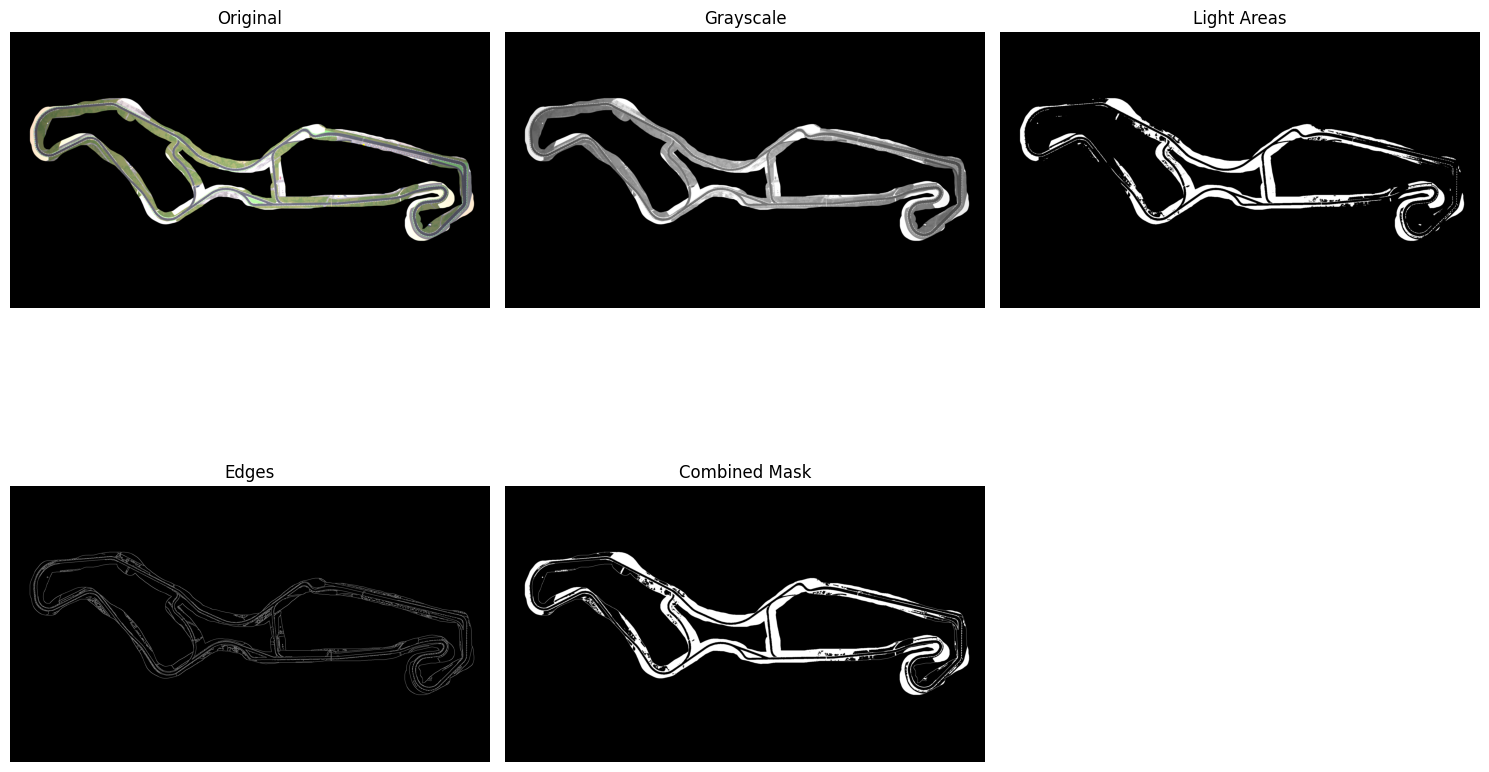

Fusing masks...
Completing track circuit...
Extracting centerline...


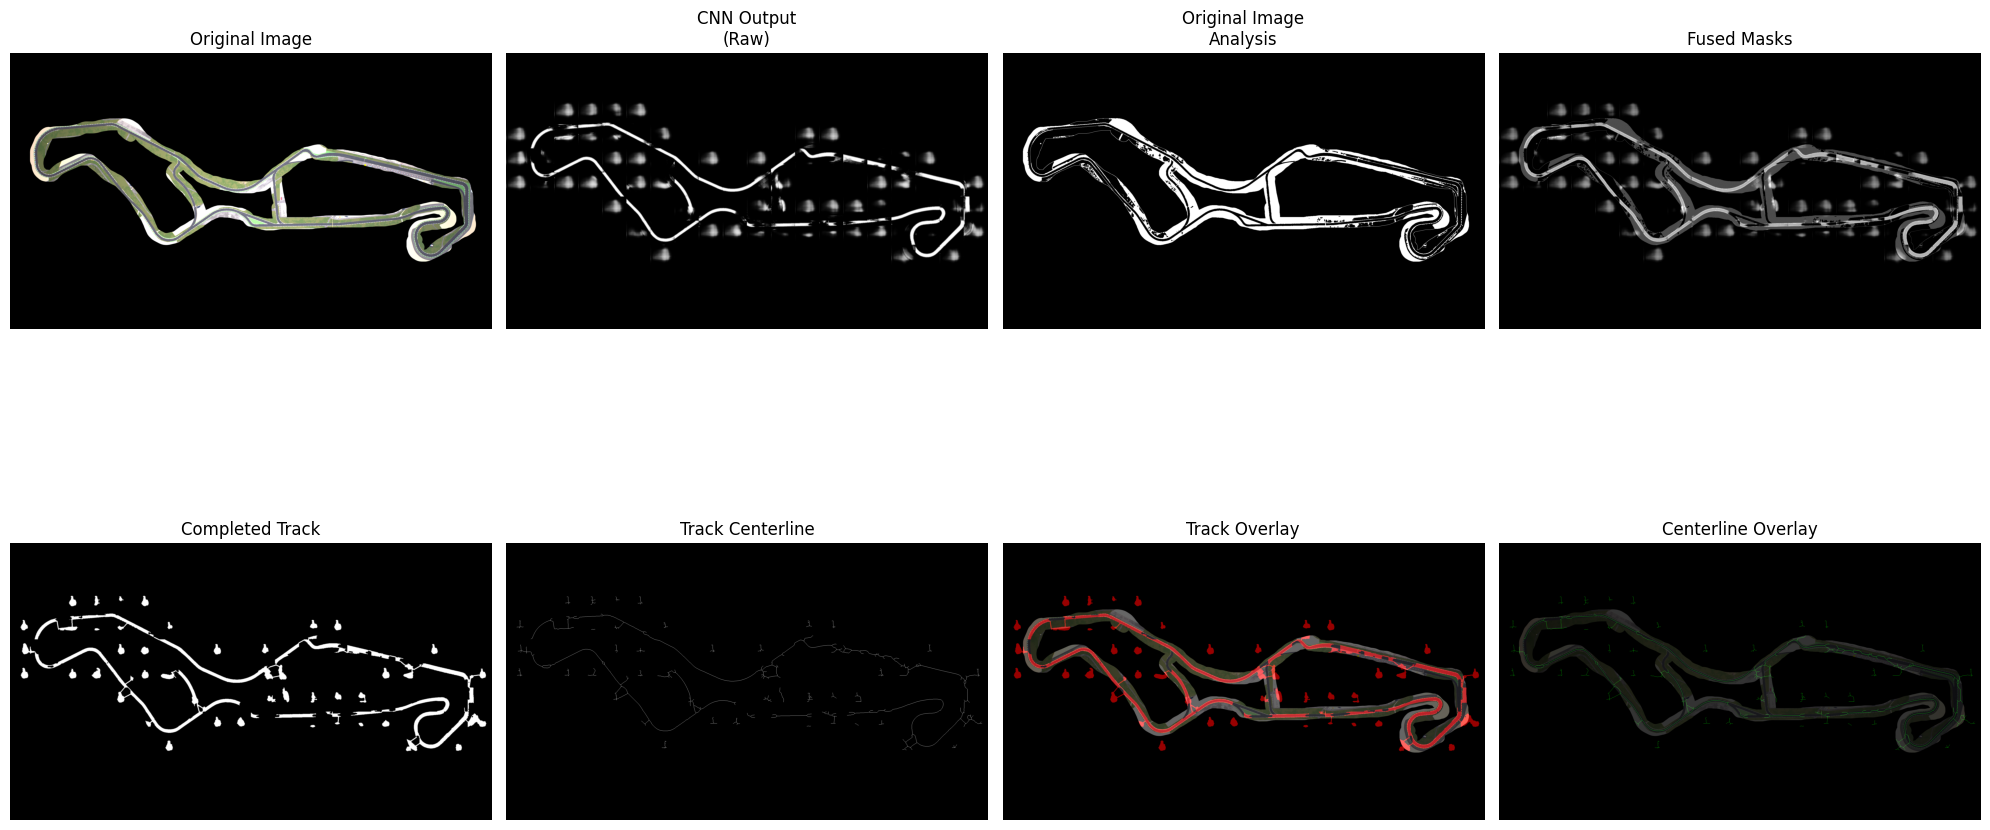

Results saved: 'completed_track.png' and 'track_centerline.png'


In [106]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage
from skimage import morphology, measure
from skimage.morphology import skeletonize, remove_small_objects
from scipy.ndimage import binary_closing, binary_opening

# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)

# Step 3: Function to check if tile should be ignored (predominantly black)
def should_ignore_tile(tile_array, black_threshold=1.0, black_color=(0, 0, 0)):
    """
    Check if a tile should be ignored based on black color percentage.
    """
    if len(tile_array.shape) != 3 or tile_array.shape[2] != 3:
        return False
    
    black_mask = np.all(tile_array == black_color, axis=-1)
    black_percentage = np.sum(black_mask) / (tile_array.shape[0] * tile_array.shape[1])
    return black_percentage >= black_threshold

# Step 4: Tile image function
def tile_image(image, tile_size=(128, 128), black_threshold=1.0):
    """
    Splits an image into tiles of given size, filtering out predominantly black tiles.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []
    tile_ignore_mask = []

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tile_array = np.array(tile)
            ignore_tile = should_ignore_tile(tile_array, black_threshold)
            
            if not ignore_tile:
                tiles.append(tile_array)
                tile_coordinates.append((x, y))
            else:
                tile_coordinates.append((x, y))
            
            tile_ignore_mask.append(ignore_tile)
    
    return tiles, tile_coordinates, tile_ignore_mask

# Step 5: Preprocess tile function
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    tile = tile.astype(np.float32) / 255.0
    return tile

# Step 6: Stitch tiles function
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        if prediction.ndim == 3:
            mask = prediction[:, :, 0]
        else:
            mask = prediction
        
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

# NEW: Improved track extraction using original image analysis
def extract_track_from_original(original_image, display_steps=False):
    """
    Extract track directly from original image using color analysis and edge detection.
    """
    img_array = np.array(original_image)
    
    # Convert to different color spaces for analysis
    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    # Method 1: Color-based detection (for light-colored tracks)
    # Detect light/white areas that could be track
    light_mask = cv2.inRange(gray, 150, 255)
    
    # Method 2: Edge-based detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Method 3: Adaptive thresholding to find track boundaries
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 11, 2)
    
    # Combine methods
    combined_mask = cv2.bitwise_or(light_mask, edges)
    
    # Clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    if display_steps:
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1)
        plt.imshow(original_image)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(light_mask, cmap='gray')
        plt.title('Light Areas')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(edges, cmap='gray')
        plt.title('Edges')
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(combined_mask, cmap='gray')
        plt.title('Combined Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return combined_mask / 255.0  # Normalize to 0-1

# NEW: Smart mask fusion
def fuse_cnn_and_original_masks(cnn_mask, original_mask, cnn_weight=0.7, original_weight=0.3):
    """
    Intelligently combine CNN predictions with original image analysis.
    """
    # Normalize both masks
    cnn_norm = (cnn_mask - cnn_mask.min()) / (cnn_mask.max() - cnn_mask.min() + 1e-8)
    orig_norm = (original_mask - original_mask.min()) / (original_mask.max() - original_mask.min() + 1e-8)
    
    # Weighted combination
    fused = cnn_weight * cnn_norm + original_weight * orig_norm
    
    # Apply threshold
    fused_binary = (fused > 0.4).astype(np.float32)
    
    return fused, fused_binary

# NEW: Advanced post-processing for track completion
def complete_track_circuit(mask, min_component_size=200, max_gap_distance=50):
    """
    Advanced post-processing to complete the track circuit.
    """
    # Convert to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Remove very small noise components
    binary_mask = remove_small_objects(binary_mask.astype(bool), min_size=50).astype(np.uint8)
    
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, 8, cv2.CV_32S)
    
    # Keep components that are large enough to be part of the track
    valid_components = []
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_component_size:
            valid_components.append(i)
    
    if len(valid_components) == 0:
        return binary_mask.astype(np.float32)
    
    # Create mask with only valid components
    track_mask = np.zeros_like(binary_mask)
    for comp_id in valid_components:
        track_mask[labels == comp_id] = 1
    
    # If we have multiple components, try to connect them
    if len(valid_components) > 1:
        track_mask = connect_track_components(track_mask, max_gap_distance)
    
    # Smooth the track
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    track_mask = cv2.morphologyEx(track_mask, cv2.MORPH_CLOSE, kernel)
    
    # Final smoothing
    track_mask = cv2.GaussianBlur(track_mask.astype(np.float32), (3, 3), 0)
    
    return track_mask

# NEW: Function to connect track components
def connect_track_components(binary_mask, max_distance=50):
    """
    Try to connect separate track components by finding shortest paths.
    """
    # Find contours of each component
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) <= 1:
        return binary_mask
    
    # Create output mask
    connected_mask = binary_mask.copy()
    
    # For each pair of contours, find the closest points
    for i in range(len(contours)):
        for j in range(i + 1, len(contours)):
            # Find closest points between contours
            min_dist = float('inf')
            closest_points = None
            
            for pt1 in contours[i]:
                for pt2 in contours[j]:
                    dist = np.sqrt((pt1[0][0] - pt2[0][0])**2 + (pt1[0][1] - pt2[0][1])**2)
                    if dist < min_dist:
                        min_dist = dist
                        closest_points = (tuple(pt1[0]), tuple(pt2[0]))
            
            # If points are close enough, connect them
            if min_dist <= max_distance:
                cv2.line(connected_mask, closest_points[0], closest_points[1], 1, thickness=3)
    
    return connected_mask

# NEW: Extract centerline/skeleton
def extract_track_centerline(mask, smooth_iterations=2):
    """
    Extract the centerline of the track.
    """
    # Convert to binary
    binary_mask = (mask > 0.5).astype(bool)
    
    # Get skeleton
    skeleton = skeletonize(binary_mask)
    
    # Smooth the skeleton
    for _ in range(smooth_iterations):
        # Dilate and erode to smooth
        kernel = np.ones((3, 3), np.uint8)
        dilated = cv2.dilate(skeleton.astype(np.uint8), kernel, iterations=1)
        smoothed = cv2.erode(dilated, kernel, iterations=1)
        skeleton = skeletonize(smoothed.astype(bool))
    
    return skeleton.astype(np.float32)

# Main processing pipeline
def main_processing():
    """
    Main function that orchestrates the entire track extraction process.
    """
    print("Loading original image...")
    original_image = Image.open(IMAGE_PATH).convert("RGB")
    
    print("Generating tiles...")
    tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), black_threshold=1.0)
    
    print(f"Total tiles: {len(tile_coordinates)}")
    print(f"Tiles to process: {len(tiles)}")
    print(f"Tiles ignored (black): {sum(ignore_mask)}")
    
    # CNN predictions
    print("Running CNN predictions...")
    predictions = []
    tile_index = 0
    
    for i, ignore in enumerate(ignore_mask):
        if ignore:
            blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
            predictions.append(blank_prediction)
        else:
            processed_tile = preprocess_tile(tiles[tile_index])
            prediction = model.predict(np.expand_dims(processed_tile, axis=0), verbose=0)[0]
            predictions.append(prediction)
            tile_index += 1
    
    # Stitch CNN results
    original_size = original_image.size
    cnn_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))
    
    # Extract track from original image
    print("Analyzing original image...")
    original_track_mask = extract_track_from_original(original_image, display_steps=True)
    
    # Fuse CNN and original image results
    print("Fusing masks...")
    fused_mask, fused_binary = fuse_cnn_and_original_masks(cnn_mask, original_track_mask)
    
    # Complete the track circuit
    print("Completing track circuit...")
    completed_track = complete_track_circuit(fused_binary, min_component_size=200, max_gap_distance=40)
    
    # Extract centerline
    print("Extracting centerline...")
    centerline = extract_track_centerline(completed_track)
    
    return original_image, cnn_mask, original_track_mask, fused_mask, completed_track, centerline

# Visualization function
def visualize_all_results(original_image, cnn_mask, original_mask, fused_mask, completed_track, centerline):
    """
    Visualize all processing steps.
    """
    plt.figure(figsize=(20, 12))
    
    # Original image
    plt.subplot(2, 4, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    # CNN output
    plt.subplot(2, 4, 2)
    plt.imshow(cnn_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('CNN Output\n(Raw)')
    plt.axis('off')
    
    # Original image analysis
    plt.subplot(2, 4, 3)
    plt.imshow(original_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Original Image\nAnalysis')
    plt.axis('off')
    
    # Fused result
    plt.subplot(2, 4, 4)
    plt.imshow(fused_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Fused Masks')
    plt.axis('off')
    
    # Completed track
    plt.subplot(2, 4, 5)
    plt.imshow(completed_track, cmap='gray', vmin=0, vmax=1)
    plt.title('Completed Track')
    plt.axis('off')
    
    # Centerline
    plt.subplot(2, 4, 6)
    plt.imshow(centerline, cmap='gray', vmin=0, vmax=1)
    plt.title('Track Centerline')
    plt.axis('off')
    
    # Overlay on original
    plt.subplot(2, 4, 7)
    plt.imshow(original_image)
    overlay = np.zeros((*completed_track.shape, 3))
    overlay[completed_track > 0.5] = [1, 0, 0]  # Red
    plt.imshow(overlay, alpha=0.6)
    plt.title('Track Overlay')
    plt.axis('off')
    
    # Centerline overlay
    plt.subplot(2, 4, 8)
    plt.imshow(original_image)
    centerline_overlay = np.zeros((*centerline.shape, 3))
    centerline_overlay[centerline > 0.5] = [0, 1, 0]  # Green
    plt.imshow(centerline_overlay, alpha=0.8)
    plt.title('Centerline Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the complete pipeline
if __name__ == "__main__":
    results = main_processing()
    original_image, cnn_mask, original_mask, fused_mask, completed_track, centerline = results
    
    # Visualize everything
    visualize_all_results(original_image, cnn_mask, original_mask, fused_mask, completed_track, centerline)
    
    # Save results
    completed_track_image = (completed_track * 255).astype(np.uint8)
    Image.fromarray(completed_track_image).save('completed_track.png')
    
    centerline_image = (centerline * 255).astype(np.uint8)
    Image.fromarray(centerline_image).save('track_centerline.png')
    
    print("Results saved: 'completed_track.png' and 'track_centerline.png'")

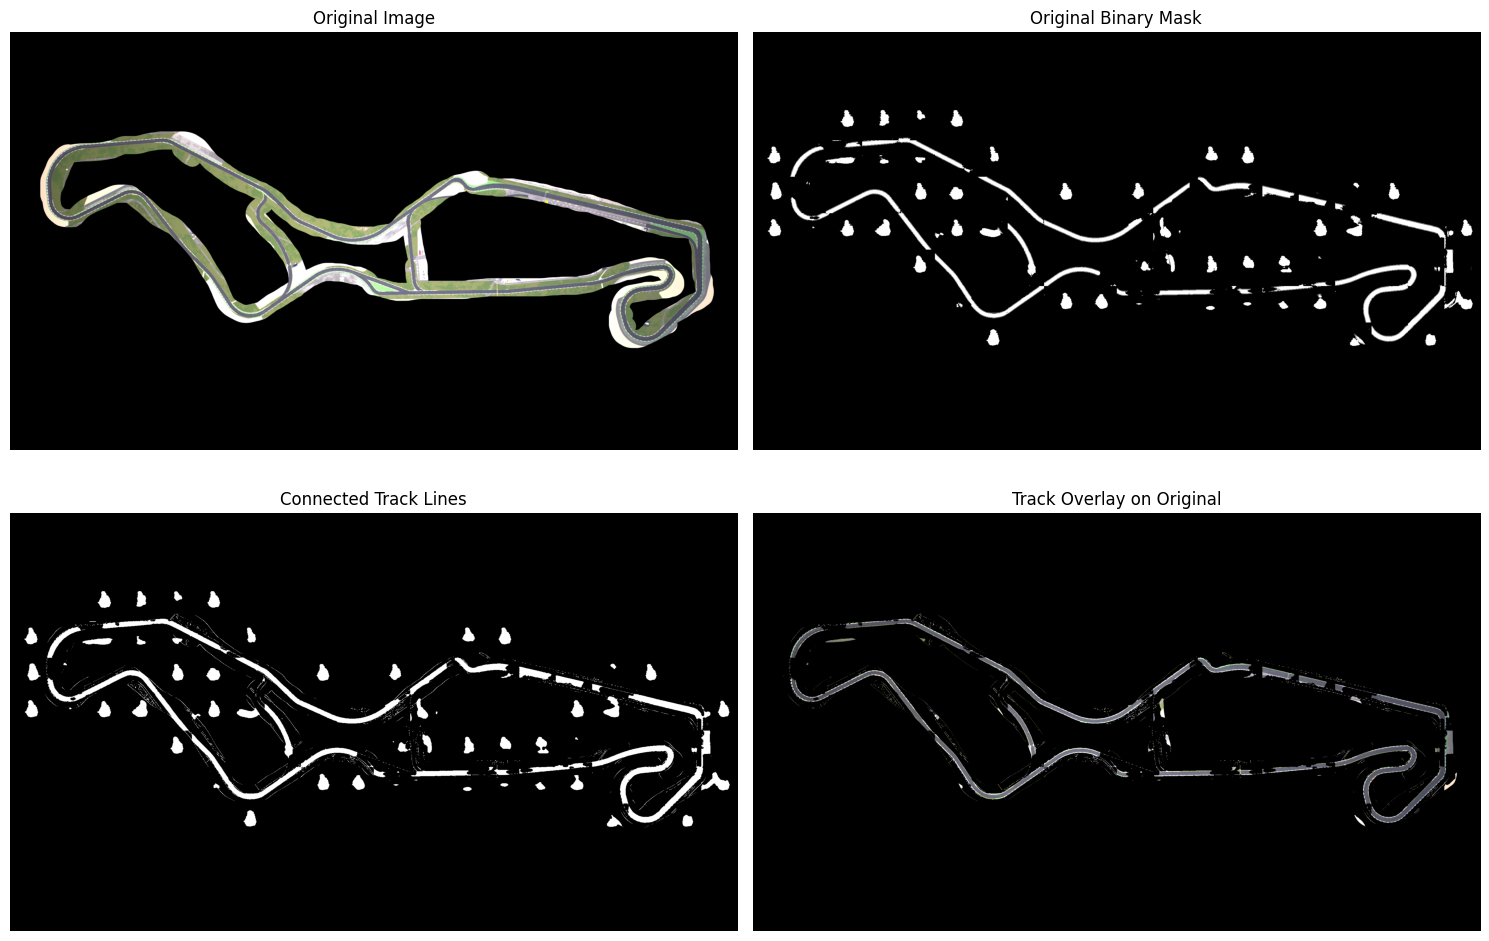

In [97]:
# After your existing code...
# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)

# Connect the track lines
def connect_track_lines_optimized(binary_mask, original_image=None):
    """
    Optimized function to connect track lines with multiple techniques.
    """
    binary_mask_uint8 = binary_mask.astype(np.uint8) * 255
    
    # Method 1: Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    connected = cv2.morphologyEx(binary_mask_uint8, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Method 2: Optional - use original image info if available
    if original_image is not None:
        # Convert original image to grayscale for edge detection
        gray_original = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray_original, 50, 150)
        
        # Combine with our mask (OR operation)
        connected = cv2.bitwise_or(connected, edges)
    
    # Method 3: Final smoothing
    connected = cv2.medianBlur(connected, 3)
    
    return connected // 255

# Use the original image to help with connection
connected_mask = connect_track_lines_optimized(binary_mask, original_image)

# Visualize results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Original Binary Mask')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(connected_mask, cmap='gray')
plt.title('Connected Track Lines')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.bitwise_and(np.array(original_image), np.array(original_image), 
                          mask=connected_mask.astype(np.uint8) * 255))
plt.title('Track Overlay on Original')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save connected mask
connected_mask_image = (connected_mask * 255).astype(np.uint8)
Image.fromarray(connected_mask_image).save('connected_track_mask.png')

Total tiles: 252
Tiles to process: 113
Tiles ignored (pink): 139


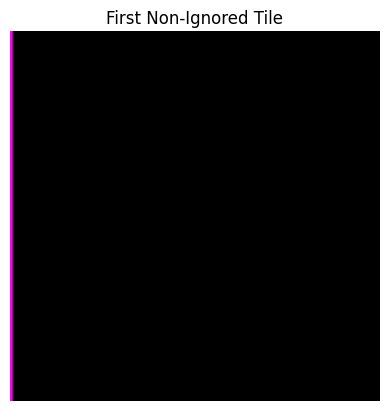

In [75]:
# Load original image
original_image = Image.open(IMAGE_PATH).convert("RGB")

# Generate tiles with pink filtering
tiles, tile_coordinates, ignore_mask = tile_image(original_image, tile_size=(128, 128), pink_threshold=1.0)

print(f"Total tiles: {len(tile_coordinates)}")
print(f"Tiles to process: {len(tiles)}")
print(f"Tiles ignored (pink): {sum(ignore_mask)}")

# Show the first non-ignored tile if available
if len(tiles) > 0:
    plt.imshow(tiles[0])
    plt.title("First Non-Ignored Tile")
    plt.axis("off")
    plt.show()
else:
    print("All tiles were ignored!")

In [76]:
# Step 5: Predict on all non-ignored tiles with proper preprocessing
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    # Convert to float and normalize to [0, 1]
    tile = tile.astype(np.float32) / 255.0
    return tile

predictions = []
tile_index = 0

for i, ignore in enumerate(ignore_mask):
    if ignore:
        # Create a blank prediction for ignored tiles (all zeros)
        blank_prediction = np.zeros((128, 128, 1), dtype=np.float32)
        predictions.append(blank_prediction)
    else:
        # Process and predict on non-ignored tiles
        processed_tile = preprocess_tile(tiles[tile_index])
        prediction = model.predict(np.expand_dims(processed_tile, axis=0))
        predictions.append(prediction[0])  # Remove batch dimension
        tile_index += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

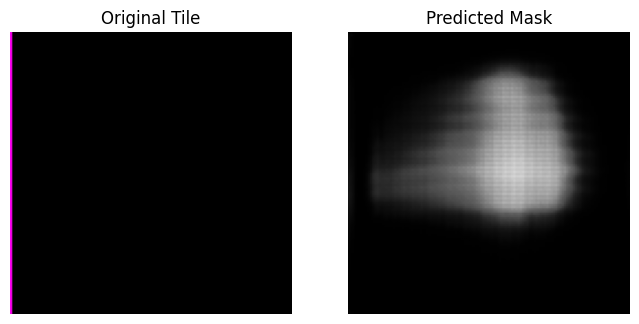

In [77]:
# Step 6: Visualization function
def visualize_results(predicted_mask, original_image):
    predicted_mask = np.squeeze(predicted_mask)
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Tile')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Show results for first non-ignored tile if available
if len(tiles) > 0:
    first_non_ignored_idx = next((i for i, ignore in enumerate(ignore_mask) if not ignore), None)
    if first_non_ignored_idx is not None:
        visualize_results(predictions[first_non_ignored_idx], 
                         tiles[first_non_ignored_idx - sum(ignore_mask[:first_non_ignored_idx])])


In [78]:
# Step 7: Modified stitch function to handle ignored tiles
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    Handles ignored tiles by leaving those areas blank (0).
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Place the tile in the stitched image
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched

In [79]:
# Step 8: Stitch predictions back into full mask
original_size = original_image.size  # (width, height)
stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))

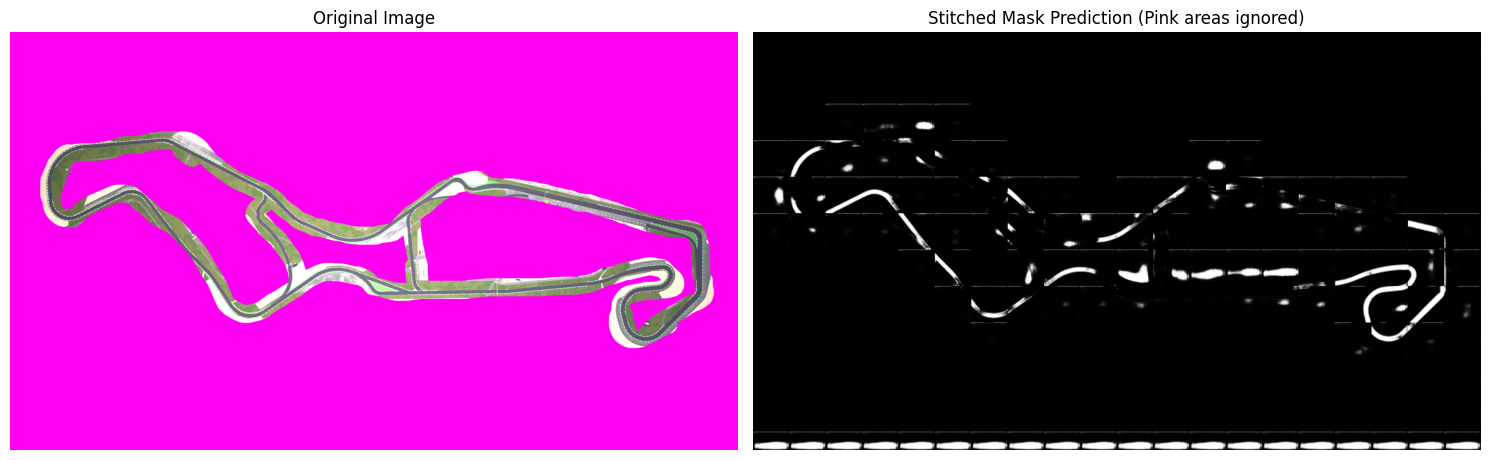

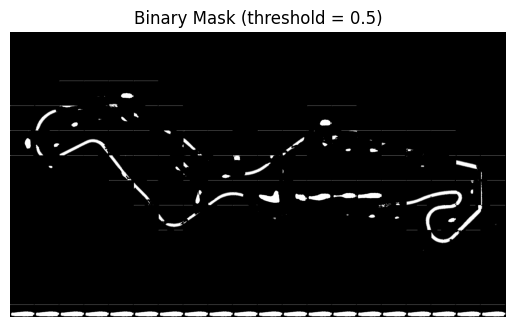

In [80]:
# Step 9: Show stitched result
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask Prediction (Pink areas ignored)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the result
stitched_mask_image = (stitched_mask * 255).astype(np.uint8)
Image.fromarray(stitched_mask_image).save('predicted_mask.png')

# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')
plt.show()

In [81]:
def stitch_tiles(tiles, image_size, tile_size=(128, 128)):
    """
    Stitches a list of tiles back into the original image size.

    Args:
        tiles (list of np.ndarray): List of tiles (predictions or images).
        image_size (tuple): (width, height) of the original image.
        tile_size (tuple): Size of each tile (width, height).

    Returns:
        np.ndarray: Stitched image.
    """
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)  # for mask, 1 channel

    tile_idx = 0
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            tile = tiles[tile_idx]

            # Ensure tile is 2D (mask only)
            if tile.ndim == 4:  # (1, H, W, 1)
                tile = tile[0, :, :, 0]
            elif tile.ndim == 3 and tile.shape[-1] == 1:  # (H, W, 1)
                tile = tile[:, :, 0]

            h = min(tile_size[1], height - y)
            w = min(tile_size[0], width - x)

            stitched[y:y+h, x:x+w] = tile[:h, :w]
            tile_idx += 1

    return stitched


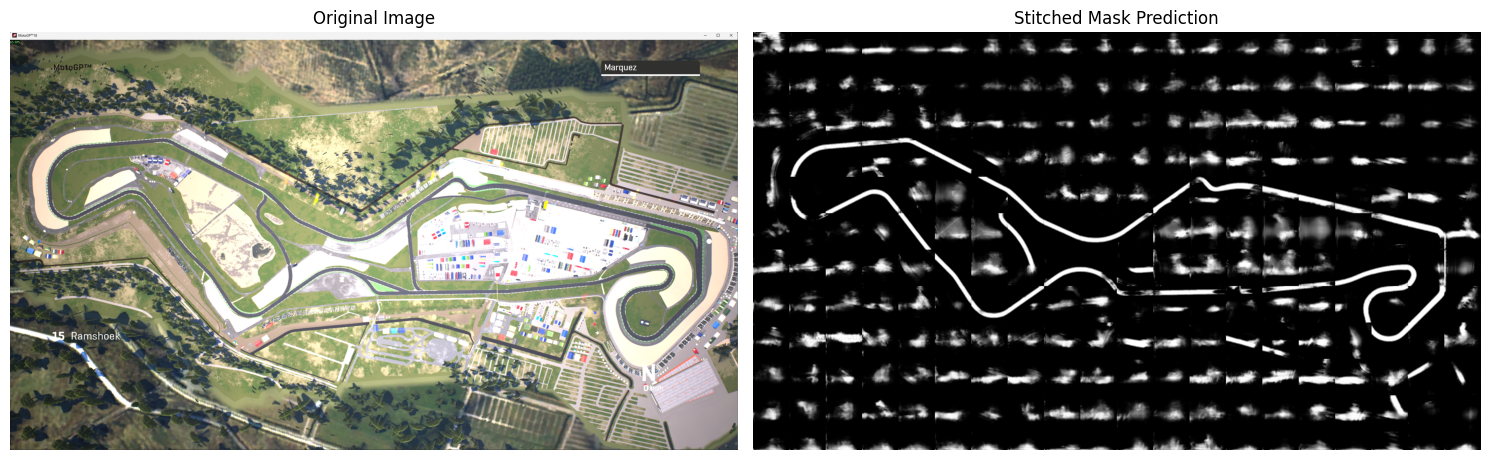

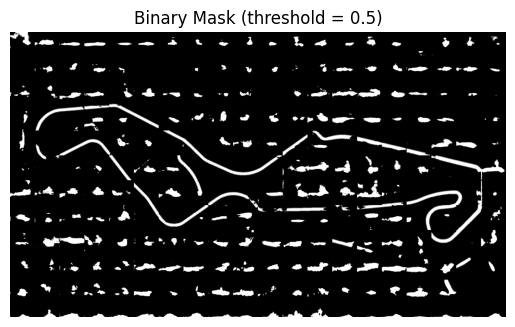

In [12]:
# Step 10: Show stitched result
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the result
stitched_mask_image = (stitched_mask * 255).astype(np.uint8)
Image.fromarray(stitched_mask_image).save('predicted_mask.png')

# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')
plt.show()

In [13]:
def tile_image_large(image, crop_size=(246, 246), model_input_size=(128, 128)):
    """
    Splits an image into larger tiles and resizes them for the model.

    Args:
        image (PIL.Image or np.ndarray): Input image.
        crop_size (tuple): (width, height) of the crop from original image.
        model_input_size (tuple): Size to resize for the model.

    Returns:
        list: List of resized tiles (for model).
        list: List of original-sized tiles (for later upscaling mask).
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    resized_tiles = []
    original_tiles = []

    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            # Crop larger tile
            tile = image.crop((x, y, x + crop_size[0], y + crop_size[1]))

            # Pad if smaller
            if tile.size != crop_size:
                new_tile = Image.new("RGB", crop_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            original_tiles.append(np.array(tile))  # Save original crop size
            resized_tile = tile.resize(model_input_size, Image.BILINEAR)
            resized_tiles.append(np.array(resized_tile))

    return resized_tiles, original_tiles


In [14]:
# Load and create tiles
resized_tiles, original_tiles = tile_image_large(original_image, crop_size=(246, 246), model_input_size=(128, 128))

predictions = []
for tile in resized_tiles:
    tile_input = np.expand_dims(tile, axis=0)
    pred = model.predict(tile_input, verbose=0)
    # Upscale back to crop size for stitching
    pred_upscaled = Image.fromarray(np.squeeze(pred) * 255).resize((246, 246), Image.BILINEAR)
    pred_upscaled = np.array(pred_upscaled) / 255.0
    predictions.append(pred_upscaled)


In [15]:
def stitch_tiles_large(tiles, image_size, crop_size=(246, 246)):
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)

    tile_idx = 0
    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            h = min(crop_size[1], height - y)
            w = min(crop_size[0], width - x)
            stitched[y:y+h, x:x+w] = tiles[tile_idx][:h, :w]
            tile_idx += 1

    return stitched

stitched_mask = stitch_tiles_large(predictions, original_image.size, crop_size=(246, 246))


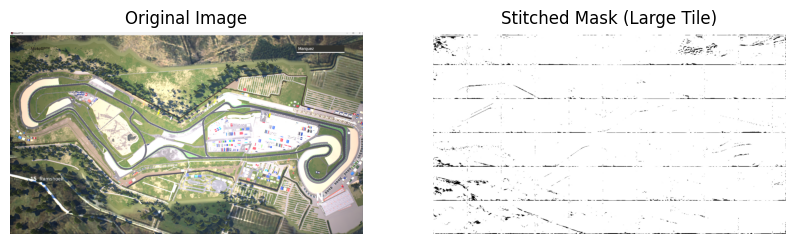

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask (Large Tile)')
plt.axis('off')
plt.show()
